# City of Toronto Open Data Analysis

In [1]:
# Importing all the required libraries

# data preprocessing
import pandas as pd
import numpy as np
import json
import calendar
# for API calls
import requests
import time
from typing import List, Dict
import logging
# visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio


# Loading Data

In [ ]:
# read the data from the CSVs
file_url_clicks_df = pd.read_csv('./data/File URL Clicks.csv')
page_views_df = pd.read_csv('./data/page views over time.csv')
referrers_df = pd.read_csv('./data/referrers over time.csv')
search_terms_df = pd.read_csv('./data/search terms over time.csv')
ip_views_df = pd.read_csv('./data/views per ip over time.csv')
# The IP Views Dataset contains sensitive IP addresses, and therefore is not present in the repository.
# Although the analysis makes references to this dataset without revealing any IP addresses.

# Loading Metadata

In [ ]:
# loading the package list:
with open("Dataset_Jan2025/all_packages_list.json") as f:
        packages_data = json.load(f)
    
packages_list = packages_data["result"]
print(packages_list)

In [ ]:
# function to get all the metadata from the API & create a pandas dataframe out of it. 
# we have also created a file to store the metadata so that from the next time onward, we can reuse it
def fetch_all_package_metadata(
    packages_list: List[str],
    base_url: str = 'https://ckan0.cf.opendata.inter.prod-toronto.ca/api/action/package_show',
    delay_seconds: float = 0.5,
    output_file: str = "all_packages_metadata.json"
) -> pd.DataFrame:

    # Setup logging
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)
    
    # Initialize results dictionary
    results = {"result": {"results": []}}
    
    # Track progress
    total_packages = len(packages_list)
    
    for index, package_id in enumerate(packages_list, 1):
        try:
            # Construct URL for this package
            url = f"{base_url}?id={package_id}"
            
            # Make request
            logger.info(f"Fetching metadata for package {index}/{total_packages}: {package_id}")
            response = requests.get(url)
            
            # Check if request was successful
            if response.status_code == 200:
                # Add the result to our list
                results["result"]["results"].append(response.json()["result"])
            else:
                logger.error(f"Failed to fetch {package_id}. Status code: {response.status_code}")
                results["result"]["results"].append({
                    "name": package_id,
                    "error": f"HTTP {response.status_code}"
                })
                
        except Exception as e:
            logger.error(f"Error fetching {package_id}: {str(e)}")
            results["result"]["results"].append({
                "name": package_id,
                "error": str(e)
            })
            
        # Save progress periodically (every 10 datasets)
        if index % 10 == 0:
            with open(output_file, 'w') as f:
                json.dump(results, f, indent=2)
            
        # Rate limiting delay
        time.sleep(delay_seconds)
    
    # Save final results
    with open(output_file, 'w') as f:
        json.dump(results, f, indent=2)
    
    logger.info(f"Completed fetching metadata for {total_packages} packages")
    
    # Convert to DataFrame
    df = pd.json_normalize(results["result"]["results"])
    
    return df

In [ ]:
metadata_df = fetch_all_package_metadata(packages_list=packages_list, delay_seconds=0.5)

### Loading Metadata from File

From the next time onwards, we can read the data from the JSON file that we have written into.

In [4]:
# Read the JSON file
with open("Dataset_Jan2025/all_packages_metadata.json") as f:
    data = json.load(f)

# Extract the results list from the nested structure
packages_metadata = data["result"]["results"]

# Convert to DataFrame using json_normalize to flatten nested JSON
metadata_df = pd.json_normalize(packages_metadata)

## Cleaning Metadata

In [5]:
metadata_df.head()

author         author_email civic_issues  \
0   cycling@toronto.ca   cycling@toronto.ca   [Mobility]   
1   cycling@toronto.ca   cycling@toronto.ca   [Mobility]   
2  tsssdata@toronto.ca  tsssdata@toronto.ca          NaN   
3  tsssdata@toronto.ca  tsssdata@toronto.ca          NaN   
4  tsssdata@toronto.ca  tsssdata@toronto.ca          NaN   

                        creator_user_id dataset_category  \
0  329e1506-b545-4fc7-a4ea-e614f220eea7         Document   
1  329e1506-b545-4fc7-a4ea-e614f220eea7         Document   
2  329e1506-b545-4fc7-a4ea-e614f220eea7         Document   
3  329e1506-b545-4fc7-a4ea-e614f220eea7         Document   
4  329e1506-b545-4fc7-a4ea-e614f220eea7         Document   

               date_published  \
0  2019-07-23 16:59:48.710339   
1  2019-07-23 16:59:55.362704   
2  2019-07-23 16:29:29.128936   
3  2019-07-23 16:29:29.128936   
4  2022-09-30 18:43:00.949324   

                                             excerpt      formats  \
0  Council Approved Cycling Network Plan - As of ...        [SHP]   
1  Council Approved Cycling Trails Plan - As of J...        [SHP]   
2  This dataset includes a summary of responses f...  [XLS, XLSX]   
3  This dataset includes a summary of responses f...  [XLS, XLSX]   
4  This dataset includes a summary of responses f...  [XLS, XLSX]   

                                     id  \
0  fa6ac066-adab-4ce4-a16c-0b88ef4ce2b8   
1  56216ea6-90f8-47e4-a183-02b3ca4d21fc   
2  da3f62ec-2bd5-4ef6-9a6e-2a73ef3436f6   
3  77fc81fc-dad7-41c8-953f-f57ad9c5fcb0   
4  5793a972-40fb-4e07-bc98-57c00590907a   

                                     information_url  ...  \
0                   http://toronto.ca/cyclingnetwork  ...   
1               http://toronto.ca/cyclingnetworkplan  ...   
2  https://www.toronto.ca/community-people/housin...  ...   
3                                                NaN  ...   
4  https://www.toronto.ca/community-people/commun...  ...   

         organization.created  organization.is_organization  \
0  2022-03-10T15:38:51.044746                          True   
1  2022-03-10T15:38:51.044746                          True   
2  2022-03-10T15:38:51.044746                          True   
3  2022-03-10T15:38:51.044746                          True   
4  2022-03-10T15:38:51.044746                          True   

  organization.approval_status organization.state    license_id  \
0                     approved             active           NaN   
1                     approved             active           NaN   
2                     approved             active  notspecified   
3                     approved             active  notspecified   
4                     approved             active  notspecified   

                                         limitations owner_section owner_unit  \
0                                                NaN           NaN        NaN   
1                                                NaN           NaN        NaN   
2                                                NaN           NaN        NaN   
3                                                NaN           NaN        NaN   
4  Users should use caution when analyzing data f...           NaN        NaN   

  collection_method  url  
0               NaN  NaN  
1               NaN  NaN  
2               NaN  NaN  
3               NaN  NaN  
4               NaN  NaN  

[5 rows x 53 columns]

In [6]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 53 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   author                        511 non-null    object
 1   author_email                  511 non-null    object
 2   civic_issues                  138 non-null    object
 3   creator_user_id               514 non-null    object
 4   dataset_category              514 non-null    object
 5   date_published                514 non-null    object
 6   excerpt                       513 non-null    object
 7   formats                       514 non-null    object
 8   id                            514 non-null    object
 9   information_url               367 non-null    object
 10  is_retired                    488 non-null    object
 11  isopen                        514 non-null    bool  
 12  last_refreshed                514 non-null    object
 13  license_title       

In [7]:
metadata_df['owner_division']

0                           Transportation Services
1                           Transportation Services
2                Toronto Shelter & Support Services
3                Toronto Shelter & Support Services
4                Toronto Shelter & Support Services
                           ...                     
509    Social Development, Finance & Administration
510    Social Development, Finance & Administration
511                    Strategic & Corporate Policy
512                          Toronto Public Library
513                                   City Planning
Name: owner_division, Length: 514, dtype: object

In [8]:
metadata_df['maintainer'].unique()

array([None], dtype=object)

In [9]:
metadata_df.drop(columns=['maintainer'], inplace=True)

In [10]:
metadata_df['version'].unique()

array([None], dtype=object)

In [11]:
metadata_df.drop(columns=['version'], inplace=True)

In [12]:
metadata_df[['civic_issues']].describe()

civic_issues
count           138
unique           16
top      [Mobility]
freq             48

In [13]:
# confirming  the total organizations is 1
metadata_df[['organization.title']].describe()

organization.title
count                 514
unique                  1
top       City of Toronto
freq                  514

There is only one organization, therefore we can disregard the organization columns. 

In [14]:
metadata_df.drop(columns=['organization.id', 
                            'organization.name',
                            'organization.title',
                            'organization.type',
                            'organization.description',
                            'organization.image_url',
                            'organization.created',
                            'organization.is_organization',
                            'organization.approval_status',
                            'organization.state'], inplace=True)

In [15]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   author                    511 non-null    object
 1   author_email              511 non-null    object
 2   civic_issues              138 non-null    object
 3   creator_user_id           514 non-null    object
 4   dataset_category          514 non-null    object
 5   date_published            514 non-null    object
 6   excerpt                   513 non-null    object
 7   formats                   514 non-null    object
 8   id                        514 non-null    object
 9   information_url           367 non-null    object
 10  is_retired                488 non-null    object
 11  isopen                    514 non-null    bool  
 12  last_refreshed            514 non-null    object
 13  license_title             380 non-null    object
 14  maintainer_email          

In [16]:
metadata_df['private'].unique()

array([False])

All of the datasets are public.

In [17]:
metadata_df['state'].unique()

array(['active'], dtype=object)

All datasets are in active state.

## Joining Metadata With Dataset

### Page Views + Metadata

In [18]:
# Extracting the dataset names from page URLs in page_views_df
page_views_df['dataset_name'] = page_views_df['Link Source -Page URL'].str.extract(r'dataset/([^/]+)')

In [19]:
page_views_df = pd.merge(
    page_views_df,
    metadata_df[['name', 
                 'title', 
                 'topics', 
                 'dataset_category', 
                 'civic_issues', 
                 'is_retired', 
                 'isopen',
                 'formats',
                 'last_refreshed',
                 'refresh_rate',
                 'owner_division',
                 'owner_section',
                 'owner_unit',
                 ]],
    left_on='dataset_name',
    right_on='name',
    how='left'
)

Retrieving the datasets (where dataset_name is not null)

In [20]:
page_views_df[page_views_df['dataset_name'].notna()]

Link Source -Page URL        Date  \
1568    open.toronto.ca/dataset/short-term-rentals-reg...         NaN   
1569    open.toronto.ca/dataset/short-term-rentals-reg...  06/21/2023   
1570    open.toronto.ca/dataset/short-term-rentals-reg...  06/22/2023   
1571    open.toronto.ca/dataset/short-term-rentals-reg...  09/12/2024   
1572    open.toronto.ca/dataset/short-term-rentals-reg...  09/11/2024   
...                                                   ...         ...   
156028  open.toronto.ca/dataset/committee-of-adjustmen...         NaN   
156029  open.toronto.ca/dataset/committee-of-adjustmen...  10/14/2023   
156030  open.toronto.ca/dataset/committee-of-adjustmen...  12/04/2023   
156031  open.toronto.ca/dataset/committee-of-adjustmen...  12/13/2023   
156032  open.toronto.ca/dataset/committee-of-adjustmen...  10/26/2023   

        Sessions  Users  Views  Avg Session Duration (Sec)  Views per Session  \
1568       19486  12552  23830                  621.045292           1.222929   
1569         432    395    503                  437.785714           1.164352   
1570         397    347    446                  368.209677           1.123426   
1571         367    315    873                  721.926606           2.378747   
1572         254    216    504                  714.596899           1.984252   
...          ...    ...    ...                         ...                ...   
156028         4      4      4                   59.250000           1.000000   
156029         1      1      1                   58.000000           1.000000   
156030         1      1      1                   55.000000           1.000000   
156031         1      1      1                   61.000000           1.000000   
156032         1      1      1                   63.000000           1.000000   

        Bounce Rate %                          dataset_name  \
1568         0.698604       short-term-rentals-registration   
1569         0.805556       short-term-rentals-registration   
1570         0.843829       short-term-rentals-registration   
1571         0.405995       short-term-rentals-registration   
1572         0.492126       short-term-rentals-registration   
...               ...                                   ...   
156028       0.000000  committee-of-adjustment-applications   
156029       0.000000  committee-of-adjustment-applications   
156030       0.000000  committee-of-adjustment-applications   
156031       0.000000  committee-of-adjustment-applications   
156032       0.000000  committee-of-adjustment-applications   

                                        name  ... dataset_category  \
1568         short-term-rentals-registration  ...            Table   
1569         short-term-rentals-registration  ...            Table   
1570         short-term-rentals-registration  ...            Table   
1571         short-term-rentals-registration  ...            Table   
1572         short-term-rentals-registration  ...            Table   
...                                      ...  ...              ...   
156028  committee-of-adjustment-applications  ...            Table   
156029  committee-of-adjustment-applications  ...            Table   
156030  committee-of-adjustment-applications  ...            Table   
156031  committee-of-adjustment-applications  ...            Table   
156032  committee-of-adjustment-applications  ...            Table   

       civic_issues is_retired isopen           formats  \
1568            NaN      False  False  [CSV, XML, JSON]   
1569            NaN      False  False  [CSV, XML, JSON]   
1570            NaN      False  False  [CSV, XML, JSON]   
1571            NaN      False  False  [CSV, XML, JSON]   
1572            NaN      False  False  [CSV, XML, JSON]   
...             ...        ...    ...               ...   
156028          NaN      False  False  [CSV, XML, JSON]   
156029          NaN      False  False  [CSV, XML, JSON]   
156030          NaN      False  False  [CSV, XML, JSON]  

In [21]:
page_views_df[page_views_df['dataset_name'].isna()]

Link Source -Page URL        Date  Sessions   Users  \
0                        open.toronto.ca/         NaN    294499  241689   
1                        open.toronto.ca/  01/22/2024       635     593   
2                        open.toronto.ca/  09/23/2024       617     571   
3                        open.toronto.ca/  09/19/2024       595     534   
4                        open.toronto.ca/  11/04/2024       594     544   
...                                   ...         ...       ...     ...   
155864  open.toronto.ca/progress/dia-408/         NaN         4       4   
155865  open.toronto.ca/progress/dia-408/  11/20/2024         1       1   
155866  open.toronto.ca/progress/dia-408/  11/26/2024         1       1   
155867  open.toronto.ca/progress/dia-408/  11/22/2024         1       1   
155868  open.toronto.ca/progress/dia-408/  11/19/2024         1       1   

         Views  Avg Session Duration (Sec)  Views per Session  Bounce Rate %  \
0       340148                  404.847600           1.155006       0.598810   
1          794                  521.600000           1.250394       0.433071   
2          767                  498.637333           1.243112       0.392220   
3          794                  518.277473           1.334454       0.388235   
4          741                  521.732938           1.247475       0.432660   
...        ...                         ...                ...            ...   
155864       4                 1322.000000           1.000000       0.000000   
155865       1                  428.000000           1.000000       0.000000   
155866       1                 3882.000000           1.000000       0.000000   
155867       1                  837.000000           1.000000       0.000000   
155868       1                  141.000000           1.000000       0.000000   

       dataset_name name  ... dataset_category civic_issues is_retired isopen  \
0               NaN  NaN  ...              NaN          NaN        NaN    NaN   
1               NaN  NaN  ...              NaN          NaN        NaN    NaN   
2               NaN  NaN  ...              NaN          NaN        NaN    NaN   
3               NaN  NaN  ...              NaN          NaN        NaN    NaN   
4               NaN  NaN  ...              NaN          NaN        NaN    NaN   
...             ...  ...  ...              ...          ...        ...    ...   
155864          NaN  NaN  ...              NaN          NaN        NaN    NaN   
155865          NaN  NaN  ...              NaN          NaN        NaN    NaN   
155866          NaN  NaN  ...              NaN          NaN        NaN    NaN   
155867          NaN  NaN  ...              NaN          NaN        NaN    NaN   
155868          NaN  NaN  ...              NaN          NaN        NaN    NaN   

       formats last_refreshed refresh_rate owner_division owner_section  \
0          NaN            NaN          NaN            NaN           NaN   
1          NaN            NaN          NaN            NaN           NaN   
2          NaN            NaN          NaN            NaN           NaN   
3          NaN            NaN          NaN            NaN           NaN   
4          NaN            NaN          NaN            NaN           NaN   
...        ...            ...          ...            ...           ...   
155864     NaN            NaN          NaN            NaN           NaN   
155865     NaN            NaN          NaN            NaN           NaN   
155866     NaN            NaN          NaN            NaN           NaN   
155867     NaN            NaN          NaN            NaN           NaN   
155868     NaN            NaN          NaN            NaN           NaN   

       owner_unit  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  
...           ...  
155864        NaN  
155865        NaN  
155866        NaN  
155867        NaN  
155868        NaN  

[12673 rows x 22 columns]

In [22]:
page_views_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156033 entries, 0 to 156032
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Link Source -Page URL       156033 non-null  object 
 1   Date                        155033 non-null  object 
 2   Sessions                    156033 non-null  int64  
 3   Users                       156033 non-null  int64  
 4   Views                       156033 non-null  int64  
 5   Avg Session Duration (Sec)  156033 non-null  float64
 6   Views per Session           156033 non-null  float64
 7   Bounce Rate %               156033 non-null  float64
 8   dataset_name                143360 non-null  object 
 9   name                        140969 non-null  object 
 10  title                       140969 non-null  object 
 11  topics                      132892 non-null  object 
 12  dataset_category            140969 non-null  object 
 13  civic_issues  

In [109]:
page_views_df['Category'].unique()

array([nan, 'catalogue', 'dataset', 'about', 'blog', 'open-data-license',
       'gallery', 'blog-post', 'contact', 'category', 'requests', 'tag',
       'author', 'progress', 'datasets'], dtype=object)

### File URL Clicks + Metadata

The metadata is joined to the File URL Clicks column after the  'Separating URL Details from File URL Clicks' section.

# Exploratory Data Analysis

In [23]:
print("Page Views Over Time Info: ")
print(page_views_df.info())

print("\nReferrers Over Time Info: ")
print(referrers_df.info())

print("\nSearch Terms Over Time Info: "),
print(search_terms_df.info())

print("\nViews Per IP Over Time Info: "),
print(ip_views_df.info())

print("\n File URL Clicks Over Time Info:"),
print(file_url_clicks_df.info())

Page Views Over Time Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156033 entries, 0 to 156032
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Link Source -Page URL       156033 non-null  object 
 1   Date                        155033 non-null  object 
 2   Sessions                    156033 non-null  int64  
 3   Users                       156033 non-null  int64  
 4   Views                       156033 non-null  int64  
 5   Avg Session Duration (Sec)  156033 non-null  float64
 6   Views per Session           156033 non-null  float64
 7   Bounce Rate %               156033 non-null  float64
 8   dataset_name                143360 non-null  object 
 9   name                        140969 non-null  object 
 10  title                       140969 non-null  object 
 11  topics                      132892 non-null  object 
 12  dataset_category            140969 non-null 

In [24]:
page_views_df.head()

Link Source -Page URL        Date  Sessions   Users   Views  \
0      open.toronto.ca/         NaN    294499  241689  340148   
1      open.toronto.ca/  01/22/2024       635     593     794   
2      open.toronto.ca/  09/23/2024       617     571     767   
3      open.toronto.ca/  09/19/2024       595     534     794   
4      open.toronto.ca/  11/04/2024       594     544     741   

   Avg Session Duration (Sec)  Views per Session  Bounce Rate % dataset_name  \
0                  404.847600           1.155006       0.598810          NaN   
1                  521.600000           1.250394       0.433071          NaN   
2                  498.637333           1.243112       0.392220          NaN   
3                  518.277473           1.334454       0.388235          NaN   
4                  521.732938           1.247475       0.432660          NaN   

  name  ... dataset_category civic_issues is_retired isopen formats  \
0  NaN  ...              NaN          NaN        NaN    NaN     NaN   
1  NaN  ...              NaN          NaN        NaN    NaN     NaN   
2  NaN  ...              NaN          NaN        NaN    NaN     NaN   
3  NaN  ...              NaN          NaN        NaN    NaN     NaN   
4  NaN  ...              NaN          NaN        NaN    NaN     NaN   

  last_refreshed refresh_rate owner_division owner_section owner_unit  
0            NaN          NaN            NaN           NaN        NaN  
1            NaN          NaN            NaN           NaN        NaN  
2            NaN          NaN            NaN           NaN        NaN  
3            NaN          NaN            NaN           NaN        NaN  
4            NaN          NaN            NaN           NaN        NaN  

[5 rows x 22 columns]

In [25]:
referrers_df.head()

Referring Domain        Date  Sessions   Users   Views
0  open.toronto.ca         NaN    266375  135655  584572
1  open.toronto.ca  04/24/2024      4553    4424    1306
2  open.toronto.ca  04/25/2024      4044    4036    1156
3  open.toronto.ca  04/26/2024      1931    1877     957
4  open.toronto.ca  06/27/2023       895     849     915

In [26]:
search_terms_df.head()

Search Term -Generic (search=)        Date  Views
0                      elections         NaN   5108
1                      elections  06/27/2023   1182
2                      elections  06/26/2023   1038
3                      elections  06/28/2023    211
4                      elections  11/04/2024     99

In [27]:
# Since the IP Addresses are sensitive - we are not displaying the 'Client IP'
ip_views_df.drop('Client IP', axis=1).head()

Date  Views  Avg Session Duration (Sec)  OD - File Download Clicks  \
0         NaN  39567                         0.0                          0   
1  06/24/2024     96                         0.0                          0   
2  06/21/2024     96                         0.0                          0   
3  06/23/2024     96                         0.0                          0   
4  06/22/2024     96                         0.0                          0   

   Sessions  
0     39567  
1        96  
2        96  
3        96  
4        96

In [28]:
file_url_clicks_df.head()

_id                         Link Tracking -URL Clicked  Clicks   Month
0    1  ckan0.cf.opendata.inter.prod-toronto.ca/datase...     143  202301
1    2  ckan0.cf.opendata.inter.prod-toronto.ca/datase...     132  202301
2    3  ckan0.cf.opendata.inter.prod-toronto.ca/datase...     111  202301
3    4  ckan0.cf.opendata.inter.prod-toronto.ca/datase...     109  202301
4    5  ckan0.cf.opendata.inter.prod-toronto.ca/datase...     108  202301

In [29]:
# show shape of the data frames
# df.shape

print("Exploring the shape of the data\n")

print("Page Views Over Time: ")
print(page_views_df.shape)

print("Referrers Over Time: ")
print(referrers_df.shape)

print("Search Terms Over Time: ")
print(search_terms_df.shape)

print("Views Per IP Over Time: ")
print(ip_views_df.shape)

print("File URL Clicks Over Time: ")
print(file_url_clicks_df.shape)

Exploring the shape of the data

Page Views Over Time: 
(156033, 22)
Referrers Over Time: 
(24469, 5)
Search Terms Over Time: 
(56327, 3)
Views Per IP Over Time: 
(24390, 6)
File URL Clicks Over Time: 
(23992, 4)


This includes summary rows as well as non-summary rows.

# Data Cleaning

## Updating Data Types

In [30]:
def convert_date_columns(df: pd.core.frame.DataFrame, date_column='Date') -> None:
    # Converts the date column from 'object' to pd.DateTime
    df[date_column] = pd.to_datetime(df[date_column], format="%m/%d/%Y")

In [31]:
convert_date_columns(page_views_df)
convert_date_columns(referrers_df)
convert_date_columns(search_terms_df)
convert_date_columns(ip_views_df)

Testing that this worked:

In [32]:
page_views_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156033 entries, 0 to 156032
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Link Source -Page URL       156033 non-null  object        
 1   Date                        155033 non-null  datetime64[ns]
 2   Sessions                    156033 non-null  int64         
 3   Users                       156033 non-null  int64         
 4   Views                       156033 non-null  int64         
 5   Avg Session Duration (Sec)  156033 non-null  float64       
 6   Views per Session           156033 non-null  float64       
 7   Bounce Rate %               156033 non-null  float64       
 8   dataset_name                143360 non-null  object        
 9   name                        140969 non-null  object        
 10  title                       140969 non-null  object        
 11  topics                      132892 non-

### File Clicks - Month & Year

In [33]:
file_url_clicks_df['Month']

0        202301
1        202301
2        202301
3        202301
4        202301
          ...  
23987    202501
23988    202501
23989    202501
23990    202501
23991    202501
Name: Month, Length: 23992, dtype: int64

In [34]:
file_url_clicks_df['Month'].unique()

array([202301, 202302, 202303, 202304, 202305, 202306, 202307, 202308,
       202309, 202310, 202311, 202312, 202401, 202402, 202403, 202404,
       202405, 202406, 202407, 202408, 202409, 202410, 202411, 202412,
       202501])

We can see that it is in YYYYMM format.

In [35]:
file_url_clicks_df["Year"] = file_url_clicks_df["Month"].astype(str).str[:4]
file_url_clicks_df["Month"] = file_url_clicks_df["Month"].astype(str).str[4:6]

In [36]:
file_url_clicks_df

_id                         Link Tracking -URL Clicked  Clicks Month  \
0          1  ckan0.cf.opendata.inter.prod-toronto.ca/datase...     143    01   
1          2  ckan0.cf.opendata.inter.prod-toronto.ca/datase...     132    01   
2          3  ckan0.cf.opendata.inter.prod-toronto.ca/datase...     111    01   
3          4  ckan0.cf.opendata.inter.prod-toronto.ca/datase...     109    01   
4          5  ckan0.cf.opendata.inter.prod-toronto.ca/datase...     108    01   
...      ...                                                ...     ...   ...   
23987  23988  ckan0.cf.opendata.inter.prod-toronto.ca/datase...       1    01   
23988  23989  ckan0.cf.opendata.inter.prod-toronto.ca/datase...       1    01   
23989  23990  ckan0.cf.opendata.inter.prod-toronto.ca/datase...       1    01   
23990  23991  ckan0.cf.opendata.inter.prod-toronto.ca/datase...       1    01   
23991  23992  ckan0.cf.opendata.inter.prod-toronto.ca/datase...       1    01   

       Year  
0      2023  
1      2023  
2      2023  
3      2023  
4      2023  
...     ...  
23987  2025  
23988  2025  
23989  2025  
23990  2025  
23991  2025  

[23992 rows x 5 columns]

In [37]:
file_url_clicks_df["Month"].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12'], dtype=object)

In [38]:
file_url_clicks_df["Year"].unique()

array(['2023', '2024', '2025'], dtype=object)

## Separating Summary Rows

In all these data-frames, rows which have 'Date' as null are the ones which are summary rows. Let's separate them out.

In [39]:
def separate_summary_rows(df: pd.core.frame.DataFrame, date_column='Date') -> tuple:
    # Separates rows with null dates (summary rows) from the main dataframe.
    summary_df = df[df[date_column].isna()].copy()
    summary_df.drop(columns=date_column, inplace=True)
    main_df = df.dropna(subset=[date_column])
    return main_df, summary_df


In [40]:
page_views_df, page_views_summary = separate_summary_rows(page_views_df)
referrers_df, referrers_summary = separate_summary_rows(referrers_df)
search_terms_df, search_terms_summary = separate_summary_rows(search_terms_df)
ip_views_df, ip_views_summary = separate_summary_rows(ip_views_df)

Testing that this worked:

In [41]:
page_views_df.head()

Link Source -Page URL       Date  Sessions  Users  Views  \
1      open.toronto.ca/ 2024-01-22       635    593    794   
2      open.toronto.ca/ 2024-09-23       617    571    767   
3      open.toronto.ca/ 2024-09-19       595    534    794   
4      open.toronto.ca/ 2024-11-04       594    544    741   
5      open.toronto.ca/ 2024-01-16       585    547    736   

   Avg Session Duration (Sec)  Views per Session  Bounce Rate % dataset_name  \
1                  521.600000           1.250394       0.433071          NaN   
2                  498.637333           1.243112       0.392220          NaN   
3                  518.277473           1.334454       0.388235          NaN   
4                  521.732938           1.247475       0.432660          NaN   
5                  530.487879           1.258120       0.435897          NaN   

  name  ... dataset_category civic_issues is_retired isopen formats  \
1  NaN  ...              NaN          NaN        NaN    NaN     NaN   
2  NaN  ...              NaN          NaN        NaN    NaN     NaN   
3  NaN  ...              NaN          NaN        NaN    NaN     NaN   
4  NaN  ...              NaN          NaN        NaN    NaN     NaN   
5  NaN  ...              NaN          NaN        NaN    NaN     NaN   

  last_refreshed refresh_rate owner_division owner_section owner_unit  
1            NaN          NaN            NaN           NaN        NaN  
2            NaN          NaN            NaN           NaN        NaN  
3            NaN          NaN            NaN           NaN        NaN  
4            NaN          NaN            NaN           NaN        NaN  
5            NaN          NaN            NaN           NaN        NaN  

[5 rows x 22 columns]

In [42]:
page_views_summary.head()

Link Source -Page URL  Sessions   Users  \
0                                      open.toronto.ca/    294499  241689   
784                          open.toronto.ca/catalogue/    153277   82266   
1568  open.toronto.ca/dataset/short-term-rentals-reg...     19486   12552   
2352  open.toronto.ca/dataset/dogs-issued-dangerous-...     18412   16260   
2626    open.toronto.ca/dataset/neighbourhood-profiles/     17607   12264   

       Views  Avg Session Duration (Sec)  Views per Session  Bounce Rate %  \
0     340148                  404.847600           1.155006       0.598810   
784   268854                  427.229168           1.754040       0.101640   
1568   23830                  621.045292           1.222929       0.698604   
2352   23753                  310.544969           1.290083       0.766294   
2626   23825                  761.973042           1.353155       0.513319   

                          dataset_name                              name  \
0                                  NaN                               NaN   
784                                NaN                               NaN   
1568   short-term-rentals-registration   short-term-rentals-registration   
2352  dogs-issued-dangerous-dog-orders  dogs-issued-dangerous-dog-orders   
2626            neighbourhood-profiles            neighbourhood-profiles   

                                                  title  ... dataset_category  \
0                                                   NaN  ...              NaN   
784                                                 NaN  ...              NaN   
1568                    Short Term Rentals Registration  ...            Table   
2352  Registry of Dogs Subject to and Issued a Dange...  ...            Table   
2626                             Neighbourhood Profiles  ...            Table   

     civic_issues is_retired isopen                 formats  \
0             NaN        NaN    NaN                     NaN   
784           NaN        NaN    NaN                     NaN   
1568          NaN      False  False        [CSV, XML, JSON]   
2352          NaN      False  False        [CSV, XML, JSON]   
2626          NaN      False  False  [CSV, JSON, XLSX, XML]   

                  last_refreshed  refresh_rate  \
0                            NaN           NaN   
784                          NaN           NaN   
1568  2025-02-13 15:00:18.362704         Daily   
2352  2025-02-10 10:16:01.930781       Monthly   
2626  2024-10-15 18:11:54.039476  As available   

                                    owner_division  \
0                                              NaN   
784                                            NaN   
1568               Municipal Licensing & Standards   
2352               Municipal Licensing & Standards   
2626  Social Development, Finance & Administration   

                   owner_section   owner_unit  
0                            NaN          NaN  
784                          NaN          NaN  
1568  Policy & Strategic Support          NaN  
2352     Toronto Animal Services  Enforcement  
2626                         NaN          NaN  

[5 rows x 21 columns]

Checking if File Clicks has summary rows

In [43]:
file_url_clicks_df[["Month", "Year"]].isna().sum()

Month    0
Year     0
dtype: int64

## Separating Link Source Page URLs

In [44]:
def split_url_columns(df: pd.core.frame.DataFrame, url_column='Link Source -Page URL'):
    # Handle base case where URL has no '/'
    df['Base URL'] = df[url_column].str.split('/', n=1).str[0]
    
    # Create a temporary series with the path part (everything after the base URL)
    # Use str.contains to check if '/' exists
    mask = df[url_column].str.contains('/', na=True)
    df['temp_path'] = df[url_column].where(mask).str.split('/', n=1).str[1]
    
    # Split into new columns
    df['Category'] = df['temp_path'].str.split('/', n=1).str[0].replace('', np.nan)
    df['Category Details 1'] = df['temp_path'].str.split('/', n=2).str[1]
    df['Category Details 2'] = df['temp_path'].str.split('/', n=2).str[2]
    
    # Drop the temporary column
    df.drop('temp_path', axis=1, inplace=True)

In [45]:
split_url_columns(page_views_df)
split_url_columns(page_views_summary)

In [46]:
page_views_df.head()

Link Source -Page URL       Date  Sessions  Users  Views  \
1      open.toronto.ca/ 2024-01-22       635    593    794   
2      open.toronto.ca/ 2024-09-23       617    571    767   
3      open.toronto.ca/ 2024-09-19       595    534    794   
4      open.toronto.ca/ 2024-11-04       594    544    741   
5      open.toronto.ca/ 2024-01-16       585    547    736   

   Avg Session Duration (Sec)  Views per Session  Bounce Rate % dataset_name  \
1                  521.600000           1.250394       0.433071          NaN   
2                  498.637333           1.243112       0.392220          NaN   
3                  518.277473           1.334454       0.388235          NaN   
4                  521.732938           1.247475       0.432660          NaN   
5                  530.487879           1.258120       0.435897          NaN   

  name  ... formats last_refreshed refresh_rate owner_division owner_section  \
1  NaN  ...     NaN            NaN          NaN            NaN           NaN   
2  NaN  ...     NaN            NaN          NaN            NaN           NaN   
3  NaN  ...     NaN            NaN          NaN            NaN           NaN   
4  NaN  ...     NaN            NaN          NaN            NaN           NaN   
5  NaN  ...     NaN            NaN          NaN            NaN           NaN   

  owner_unit         Base URL Category Category Details 1 Category Details 2  
1        NaN  open.toronto.ca      NaN                NaN                NaN  
2        NaN  open.toronto.ca      NaN                NaN                NaN  
3        NaN  open.toronto.ca      NaN                NaN                NaN  
4        NaN  open.toronto.ca      NaN                NaN                NaN  
5        NaN  open.toronto.ca      NaN                NaN                NaN  

[5 rows x 26 columns]

In [47]:
page_views_df.tail()

Link Source -Page URL       Date  \
156027  open.toronto.ca/dataset/committee-of-adjustmen... 2023-10-26   
156029  open.toronto.ca/dataset/committee-of-adjustmen... 2023-10-14   
156030  open.toronto.ca/dataset/committee-of-adjustmen... 2023-12-04   
156031  open.toronto.ca/dataset/committee-of-adjustmen... 2023-12-13   
156032  open.toronto.ca/dataset/committee-of-adjustmen... 2023-10-26   

        Sessions  Users  Views  Avg Session Duration (Sec)  Views per Session  \
156027         1      1      1                        51.0                1.0   
156029         1      1      1                        58.0                1.0   
156030         1      1      1                        55.0                1.0   
156031         1      1      1                        61.0                1.0   
156032         1      1      1                        63.0                1.0   

        Bounce Rate %                          dataset_name  \
156027            0.0  committee-of-adjustment-applications   
156029            0.0  committee-of-adjustment-applications   
156030            0.0  committee-of-adjustment-applications   
156031            0.0  committee-of-adjustment-applications   
156032            0.0  committee-of-adjustment-applications   

                                        name  ...           formats  \
156027  committee-of-adjustment-applications  ...  [CSV, XML, JSON]   
156029  committee-of-adjustment-applications  ...  [CSV, XML, JSON]   
156030  committee-of-adjustment-applications  ...  [CSV, XML, JSON]   
156031  committee-of-adjustment-applications  ...  [CSV, XML, JSON]   
156032  committee-of-adjustment-applications  ...  [CSV, XML, JSON]   

                    last_refreshed refresh_rate owner_division owner_section  \
156027  2025-02-14 03:04:38.247517        Daily  City Planning           NaN   
156029  2025-02-14 03:04:38.247517        Daily  City Planning           NaN   
156030  2025-02-14 03:04:38.247517        Daily  City Planning           NaN   
156031  2025-02-14 03:04:38.247517        Daily  City Planning           NaN   
156032  2025-02-14 03:04:38.247517        Daily  City Planning           NaN   

       owner_unit         Base URL Category  \
156027        NaN  open.toronto.ca  dataset   
156029        NaN  open.toronto.ca  dataset   
156030        NaN  open.toronto.ca  dataset   
156031        NaN  open.toronto.ca  dataset   
156032        NaN  open.toronto.ca  dataset   

                          Category Details 1  \
156027  committee-of-adjustment-applications   
156029  committee-of-adjustment-applications   
156030  committee-of-adjustment-applications   
156031  committee-of-adjustment-applications   
156032  committee-of-adjustment-applications   

                                       Category Details 2  
156027  {"csv":"ec1b49ab-6901-4b32-8e30-c66574d7b36a",...  
156029  {"csv":"ec1b49ab-6901-4b32-8e30-c66574d7b36a",...  
156030  {"csv":"ec1b49ab-6901-4b32-8e30-c66574d7b36a",...  
156031  {"csv":"ec1b49ab-6901-4b32-8e30-c66574d7b36a",...  
156032  {"csv":"ec1b49ab-6901-4b32-8e30-c66574d7b36a",...  

[5 rows x 26 columns]

In [48]:
page_views_df[page_views_df['Category'].isna()]

Link Source -Page URL       Date  Sessions  Users  Views  \
1        open.toronto.ca/ 2024-01-22       635    593    794   
2        open.toronto.ca/ 2024-09-23       617    571    767   
3        open.toronto.ca/ 2024-09-19       595    534    794   
4        open.toronto.ca/ 2024-11-04       594    544    741   
5        open.toronto.ca/ 2024-01-16       585    547    736   
..                    ...        ...       ...    ...    ...   
779      open.toronto.ca/ 2023-12-31       223    218    234   
780      open.toronto.ca/ 2022-12-25       222    216    232   
781      open.toronto.ca/ 2023-12-30       222    218    231   
782      open.toronto.ca/ 2025-01-20       144    140    154   
783      open.toronto.ca/ 2022-11-30        75     73     89   

     Avg Session Duration (Sec)  Views per Session  Bounce Rate %  \
1                    521.600000           1.250394       0.433071   
2                    498.637333           1.243112       0.392220   
3                    518.277473           1.334454       0.388235   
4                    521.732938           1.247475       0.432660   
5                    530.487879           1.258120       0.435897   
..                          ...                ...            ...   
779                  363.814815           1.049327       0.878924   
780                  307.476190           1.045045       0.905405   
781                  369.434783           1.040541       0.896396   
782                  341.020833           1.069444       0.666667   
783                  576.230769           1.186667       0.653333   

    dataset_name name  ... formats last_refreshed refresh_rate owner_division  \
1            NaN  NaN  ...     NaN            NaN          NaN            NaN   
2            NaN  NaN  ...     NaN            NaN          NaN            NaN   
3            NaN  NaN  ...     NaN            NaN          NaN            NaN   
4            NaN  NaN  ...     NaN            NaN          NaN            NaN   
5            NaN  NaN  ...     NaN            NaN          NaN            NaN   
..           ...  ...  ...     ...            ...          ...            ...   
779          NaN  NaN  ...     NaN            NaN          NaN            NaN   
780          NaN  NaN  ...     NaN            NaN          NaN            NaN   
781          NaN  NaN  ...     NaN            NaN          NaN            NaN   
782          NaN  NaN  ...     NaN            NaN          NaN            NaN   
783          NaN  NaN  ...     NaN            NaN          NaN            NaN   

    owner_section owner_unit         Base URL Category Category Details 1  \
1             NaN        NaN  open.toronto.ca      NaN                NaN   
2             NaN        NaN  open.toronto.ca      NaN                NaN   
3             NaN        NaN  open.toronto.ca      NaN                NaN   
4             NaN        NaN  open.toronto.ca      NaN                NaN   
5             NaN        NaN  open.toronto.ca      NaN                NaN   
..            ...        ...              ...      ...                ...   
779           NaN        NaN  open.toronto.ca      NaN                NaN   
780           NaN        NaN  open.toronto.ca      NaN                NaN   
781           NaN        NaN  open.toronto.ca      NaN                NaN   
782           NaN        NaN  open.toronto.ca      NaN                NaN   
783           NaN        NaN  open.toronto.ca      NaN                NaN   

    Category Details 2  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
5                  NaN  
..                 ...  
779                NaN  
780                NaN  
781                NaN  
782                NaN  
783                NaN  

[783 rows x 26 columns]

In [49]:
page_views_df.query("Category == 'dataset'")

Link Source -Page URL       Date  \
1569    open.toronto.ca/dataset/short-term-rentals-reg... 2023-06-21   
1570    open.toronto.ca/dataset/short-term-rentals-reg... 2023-06-22   
1571    open.toronto.ca/dataset/short-term-rentals-reg... 2024-09-12   
1572    open.toronto.ca/dataset/short-term-rentals-reg... 2024-09-11   
1573    open.toronto.ca/dataset/short-term-rentals-reg... 2023-08-30   
...                                                   ...        ...   
156027  open.toronto.ca/dataset/committee-of-adjustmen... 2023-10-26   
156029  open.toronto.ca/dataset/committee-of-adjustmen... 2023-10-14   
156030  open.toronto.ca/dataset/committee-of-adjustmen... 2023-12-04   
156031  open.toronto.ca/dataset/committee-of-adjustmen... 2023-12-13   
156032  open.toronto.ca/dataset/committee-of-adjustmen... 2023-10-26   

        Sessions  Users  Views  Avg Session Duration (Sec)  Views per Session  \
1569         432    395    503                  437.785714           1.164352   
1570         397    347    446                  368.209677           1.123426   
1571         367    315    873                  721.926606           2.378747   
1572         254    216    504                  714.596899           1.984252   
1573         236    229    270                  160.153846           1.144068   
...          ...    ...    ...                         ...                ...   
156027         1      1      1                   51.000000           1.000000   
156029         1      1      1                   58.000000           1.000000   
156030         1      1      1                   55.000000           1.000000   
156031         1      1      1                   61.000000           1.000000   
156032         1      1      1                   63.000000           1.000000   

        Bounce Rate %                          dataset_name  \
1569         0.805556       short-term-rentals-registration   
1570         0.843829       short-term-rentals-registration   
1571         0.405995       short-term-rentals-registration   
1572         0.492126       short-term-rentals-registration   
1573         0.834746       short-term-rentals-registration   
...               ...                                   ...   
156027       0.000000  committee-of-adjustment-applications   
156029       0.000000  committee-of-adjustment-applications   
156030       0.000000  committee-of-adjustment-applications   
156031       0.000000  committee-of-adjustment-applications   
156032       0.000000  committee-of-adjustment-applications   

                                        name  ...           formats  \
1569         short-term-rentals-registration  ...  [CSV, XML, JSON]   
1570         short-term-rentals-registration  ...  [CSV, XML, JSON]   
1571         short-term-rentals-registration  ...  [CSV, XML, JSON]   
1572         short-term-rentals-registration  ...  [CSV, XML, JSON]   
1573         short-term-rentals-registration  ...  [CSV, XML, JSON]   
...                                      ...  ...               ...   
156027  committee-of-adjustment-applications  ...  [CSV, XML, JSON]   
156029  committee-of-adjustment-applications  ...  [CSV, XML, JSON]   
156030  committee-of-adjustment-applications  ...  [CSV, XML, JSON]   
156031  committee-of-adjustment-applications  ...  [CSV, XML, JSON]   
156032  committee-of-adjustment-applications  ...  [CSV, XML, JSON]   

                    last_refreshed refresh_rate  \
1569    2025-02-13 15:00:18.362704        Daily   
1570    2025-02-13 15:00:18.362704        Daily   
1571    2025-02-13 15:00:18.362704        Daily   
1572    2025-02-13 15:00:18.362704        Daily   
1573    2025-02-13 15:00:18.362704        Daily   
...                            ...          ...   
156027  2025-02-14 03:04:38.247517        Daily   
156029  2025-02-14 03:04:38.247517        Daily   
156030  2025-02-14 03:04:38.247517        Daily   
156031  2025-02-14 03:04:38.247517        Daily   
156032  2025-02-14 03:04:38

In [50]:
page_views_df['Base URL'].value_counts()

Base URL
open.toronto.ca    155033
Name: count, dtype: int64

In [51]:
page_views_df['Category'].value_counts().nlargest(15)

Category
dataset                                                                                     143017
about                                                                                         2552
catalogue                                                                                      783
blog                                                                                           709
open-data-license                                                                              706
gallery                                                                                        693
category                                                                                       685
contact                                                                                        557
decoding-transit-delays-a-data-driven-dive-into-the-toronto-transit-commission-2014-2022       402
tag                                                                                            385
m

In [52]:
print(page_views_df['Category'].unique())

[nan 'catalogue' 'dataset' 'about' 'blog' 'open-data-license' 'gallery'
 'decoding-transit-delays-a-data-driven-dive-into-the-toronto-transit-commission-2014-2022'
 'contact' 'toronto-open-data-awards-2024'
 'measuring-sound-from-the-bedroom-window' 'category'
 'open-data-for-open-water-swimmers' 'explaining-open-data-in-toronto'
 'how-fast-can-you-go-places-using-the-ttc'
 'towards-an-updated-data-quality-score-in-open-data' 'requests'
 'bikespace-mapping-torontos-bike-parking-needs' 'portal-analytics'
 'exploring-equity-in-child-care-a-data-driven-analysis-of-access-and-demand'
 'tag' 'were-making-a-new-open-data-policy-for-toronto'
 'exploring-cleared-building-permits'
 'powering-open-data-with-civic-issues'
 'urbantoronto-seeing-the-future-of-the-city-with-data'
 'a-jurisdictional-scan-of-open-data-policies'
 'guest-post-using-folium-to-visualize-distribution-of-public-services-in-140-toronto-neighbourhoods'
 'announcing-the-toronto-open-data-awards' 'top-3-questions'
 'exploring-b

Before we go any further, we can see that a lot of the details in the 'Category' are blog posts.

In [53]:
# when it is not:
# nan 'catalogue' 'dataset' 'about' 'blog' 'open-data-license' 'gallery' 'contact' 'category' 'requests' 'tag' 'author' 'progress' 'datasets'
# then we can set the current value of 'Category' to ''Category Details 1' & we can set 'Category' to blog-post

# we don't want to change any of these:
standard_categories = {
    np.nan, 'catalogue', 'dataset', 'about', 'blog', 
    'open-data-license', 'gallery', 'contact', 'category',
    'requests', 'tag', 'author', 'progress', 'datasets'
}

# For categories not in standard_categories:
# 1. Copy current Category value to Category Details 1
# 2. Set Category to 'blog-post'
page_views_df.loc[~page_views_df['Category'].isin(standard_categories), 'Category Details 1'] = page_views_df['Category']
page_views_df.loc[~page_views_df['Category'].isin(standard_categories), 'Category'] = 'blog-post'

# Do the same for summary dataframe
page_views_summary.loc[~page_views_summary['Category'].isin(standard_categories), 'Category Details 1'] = page_views_summary['Category']
page_views_summary.loc[~page_views_summary['Category'].isin(standard_categories), 'Category'] = 'blog-post'

In [54]:
page_views_df.query("Category == 'blog-post'")

Link Source -Page URL       Date  \
55816   open.toronto.ca/decoding-transit-delays-a-data... 2023-06-06   
55817   open.toronto.ca/decoding-transit-delays-a-data... 2024-06-06   
55818   open.toronto.ca/decoding-transit-delays-a-data... 2024-06-04   
55819   open.toronto.ca/decoding-transit-delays-a-data... 2023-06-07   
55820   open.toronto.ca/decoding-transit-delays-a-data... 2024-09-06   
...                                                   ...        ...   
154820                                 open.toronto.ca/2/ 2023-01-24   
154821                                 open.toronto.ca/2/ 2024-11-29   
154822                                 open.toronto.ca/2/ 2023-01-25   
155788     open.toronto.ca/top-open-data-moments-in-2024/ 2025-01-17   
155789     open.toronto.ca/top-open-data-moments-in-2024/ 2025-01-20   

        Sessions  Users  Views  Avg Session Duration (Sec)  Views per Session  \
55816         29     14     54                       458.5           1.862069   
55817         18     16     19                       343.5           1.055556   
55818         15     12     17                       464.0           1.133333   
55819         14     11     16                       735.6           1.142857   
55820         14     12     15                         8.0           1.071429   
...          ...    ...    ...                         ...                ...   
154820         3      2      3                       152.5           1.000000   
154821         1      1      2                      5349.0           2.000000   
154822         1      1      1                        30.0           1.000000   
155788         3      3      3                        39.5           1.000000   
155789         1      1      1                       682.0           1.000000   

        Bounce Rate % dataset_name name  ... formats last_refreshed  \
55816        0.379310          NaN  NaN  ...     NaN            NaN   
55817        0.888889          NaN  NaN  ...     NaN            NaN   
55818        0.666667          NaN  NaN  ...     NaN            NaN   
55819        0.642857          NaN  NaN  ...     NaN            NaN   
55820        0.928571          NaN  NaN  ...     NaN            NaN   
...               ...          ...  ...  ...     ...            ...   
154820       0.333333          NaN  NaN  ...     NaN            NaN   
154821       0.000000          NaN  NaN  ...     NaN            NaN   
154822       0.000000          NaN  NaN  ...     NaN            NaN   
155788       0.333333          NaN  NaN  ...     NaN            NaN   
155789       0.000000          NaN  NaN  ...     NaN            NaN   

       refresh_rate owner_division owner_section owner_unit         Base URL  \
55816           NaN            NaN           NaN        NaN  open.toronto.ca   
55817           NaN            NaN           NaN        NaN  open.toronto.ca   
55818           NaN            NaN           NaN        NaN  open.toronto.ca   
55819           NaN            NaN           NaN        NaN  open.toronto.ca   
55820           NaN            NaN           NaN        NaN  open.toronto.ca   
...             ...            ...           ...        ...              ...   
154820          NaN            NaN           NaN        NaN  open.toronto.ca   
154821          NaN            NaN           NaN        NaN  open.toronto.ca   
154822          NaN            NaN           NaN        NaN  open.toronto.ca   
155788          NaN            NaN           NaN        NaN  open.toronto.ca   
155789          NaN            NaN           NaN        NaN  open.toronto.ca   

         Category                                 Category Details 1  \
55816   blog-post  decoding-transit-delays-a-data-driven-dive-int...   
55817   blog-post  decoding-transit-delays-a-data-driven-dive-int...   
55818   blog-post  decoding-transit-delays-a-data-driven-dive-int...   
55819   blog-post  decoding-transit-delays-a-data-driven-dive-int...   
55820   blog-post  decod

In [55]:
page_views_df['Category'].value_counts().nlargest(15)

Category
dataset              143017
blog-post              3705
about                  2552
catalogue               783
blog                    709
open-data-license       706
gallery                 693
category                685
contact                 557
tag                     385
author                  194
progress                179
requests                 74
datasets                 11
Name: count, dtype: int64

In [56]:
page_views_summary.query("Category == 'blog-post'")[0:10]

Link Source -Page URL  Sessions  Users  \
55815   open.toronto.ca/decoding-transit-delays-a-data...      1327    867   
77182      open.toronto.ca/toronto-open-data-awards-2024/       831    629   
104544  open.toronto.ca/measuring-sound-from-the-bedro...       506    391   
118072  open.toronto.ca/open-data-for-open-water-swimm...       382    332   
118265   open.toronto.ca/explaining-open-data-in-toronto/       380    240   
122269  open.toronto.ca/how-fast-can-you-go-places-usi...       344    302   
122741  open.toronto.ca/towards-an-updated-data-qualit...       337    205   
134413  open.toronto.ca/bikespace-mapping-torontos-bik...       207    174   
139003                  open.toronto.ca/portal-analytics/       169    123   
139125  open.toronto.ca/exploring-equity-in-child-care...       165     99   

        Views  Avg Session Duration (Sec)  Views per Session  Bounce Rate %  \
55815    1536                  761.039326           1.157498       0.597589   
77182     950                  649.981171           1.143201       0.424789   
104544    565                  896.891667           1.116601       0.762846   
118072    455                  415.769231           1.191099       0.693717   
118265    486                 1236.088889           1.278947       0.171053   
122269    405                  735.681818           1.177326       0.616279   
122741    378                  889.982143           1.121662       0.501484   
134413    231                 1105.772727           1.115942       0.574879   
139003    199                 1090.075000           1.177515       0.289941   
139125    204                  644.866667           1.236364       0.545455   

       dataset_name name title  ... formats last_refreshed refresh_rate  \
55815           NaN  NaN   NaN  ...     NaN            NaN          NaN   
77182           NaN  NaN   NaN  ...     NaN            NaN          NaN   
104544          NaN  NaN   NaN  ...     NaN            NaN          NaN   
118072          NaN  NaN   NaN  ...     NaN            NaN          NaN   
118265          NaN  NaN   NaN  ...     NaN            NaN          NaN   
122269          NaN  NaN   NaN  ...     NaN            NaN          NaN   
122741          NaN  NaN   NaN  ...     NaN            NaN          NaN   
134413          NaN  NaN   NaN  ...     NaN            NaN          NaN   
139003          NaN  NaN   NaN  ...     NaN            NaN          NaN   
139125          NaN  NaN   NaN  ...     NaN            NaN          NaN   

       owner_division owner_section owner_unit         Base URL   Category  \
55815             NaN           NaN        NaN  open.toronto.ca  blog-post   
77182             NaN           NaN        NaN  open.toronto.ca  blog-post   
104544            NaN           NaN        NaN  open.toronto.ca  blog-post   
118072            NaN           NaN        NaN  open.toronto.ca  blog-post   
118265            NaN           NaN        NaN  open.toronto.ca  blog-post   
122269            NaN           NaN        NaN  open.toronto.ca  blog-post   
122741            NaN           NaN        NaN  open.toronto.ca  blog-post   
134413            NaN           NaN        NaN  open.toronto.ca  blog-post   
139003            NaN           NaN        NaN  open.toronto.ca  blog-post   
139125            NaN           NaN        NaN  open.toronto.ca  blog-post   

                                       Category Details 1 Category Details 2  
55815   decoding-transit-delays-a-data-driven-dive-int...                NaN  
77182                       toronto-open-data-awards-2024                NaN  
104544            measuring-sound-from-the-bedroom-window                NaN  
118072                  open-data-for-open-water-swimmers                NaN  
118265                    explaining-open-data-in-toronto                NaN  
122269           how-fast-can-you-go-places-using-the-ttc                NaN  
122741  towards-an-updated-data-quality-score-in-open-...            

In [57]:
page_views_summary['Category'].value_counts().nlargest(15)

Category
dataset              882
blog-post             53
progress              20
tag                   11
about                 10
category               9
author                 7
catalogue              1
blog                   1
open-data-license      1
gallery                1
contact                1
requests               1
datasets               1
Name: count, dtype: int64

## Separating URL Details from File URL Clicks

In [58]:
file_url_clicks_df['Link Tracking -URL Clicked'][0]

'ckan0.cf.opendata.inter.prod-toronto.ca/dataset/80ce0bd7-adb2-4568-b9d7-712f6ba38e4e/resource/16612cb6-08e4-4043-9ff1-2c428b2ddf67/download/outbreaks in toronto healthcare institutions-2022.xls'

In [59]:
file_url_clicks_df['Link Tracking -URL Clicked'][203]


'ckan0.cf.opendata.inter.prod-toronto.ca/dataset/1db34737-ffad-489d-a590-9171d500d453/resource/2d0b0f40-b86a-42b2-b152-7aef966645bd/download/transit shelter data - 4326.zip'

Here:
- Package ID: 80ce0bd7-adb2-4568-b9d7-712f6ba38e4e
- Resource ID: 16612cb6-08e4-4043-9ff1-2c428b2ddf67

In [60]:
metadata_df.query("id == '80ce0bd7-adb2-4568-b9d7-712f6ba38e4e'")[['name']]

name
242  outbreaks-in-toronto-healthcare-institutions

In [61]:
# splitting the url and then adding new columns for Package ID & Resource ID:

file_url_clicks_df['Package ID'] = file_url_clicks_df['Link Tracking -URL Clicked'].str.split('/').str[2]
file_url_clicks_df['Resource ID'] = file_url_clicks_df['Link Tracking -URL Clicked'].str.split('/').str[4]

In [62]:
file_url_clicks_df[['Link Tracking -URL Clicked', 'Package ID', 'Resource ID']].head()

Link Tracking -URL Clicked  \
0  ckan0.cf.opendata.inter.prod-toronto.ca/datase...   
1  ckan0.cf.opendata.inter.prod-toronto.ca/datase...   
2  ckan0.cf.opendata.inter.prod-toronto.ca/datase...   
3  ckan0.cf.opendata.inter.prod-toronto.ca/datase...   
4  ckan0.cf.opendata.inter.prod-toronto.ca/datase...   

                             Package ID                           Resource ID  
0  80ce0bd7-adb2-4568-b9d7-712f6ba38e4e  16612cb6-08e4-4043-9ff1-2c428b2ddf67  
1  8219e9e6-c7ad-4a36-a9d5-ddf2d86da3ae  2cf0fa4e-d9ba-4b8e-83a1-67dca0d2d815  
2  108c2bd1-6945-46f6-af92-02f5658ee7f7  3238a3ef-bcdd-49f9-8d14-c3cc4ce80b36  
3  4ef82789-e038-44ef-a478-a8f3590c3eb1  979fb513-5186-41e9-bb23-7b5cc6b89915  
4  6e19a90f-971c-46b3-852c-0c48c436d1fc  f07fe8f0-fa24-4d68-8cb4-326e280b0b05

## File URL Clicks + Metadata

In [63]:
file_url_clicks_df.head()

_id                         Link Tracking -URL Clicked  Clicks Month  Year  \
0    1  ckan0.cf.opendata.inter.prod-toronto.ca/datase...     143    01  2023   
1    2  ckan0.cf.opendata.inter.prod-toronto.ca/datase...     132    01  2023   
2    3  ckan0.cf.opendata.inter.prod-toronto.ca/datase...     111    01  2023   
3    4  ckan0.cf.opendata.inter.prod-toronto.ca/datase...     109    01  2023   
4    5  ckan0.cf.opendata.inter.prod-toronto.ca/datase...     108    01  2023   

                             Package ID                           Resource ID  
0  80ce0bd7-adb2-4568-b9d7-712f6ba38e4e  16612cb6-08e4-4043-9ff1-2c428b2ddf67  
1  8219e9e6-c7ad-4a36-a9d5-ddf2d86da3ae  2cf0fa4e-d9ba-4b8e-83a1-67dca0d2d815  
2  108c2bd1-6945-46f6-af92-02f5658ee7f7  3238a3ef-bcdd-49f9-8d14-c3cc4ce80b36  
3  4ef82789-e038-44ef-a478-a8f3590c3eb1  979fb513-5186-41e9-bb23-7b5cc6b89915  
4  6e19a90f-971c-46b3-852c-0c48c436d1fc  f07fe8f0-fa24-4d68-8cb4-326e280b0b05

In [64]:
file_url_clicks_df = pd.merge(
    file_url_clicks_df,
    metadata_df[['id',
                 'name', 
                 'title', 
                 'topics', 
                 'dataset_category', 
                 'civic_issues', 
                 'is_retired', 
                 'isopen',
                 'formats',
                 'last_refreshed',
                 'refresh_rate',
                 'owner_division',
                 'owner_section',
                 'owner_unit',
                 ]],
    left_on='Package ID',
    right_on='id',
    how='left'
)

In [65]:
file_url_clicks_df.head()

_id                         Link Tracking -URL Clicked  Clicks Month  Year  \
0    1  ckan0.cf.opendata.inter.prod-toronto.ca/datase...     143    01  2023   
1    2  ckan0.cf.opendata.inter.prod-toronto.ca/datase...     132    01  2023   
2    3  ckan0.cf.opendata.inter.prod-toronto.ca/datase...     111    01  2023   
3    4  ckan0.cf.opendata.inter.prod-toronto.ca/datase...     109    01  2023   
4    5  ckan0.cf.opendata.inter.prod-toronto.ca/datase...     108    01  2023   

                             Package ID                           Resource ID  \
0  80ce0bd7-adb2-4568-b9d7-712f6ba38e4e  16612cb6-08e4-4043-9ff1-2c428b2ddf67   
1  8219e9e6-c7ad-4a36-a9d5-ddf2d86da3ae  2cf0fa4e-d9ba-4b8e-83a1-67dca0d2d815   
2  108c2bd1-6945-46f6-af92-02f5658ee7f7  3238a3ef-bcdd-49f9-8d14-c3cc4ce80b36   
3  4ef82789-e038-44ef-a478-a8f3590c3eb1  979fb513-5186-41e9-bb23-7b5cc6b89915   
4  6e19a90f-971c-46b3-852c-0c48c436d1fc  f07fe8f0-fa24-4d68-8cb4-326e280b0b05   

                                     id  \
0  80ce0bd7-adb2-4568-b9d7-712f6ba38e4e   
1                                   NaN   
2  108c2bd1-6945-46f6-af92-02f5658ee7f7   
3  4ef82789-e038-44ef-a478-a8f3590c3eb1   
4  6e19a90f-971c-46b3-852c-0c48c436d1fc   

                                           name  \
0  outbreaks-in-toronto-healthcare-institutions   
1                                           NaN   
2               building-permits-active-permits   
3                 apartment-building-evaluation   
4                        neighbourhood-profiles   

                                          title  ... dataset_category  \
0  Outbreaks in Toronto Healthcare Institutions  ...            Table   
1                                           NaN  ...              NaN   
2             Building Permits - Active Permits  ...            Table   
3                 Apartment Building Evaluation  ...            Table   
4                        Neighbourhood Profiles  ...            Table   

  civic_issues is_retired isopen                 formats  \
0          NaN      False  False        [CSV, XML, JSON]   
1          NaN        NaN    NaN                     NaN   
2          NaN      False  False        [CSV, XML, JSON]   
3          NaN      False  False        [CSV, XML, JSON]   
4          NaN      False  False  [CSV, JSON, XLSX, XML]   

               last_refreshed  refresh_rate  \
0  2025-02-13 16:07:30.018119        Weekly   
1                         NaN           NaN   
2  2025-02-14 10:22:30.936216         Daily   
3  2025-02-14 09:35:09.385564         Daily   
4  2024-10-15 18:11:54.039476  As available   

                                 owner_division               owner_section  \
0                         Toronto Public Health                         NaN   
1                                           NaN                         NaN   
2                              Toronto Building                         NaN   
3               Municipal Licensing & Standards  Policy & Strategic Support   
4  Social Development, Finance & Administration                         NaN   

  owner_unit  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  

[5 rows x 21 columns]

### Saving the File URL Clicks + Metadata

In [66]:
file_url_clicks_df.to_excel('./Dataset_Jan2025/FileURLClickDatasetDownloads.xlsx')

In [67]:
file_url_clicks_df[file_url_clicks_df['id'].isnull()]

_id                         Link Tracking -URL Clicked  Clicks Month  \
1          2  ckan0.cf.opendata.inter.prod-toronto.ca/datase...     132    01   
5          6  ckan0.cf.opendata.inter.prod-toronto.ca/datase...     107    01   
21        22  ckan0.cf.opendata.inter.prod-toronto.ca/datase...      41    01   
70        71  ckan0.cf.opendata.inter.prod-toronto.ca/datase...      18    01   
77        78  ckan0.cf.opendata.inter.prod-toronto.ca/datase...      17    01   
...      ...                                                ...     ...   ...   
23662  23663  tellingstorieswithdata.com/inputs/pdfs/paper1-...       2    01   
23764  23765       www.toronto.ca/legdocs/municode/1184_545.pdf       1    01   
23823  23824  www.toronto.ca/legdocs/mmis/2017/hl/bgrd/backg...       1    01   
23912  23913  www.torontopubliclibrary.ca/content/about-the-...       1    01   
23953  23954  www.toronto.ca/wp-content/uploads/2017/09/8fd2...       1    01   

       Year                            Package ID  \
1      2023  8219e9e6-c7ad-4a36-a9d5-ddf2d86da3ae   
5      2023  6e7fceb8-3049-43bf-a4ed-0c8bacccc41f   
21     2023  6e7fceb8-3049-43bf-a4ed-0c8bacccc41f   
70     2023  6e7fceb8-3049-43bf-a4ed-0c8bacccc41f   
77     2023  ea1d6e57-87af-4e23-b722-6c1f5aa18a8d   
...     ...                                   ...   
23662  2025                                  pdfs   
23764  2025                              municode   
23823  2025                                  mmis   
23912  2025                     about-the-library   
23953  2025                               uploads   

                                Resource ID   id name title  ...  \
1      2cf0fa4e-d9ba-4b8e-83a1-67dca0d2d815  NaN  NaN   NaN  ...   
5      e6923e23-7d50-4b89-9ec1-983372839c99  NaN  NaN   NaN  ...   
21     de3f3793-42a2-4292-bb0d-aae8825c3cbf  NaN  NaN   NaN  ...   
70     28b907c6-e5b7-407a-979e-d2de67f0653e  NaN  NaN   NaN  ...   
77     c3ebef25-177b-4adc-9c47-8763b04a52fb  NaN  NaN   NaN  ...   
...                                     ...  ...  ...   ...  ...   
23662                                   NaN  NaN  NaN   NaN  ...   
23764                                   NaN  NaN  NaN   NaN  ...   
23823                                    hl  NaN  NaN   NaN  ...   
23912            service.delivery.model.pdf  NaN  NaN   NaN  ...   
23953                                    09  NaN  NaN   NaN  ...   

      dataset_category civic_issues is_retired isopen formats last_refreshed  \
1                  NaN          NaN        NaN    NaN     NaN            NaN   
5                  NaN          NaN        NaN    NaN     NaN            NaN   
21                 NaN          NaN        NaN    NaN     NaN            NaN   
70                 NaN          NaN        NaN    NaN     NaN            NaN   
77                 NaN          NaN        NaN    NaN     NaN            NaN   
...                ...          ...        ...    ...     ...            ...   
23662              NaN          NaN        NaN    NaN     NaN            NaN   
23764              NaN          NaN        NaN    NaN     NaN            NaN   
23823              NaN          NaN        NaN    NaN     NaN            NaN   
23912              NaN          NaN        NaN    NaN     NaN            NaN   
23953              NaN          NaN        NaN    NaN     NaN            NaN   

      refresh_rate owner_division owner_section owner_unit  
1              NaN            NaN           NaN        NaN  
5              NaN            NaN           NaN        NaN  
21             NaN            NaN           NaN        NaN  
70             NaN            NaN           NaN        NaN  
77             NaN            NaN           NaN        NaN  
...            ...            ...           ...        ...  
23662          NaN            NaN           NaN        NaN  
23764          NaN            NaN           NaN        NaN  
23823          NaN            NaN           NaN        NaN  
23912      

In [68]:
# null package ids

file_url_clicks_df[file_url_clicks_df['id'].isnull()].to_excel('./Dataset_Jan2025/DatasetDownloadsNullPackageID.xlsx')

In [69]:
len(file_url_clicks_df)

23992

753 rows out of a total of about 24k rows do not have the right package id. This is about 3% of the data - so for now we are ignoring it.

## Feature Engineering

Extracting important characteristics from the date:
   1. month, day and year: for easy future analysis with respect to date
   2. day of the week: for example Mon, Tue, Wed

In [70]:
def extract_date_details(df: pd.core.frame.DataFrame, date_column='Date') -> None:
    df['Day'] = df[date_column].dt.day
    df['Month'] = df[date_column].dt.month
    df['Year'] = df[date_column].dt.year
    df['Day_Name'] = df[date_column].dt.day_name()

In [71]:
extract_date_details(page_views_df)
extract_date_details(referrers_df)
extract_date_details(search_terms_df)
extract_date_details(ip_views_df)

Testing that this worked:

In [72]:
page_views_df.head()

Link Source -Page URL       Date  Sessions  Users  Views  \
1      open.toronto.ca/ 2024-01-22       635    593    794   
2      open.toronto.ca/ 2024-09-23       617    571    767   
3      open.toronto.ca/ 2024-09-19       595    534    794   
4      open.toronto.ca/ 2024-11-04       594    544    741   
5      open.toronto.ca/ 2024-01-16       585    547    736   

   Avg Session Duration (Sec)  Views per Session  Bounce Rate % dataset_name  \
1                  521.600000           1.250394       0.433071          NaN   
2                  498.637333           1.243112       0.392220          NaN   
3                  518.277473           1.334454       0.388235          NaN   
4                  521.732938           1.247475       0.432660          NaN   
5                  530.487879           1.258120       0.435897          NaN   

  name  ... owner_section owner_unit         Base URL Category  \
1  NaN  ...           NaN        NaN  open.toronto.ca      NaN   
2  NaN  ...           NaN        NaN  open.toronto.ca      NaN   
3  NaN  ...           NaN        NaN  open.toronto.ca      NaN   
4  NaN  ...           NaN        NaN  open.toronto.ca      NaN   
5  NaN  ...           NaN        NaN  open.toronto.ca      NaN   

  Category Details 1 Category Details 2 Day Month  Year  Day_Name  
1                NaN                NaN  22     1  2024    Monday  
2                NaN                NaN  23     9  2024    Monday  
3                NaN                NaN  19     9  2024  Thursday  
4                NaN                NaN   4    11  2024    Monday  
5                NaN                NaN  16     1  2024   Tuesday  

[5 rows x 30 columns]

### Page Views Over Time
#### Sessions/ User
How many sessions does 1 user have? This can denote if the same user ('IP Address') keeps coming back later (once the prev session is over)

In [73]:
page_views_df['Sessions_Per_User'] = page_views_df['Sessions']/page_views_df['Users']
page_views_summary['Sessions_Per_User'] = page_views_summary['Sessions']/page_views_summary['Users']

In [74]:
page_views_summary.head()

Link Source -Page URL  Sessions   Users  \
0                                      open.toronto.ca/    294499  241689   
784                          open.toronto.ca/catalogue/    153277   82266   
1568  open.toronto.ca/dataset/short-term-rentals-reg...     19486   12552   
2352  open.toronto.ca/dataset/dogs-issued-dangerous-...     18412   16260   
2626    open.toronto.ca/dataset/neighbourhood-profiles/     17607   12264   

       Views  Avg Session Duration (Sec)  Views per Session  Bounce Rate %  \
0     340148                  404.847600           1.155006       0.598810   
784   268854                  427.229168           1.754040       0.101640   
1568   23830                  621.045292           1.222929       0.698604   
2352   23753                  310.544969           1.290083       0.766294   
2626   23825                  761.973042           1.353155       0.513319   

                          dataset_name                              name  \
0                                  NaN                               NaN   
784                                NaN                               NaN   
1568   short-term-rentals-registration   short-term-rentals-registration   
2352  dogs-issued-dangerous-dog-orders  dogs-issued-dangerous-dog-orders   
2626            neighbourhood-profiles            neighbourhood-profiles   

                                                  title  ...  \
0                                                   NaN  ...   
784                                                 NaN  ...   
1568                    Short Term Rentals Registration  ...   
2352  Registry of Dogs Subject to and Issued a Dange...  ...   
2626                             Neighbourhood Profiles  ...   

                  last_refreshed  refresh_rate  \
0                            NaN           NaN   
784                          NaN           NaN   
1568  2025-02-13 15:00:18.362704         Daily   
2352  2025-02-10 10:16:01.930781       Monthly   
2626  2024-10-15 18:11:54.039476  As available   

                                    owner_division  \
0                                              NaN   
784                                            NaN   
1568               Municipal Licensing & Standards   
2352               Municipal Licensing & Standards   
2626  Social Development, Finance & Administration   

                   owner_section   owner_unit         Base URL   Category  \
0                            NaN          NaN  open.toronto.ca        NaN   
784                          NaN          NaN  open.toronto.ca  catalogue   
1568  Policy & Strategic Support          NaN  open.toronto.ca    dataset   
2352     Toronto Animal Services  Enforcement  open.toronto.ca    dataset   
2626                         NaN          NaN  open.toronto.ca    dataset   

                    Category Details 1 Category Details 2 Sessions_Per_User  
0                                  NaN                NaN          1.218504  
784                                                   NaN          1.863188  
1568   short-term-rentals-registration                             1.552422  
2352  dogs-issued-dangerous-dog-orders                             1.132349  
2626            neighbourhood-profiles                             1.435665  

[5 rows x 26 columns]

In [75]:
page_views_summary.sort_values('Sessions_Per_User', ascending=False).query("Users > 10").head()

Link Source -Page URL  Sessions  Users  \
43000   open.toronto.ca/dataset/building-permits-clear...      1798    673   
10930   open.toronto.ca/dataset/building-permits-activ...      5172   2339   
14607   open.toronto.ca/dataset/building-permits-clear...      4426   2152   
142792  open.toronto.ca/a-jurisdictional-scan-of-open-...       137     70   
30823   open.toronto.ca/dataset/building-permits-clear...      2452   1281   

        Views  Avg Session Duration (Sec)  Views per Session  Bounce Rate %  \
43000    2033                  481.939015           1.130701       0.243048   
10930    5793                  520.898662           1.120070       0.292150   
14607    5161                  568.239441           1.166064       0.288522   
142792    150                  561.962500           1.094891       0.416058   
30823    2871                  413.437460           1.170881       0.357667   

                                         dataset_name  \
43000   building-permits-cleared-permits-current-year   
10930                 building-permits-active-permits   
14607                building-permits-cleared-permits   
142792                                            NaN   
30823    building-permits-cleared-permits-prior-years   

                                    name                               title  \
43000                                NaN                                 NaN   
10930    building-permits-active-permits   Building Permits - Active Permits   
14607   building-permits-cleared-permits  Building Permits - Cleared Permits   
142792                               NaN                                 NaN   
30823                                NaN                                 NaN   

        ...              last_refreshed refresh_rate    owner_division  \
43000   ...                         NaN          NaN               NaN   
10930   ...  2025-02-14 10:22:30.936216        Daily  Toronto Building   
14607   ...  2025-02-13 11:06:22.406485        Daily  Toronto Building   
142792  ...                         NaN          NaN               NaN   
30823   ...                         NaN          NaN               NaN   

       owner_section owner_unit         Base URL   Category  \
43000            NaN        NaN  open.toronto.ca    dataset   
10930            NaN        NaN  open.toronto.ca    dataset   
14607            NaN        NaN  open.toronto.ca    dataset   
142792           NaN        NaN  open.toronto.ca  blog-post   
30823            NaN        NaN  open.toronto.ca    dataset   

                                   Category Details 1 Category Details 2  \
43000   building-permits-cleared-permits-current-year                      
10930                 building-permits-active-permits                      
14607                building-permits-cleared-permits                      
142792    a-jurisdictional-scan-of-open-data-policies                NaN   
30823    building-permits-cleared-permits-prior-years                      

       Sessions_Per_User  
43000           2.671620  
10930           2.211201  
14607           2.056691  
142792          1.957143  
30823           1.914130  

[5 rows x 26 columns]

### Views Per IP
#### Views/ Session

In [76]:
ip_views_df['Views_Per_Session'] = ip_views_df['Views']/ip_views_df['Sessions']
ip_views_summary['Views_Per_Session'] = ip_views_summary['Views']/ip_views_summary['Sessions']

In [77]:
ip_views_summary.drop('Client IP', axis=1).head()

Views  Avg Session Duration (Sec)  OD - File Download Clicks  Sessions  \
0     39567                    0.000000                          0     39567   
784   39053                    0.000000                          0     39053   
1568  35908                    0.000000                          0     35908   
2352  35367                    0.000000                          0     35367   
3131   3328                  972.888889                        267       427   

      Views_Per_Session  
0              1.000000  
784            1.000000  
1568           1.000000  
2352           1.000000  
3131           7.793911

In [78]:
ip_views_summary.drop('Client IP', axis=1).sort_values('Views_Per_Session', ascending=False).head(15)

Views  Avg Session Duration (Sec)  OD - File Download Clicks  Sessions  \
21349     41                       856.0                         19         1   
21316     41                       903.0                         19         1   
19782     82                       795.5                         35         2   
21503     38                      1444.0                         11         1   
20011     76                      4236.0                         94         2   
21879     30                      3650.0                         19         1   
21971     29                      2663.0                         13         1   
21973     28                       175.0                          0         1   
22115     27                      1935.0                          0         1   
22127     26                      3800.0                         10         1   
20865     51                      4366.5                         22         2   
22262     24                      3824.0                         11         1   
22282     24                      6424.0                          8         1   
22329     23                      3137.0                         10         1   
20304     66                       825.0                          3         3   

       Views_Per_Session  
21349               41.0  
21316               41.0  
19782               41.0  
21503               38.0  
20011               38.0  
21879               30.0  
21971               29.0  
21973               28.0  
22115               27.0  
22127               26.0  
20865               25.5  
22262               24.0  
22282               24.0  
22329               23.0  
20304               22.0

In [79]:
ip_views_summary.drop('Client IP', axis=1).sort_values('Views_Per_Session', ascending=False).query("Sessions > 10").head(15)

Views  Avg Session Duration (Sec)  OD - File Download Clicks  Sessions  \
9977     664                  997.950820                         83        63   
7516     821                  860.730769                        162        81   
3131    3328                  972.888889                        267       427   
18159    132                  757.764706                         15        17   
19240     98                 1135.666667                         20        13   
5521    1438                  455.335165                         96       204   
17196    194                 1034.541667                         19        28   
19287     95                  496.916667                          3        14   
18434    126                  981.888889                         31        19   
19830     79                   87.545455                          0        12   
19923     77                  940.583333                         30        12   
19756     83                  599.500000                         18        13   
20014     76                  591.500000                         12        12   
18317    128                  682.230769                         10        21   
4443    1883                 1061.989399                        189       315   

       Views_Per_Session  
9977           10.539683  
7516           10.135802  
3131            7.793911  
18159           7.764706  
19240           7.538462  
5521            7.049020  
17196           6.928571  
19287           6.785714  
18434           6.631579  
19830           6.583333  
19923           6.416667  
19756           6.384615  
20014           6.333333  
18317           6.095238  
4443            5.977778

#### Downloads/ Session

In [80]:
ip_views_df['Downloads_Per_Session'] = ip_views_df['OD - File Download Clicks']/ip_views_df['Sessions']
ip_views_summary['Downloads_Per_Session'] = ip_views_summary['OD - File Download Clicks']/ip_views_summary['Sessions']

In [81]:
ip_views_summary.drop('Client IP', axis=1).head()

Views  Avg Session Duration (Sec)  OD - File Download Clicks  Sessions  \
0     39567                    0.000000                          0     39567   
784   39053                    0.000000                          0     39053   
1568  35908                    0.000000                          0     35908   
2352  35367                    0.000000                          0     35367   
3131   3328                  972.888889                        267       427   

      Views_Per_Session  Downloads_Per_Session  
0              1.000000               0.000000  
784            1.000000               0.000000  
1568           1.000000               0.000000  
2352           1.000000               0.000000  
3131           7.793911               0.625293

### Referrers
#### Views/ Session

In [82]:
referrers_df['Views_Per_Session'] = referrers_df['Views']/referrers_df['Sessions']
referrers_summary['Views_Per_Session'] = referrers_summary['Views']/referrers_summary['Sessions']

#### Sessions/ User

In [83]:
referrers_df['Sessions_Per_User'] = referrers_df['Sessions']/referrers_df['Users']
referrers_summary['Sessions_Per_User'] = referrers_summary['Sessions']/referrers_summary['Users']

In [84]:
referrers_summary.head()

Referring Domain  Sessions   Users   Views  Views_Per_Session  \
0       open.toronto.ca    266375  135655  584572           2.194545   
784      www.toronto.ca    172595  116955  210520           1.219734   
1568     www.google.com     14105    9110   18774           1.331017   
2335       www.cp24.com      4219    3946    5204           1.233468   
2406  secure.toronto.ca      3586    2813    4543           1.266871   

      Sessions_Per_User  
0              1.963621  
784            1.475739  
1568           1.548299  
2335           1.069184  
2406           1.274796

## Duplicate Rows

In [85]:
def find_and_remove_duplicates(df: pd.core.frame.DataFrame, df_name: str) -> None:
    if(df.duplicated().sum() != 0):
        print(f"Duplicate removed in {df_name}:")
        print(df[df.duplicated(keep=False)])
        df.drop_duplicates(inplace=True)
    else:
        print(f'No duplicates in {df_name}')

In [86]:
# find_and_remove_duplicates(page_views_df, 'page_views_df')
# find_and_remove_duplicates(page_views_summary, 'page_views_summary')
find_and_remove_duplicates(referrers_df, 'referrers_df')
find_and_remove_duplicates(referrers_summary, 'referrers_summary')
find_and_remove_duplicates(search_terms_df, 'search_terms_df')
find_and_remove_duplicates(search_terms_summary, 'search_terms_summary')
find_and_remove_duplicates(ip_views_df, 'ip_views_df')
find_and_remove_duplicates(ip_views_summary, 'ip_views_summary')

No duplicates in referrers_df
No duplicates in referrers_summary
Duplicate removed in search_terms_df:
      Search Term -Generic (search=)       Date  Views  Day  Month  Year  \
19513                            311 2024-10-29      1   29     10  2024   
55695                            311 2024-10-29      1   29     10  2024   

      Day_Name  
19513  Tuesday  
55695  Tuesday  
No duplicates in search_terms_summary
No duplicates in ip_views_df
No duplicates in ip_views_summary


In [87]:
# exporting all the cleaned data
page_views_df.to_csv('./Dataset_Jan2025/Cleaned_PageViews.csv')
referrers_df.to_csv('./Dataset_Jan2025/Cleaned_Referrers.csv')
search_terms_df.to_csv('./Dataset_Jan2025/Cleaned_SearchTerms.csv')
ip_views_df.to_csv('./Dataset_Jan2025/Cleaned_IPViews.csv')

# PAGE VIEWS UPDATED NULL --> HOME PAGE

In [111]:
page_views_df['Category'].unique()

array([nan, 'catalogue', 'dataset', 'about', 'blog', 'open-data-license',
       'gallery', 'blog-post', 'contact', 'category', 'requests', 'tag',
       'author', 'progress', 'datasets'], dtype=object)

In [112]:
page_views_df['Category'] = page_views_df['Category'].fillna('home page')

In [113]:
page_views_df['Category'].unique()

array(['home page', 'catalogue', 'dataset', 'about', 'blog',
       'open-data-license', 'gallery', 'blog-post', 'contact', 'category',
       'requests', 'tag', 'author', 'progress', 'datasets'], dtype=object)

In [ ]:
# page_views_df.to_excel('./Dataset_Jan2025/Cleaned_PageViews_HomePage.xlsx')
# Excel didn't work

In [115]:
page_views_df.to_csv('./Dataset_Jan2025/Cleaned_PageViews_HomePage.csv')

In [88]:
# exporting the metadata
metadata_df.to_csv('./Dataset_Jan2025/Metadata.csv')

# Visualizations

## Top URL Category (User-Ship Metrics)
From 'page views over time.csv'

In [199]:
page_views_df['Year'].value_counts()

Year
2024    76583
2023    70090
2022     4786
2025     3574
Name: count, dtype: int64

### Top 10: Category by Views (2023 & 2024)

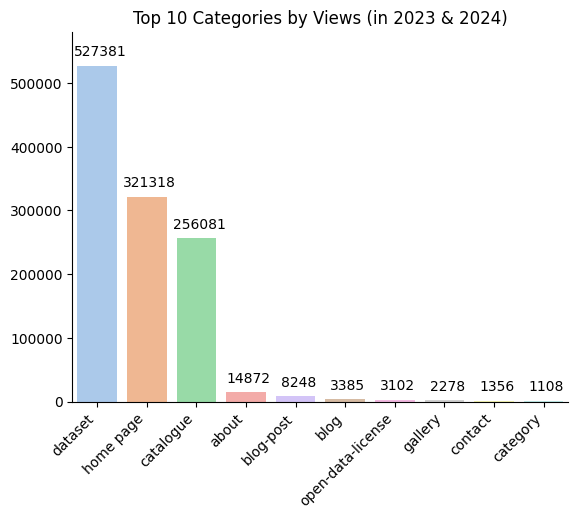

In [213]:
top_10_categories_by_views = (page_views_df
                                .query("Year == 2023 or Year == 2024")[['Category', 'Views']]
                                .groupby('Category')
                                .sum('Views')
                                .sort_values('Views', ascending=False)
                                [:10]
                            )

ax = sns.barplot(data=top_10_categories_by_views,
            x='Category', 
            y='Views',
            hue='Category',
            palette='pastel')

# Adding labels to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                xy=(p.get_x() + p.get_width()/2, p.get_height()),
                xytext=(2, 5),  # 1 point horizontal offset & 5 points vertical offset
                textcoords='offset points',
                ha='center', va='bottom')  # Horizontal and vertical alignment


# Decrease the scale of the y-axis
plt.ylim(0, top_10_categories_by_views['Views'].max() * 1.1)  # We can adjust the multiplier as needed

plt.xticks(rotation=45, ha='right')  # Rotate labels by 45 degrees and align them to the right
plt.title('Top 10 Categories by Views (in 2023 & 2024)')

# removing the x and y label since the title is self-explanatory
plt.xlabel('')
plt.ylabel('')

sns.despine() # removing the side borders

### Top 10: Category by Views (2023)

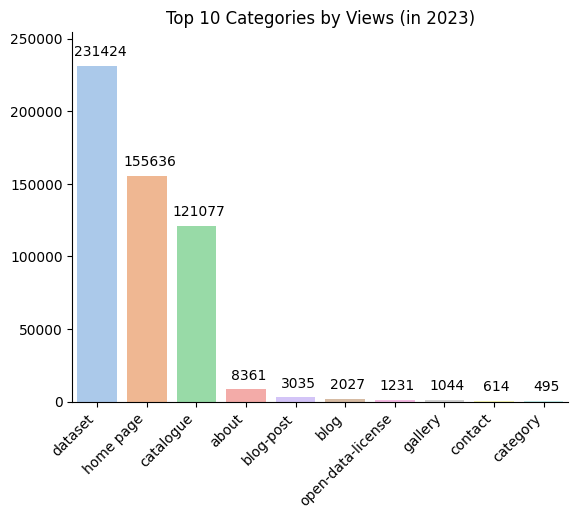

In [205]:
top_10_categories_by_views_2023 = (page_views_df
                                    .query("Year == 2023")[['Category', 'Views']]
                                    .groupby('Category')
                                    .sum('Views')
                                    .sort_values('Views', ascending=False)[:10]
                                   )

# plotting the bar-plot
ax = sns.barplot(data=top_10_categories_by_views_2023,
            x='Category', 
            y='Views',
            hue='Category',
            palette='pastel')

# Adding labels to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                xy=(p.get_x() + p.get_width()/2, p.get_height()),
                xytext=(2, 5),  # 1 point horizontal offset & 5 points vertical offset
                textcoords='offset points',
                ha='center', va='bottom')  # Horizontal and vertical alignment


# Decrease the scale of the y-axis
plt.ylim(0, top_10_categories_by_views_2023['Views'].max() * 1.1)  # We can adjust the multiplier as needed

plt.xticks(rotation=45, ha='right')  # Rotate labels by 45 degrees and align them to the right
plt.title('Top 10 Categories by Views (in 2023)')

# removing the x and y label since the title is self-explanatory
plt.xlabel('')
plt.ylabel('')

sns.despine()

### Top 10: Category by Views (2024)

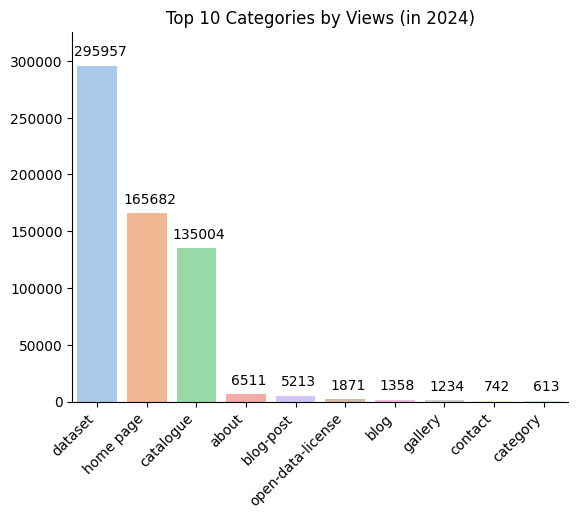

In [214]:
top_10_categories_by_views_2024 = (page_views_df
                                    .query("Year == 2024")[['Category', 'Views']]
                                    .groupby('Category')
                                    .sum('Views')
                                    .sort_values('Views', ascending=False)[:10]
                                   )

# plotting the bar-plot
ax = sns.barplot(data=top_10_categories_by_views_2024,
            x='Category', 
            y='Views',
            hue='Category',
            palette='pastel')

# Adding labels to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                xy=(p.get_x() + p.get_width()/2, p.get_height()),
                xytext=(2, 5),  # 1 point horizontal offset & 5 points vertical offset
                textcoords='offset points',
                ha='center', va='bottom')  # Horizontal and vertical alignment


# Decrease the scale of the y-axis
plt.ylim(0, top_10_categories_by_views_2024['Views'].max() * 1.1)  # We can adjust the multiplier as needed

plt.xticks(rotation=45, ha='right')  # Rotate labels by 45 degrees and align them to the right
plt.title('Top 10 Categories by Views (in 2024)')

# removing the x and y label since the title is self-explanatory
plt.xlabel('')
plt.ylabel('')

sns.despine()

### Top 10: Category by Sessions (2023 & 2024)

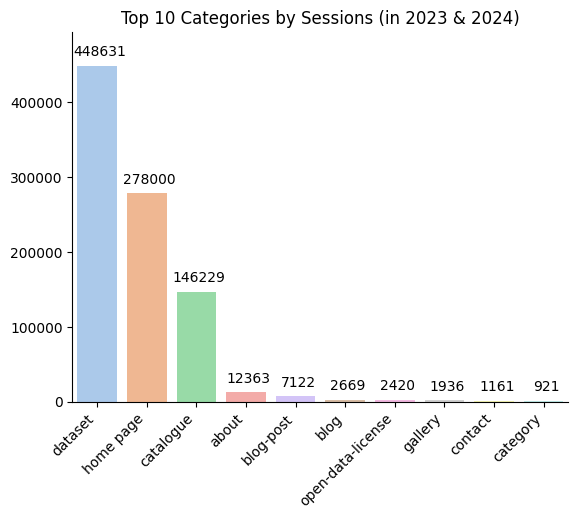

In [215]:
top_10_categories_by_sessions = page_views_df.query("Year == 2023 or Year == 2024")[['Category', 'Sessions']].groupby('Category').sum('Sessions').sort_values('Sessions', ascending=False)[:10]

ax = sns.barplot(data=top_10_categories_by_sessions,
            x='Category', 
            y='Sessions',
            hue='Category',
            palette='pastel')

# Adding labels to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                xy=(p.get_x() + p.get_width()/2, p.get_height()),
                xytext=(2, 5),  # 1 point horizontal offset & 5 points vertical offset
                textcoords='offset points',
                ha='center', va='bottom')  # Horizontal and vertical alignment

# Decrease the scale of the y-axis
plt.ylim(0, top_10_categories_by_sessions['Sessions'].max() * 1.1)  # We can adjust the multiplier as needed

plt.xticks(rotation=45, ha='right')  # Rotate labels by 45 degrees and align them to the right
plt.title('Top 10 Categories by Sessions (in 2023 & 2024)')

# removing the x and y label since the title is self-explanatory
plt.xlabel('')
plt.ylabel('')

sns.despine() # removing the side borders

### Top 10: Category by Sessions (2023)

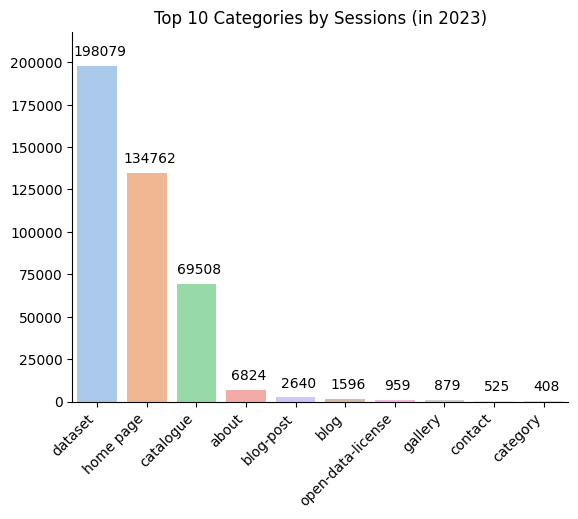

In [216]:
top_10_categories_by_sessions_2023 = (page_views_df
                                    .query("Year == 2023")[['Category', 'Sessions']]
                                    .groupby('Category')
                                    .sum('Sessions')
                                    .sort_values('Sessions', ascending=False)
                                    [:10]
                                 )

ax = sns.barplot(data=top_10_categories_by_sessions_2023,
            x='Category', 
            y='Sessions',
            hue='Category',
            palette='pastel')

# Adding labels to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                xy=(p.get_x() + p.get_width()/2, p.get_height()),
                xytext=(2, 5),  # 1 point horizontal offset & 5 points vertical offset
                textcoords='offset points',
                ha='center', va='bottom')  # Horizontal and vertical alignment

# Decrease the scale of the y-axis
plt.ylim(0, top_10_categories_by_sessions_2023['Sessions'].max() * 1.1)  # We can adjust the multiplier as needed

plt.xticks(rotation=45, ha='right')  # Rotate labels by 45 degrees and align them to the right
plt.title('Top 10 Categories by Sessions (in 2023)')

# removing the x and y label since the title is self-explanatory
plt.xlabel('')
plt.ylabel('')

sns.despine() # removing the side borders

### Top 10: Category by Sessions (2024)

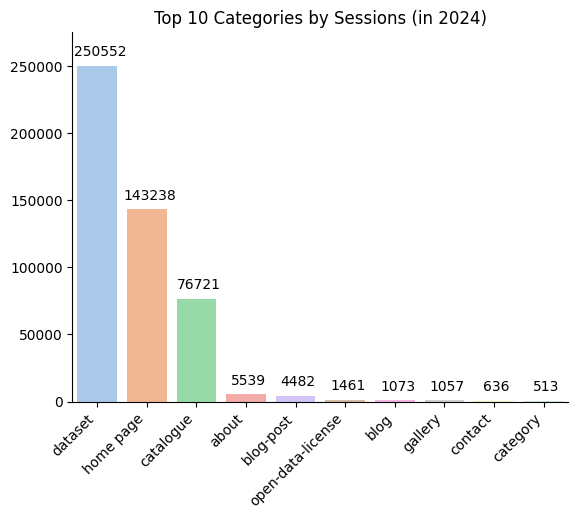

In [217]:
top_10_categories_by_sessions_2024 = (page_views_df
                                    .query("Year == 2024")[['Category', 'Sessions']]
                                    .groupby('Category')
                                    .sum('Sessions')
                                    .sort_values('Sessions', ascending=False)
                                    [:10]
                                 )

ax = sns.barplot(data=top_10_categories_by_sessions_2024,
            x='Category', 
            y='Sessions',
            hue='Category',
            palette='pastel')

# Adding labels to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                xy=(p.get_x() + p.get_width()/2, p.get_height()),
                xytext=(2, 5),  # 1 point horizontal offset & 5 points vertical offset
                textcoords='offset points',
                ha='center', va='bottom')  # Horizontal and vertical alignment

# Decrease the scale of the y-axis
plt.ylim(0, top_10_categories_by_sessions_2024['Sessions'].max() * 1.1)  # We can adjust the multiplier as needed

plt.xticks(rotation=45, ha='right')  # Rotate labels by 45 degrees and align them to the right
plt.title('Top 10 Categories by Sessions (in 2024)')

# removing the x and y label since the title is self-explanatory
plt.xlabel('')
plt.ylabel('')

sns.despine() # removing the side borders

## Top Datasets (User-Ship Metrics)
From 'page views over time.csv'

### Top 10: Datasets by Sessions (of All Time)

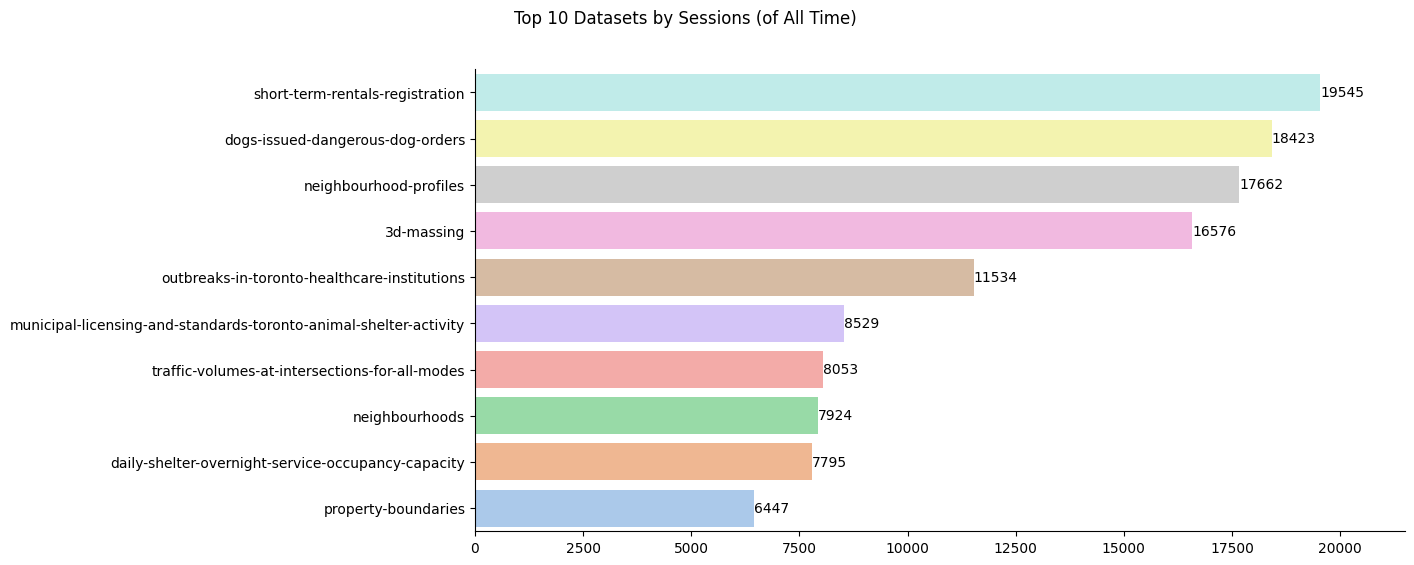

In [218]:
# datasets with most number of sessions

top_10_datasets_by_sessions = (page_views_df[['Category', 'Category Details 1', 'Sessions']]
                                .query('Category == "dataset"')
                                .groupby(['Category', 'Category Details 1'])
                                .sum('Sessions')
                                .sort_values('Sessions', ascending=False)
                                [:10]
                                )

plt.figure(figsize=(12, 6))  # Wider figure

ax = sns.barplot(data=top_10_datasets_by_sessions, 
            x='Sessions',
            y='Category Details 1',
            hue='Sessions',
            palette='pastel',
            legend=False)

# Adding labels to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='left', va='center')
    
# Decrease the scale of the x-axis - so that the labels do not go outside the graph
plt.xlim(0, top_10_datasets_by_sessions['Sessions'].max() * 1.1)  # Adjust the multiplier as needed

# Use suptitle to center the title above the plot
plt.suptitle('Top 10 Datasets by Sessions (of All Time)', x=0.3)

# removing the x and y label since the title is self-explanatory
plt.xlabel('')
plt.ylabel('')

sns.despine() # removing the side borders

### Top 10: Datasets by Sessions (2023 & 2024)

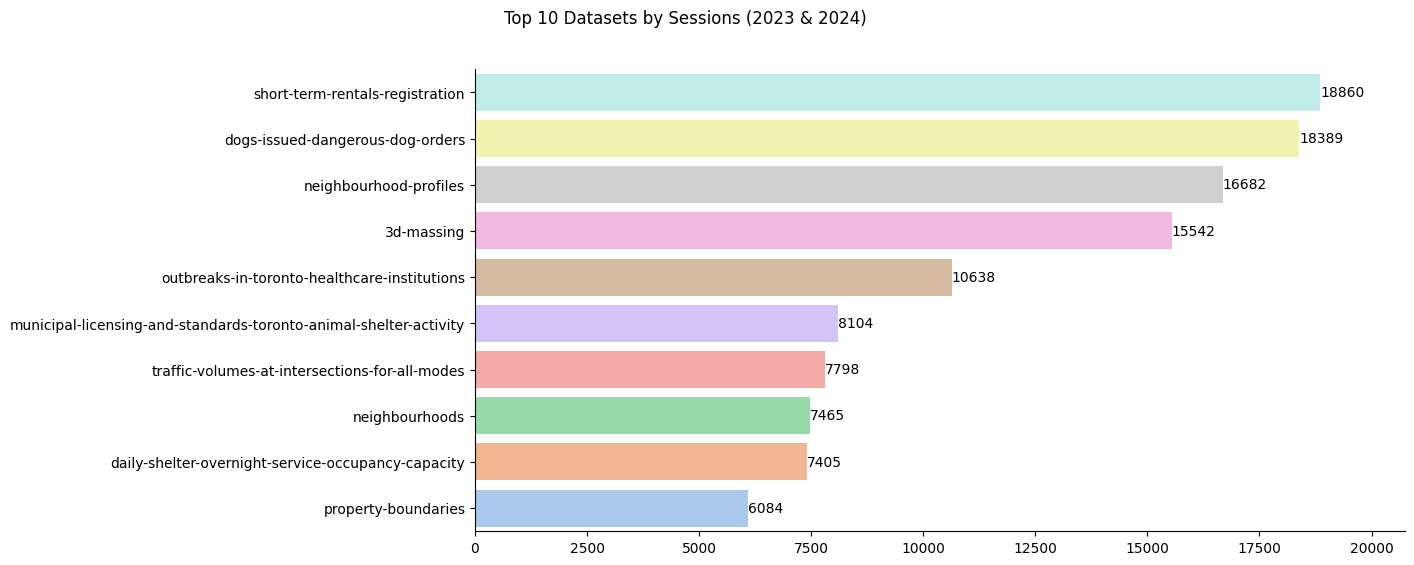

In [220]:
# datasets with most number of sessions

top_10_datasets_by_sessions_2023_2024 = (page_views_df
                                .query('Category == "dataset" and (Year == 2023 or Year == 2024)')
                                [['Category', 'Category Details 1', 'Sessions']]
                                .groupby(['Category', 'Category Details 1'])
                                .sum('Sessions')
                                .sort_values('Sessions', ascending=False)
                                [:10]
                                )

plt.figure(figsize=(12, 6))  # Wider figure

ax = sns.barplot(data=top_10_datasets_by_sessions_2023_2024, 
            x='Sessions',
            y='Category Details 1',
            hue='Sessions',
            palette='pastel',
            legend=False)

# Adding labels to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='left', va='center')
    
# Decrease the scale of the x-axis - so that the labels do not go outside the graph
plt.xlim(0, top_10_datasets_by_sessions_2023_2024['Sessions'].max() * 1.1)  # Adjust the multiplier as needed

# Use suptitle to center the title above the plot
plt.suptitle('Top 10 Datasets by Sessions (2023 & 2024)', x=0.3)

# removing the x and y label since the title is self-explanatory
plt.xlabel('')
plt.ylabel('')

sns.despine() # removing the side borders

### Top 10: Datasets by Sessions (2023)

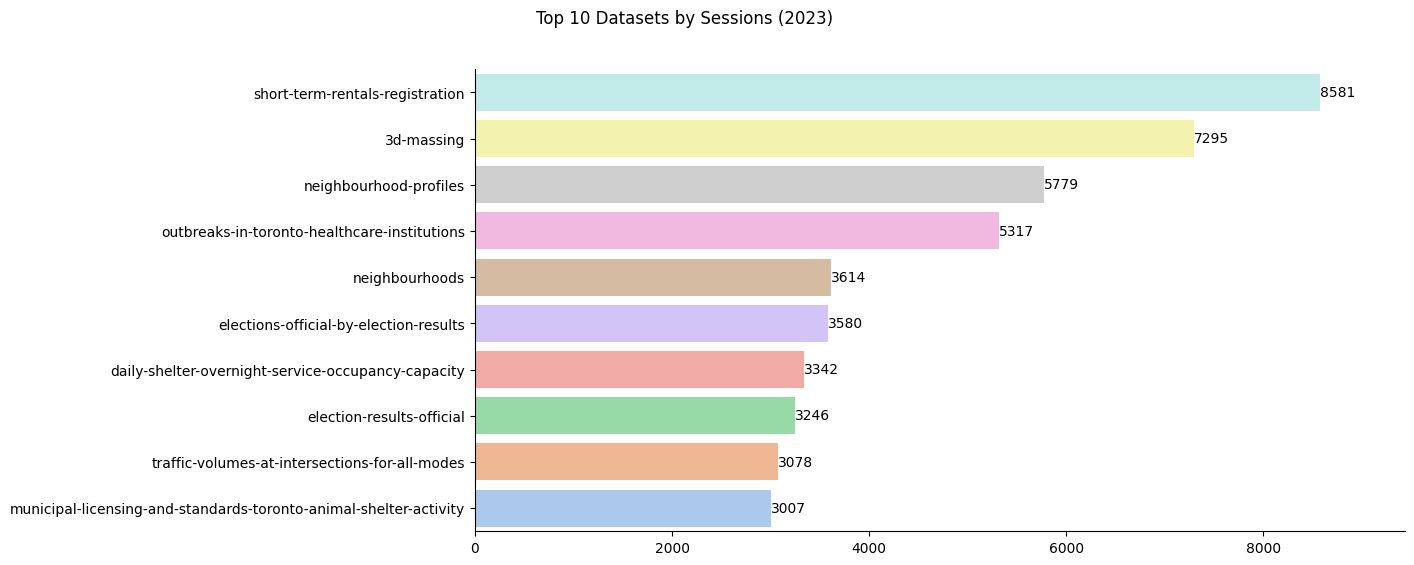

In [223]:
# datasets with most number of sessions

top_10_datasets_by_sessions_2023 = (page_views_df
                                .query('Category == "dataset" and Year == 2023')
                                [['Category', 'Category Details 1', 'Sessions']]
                                .groupby(['Category', 'Category Details 1'])
                                .sum('Sessions')
                                .sort_values('Sessions', ascending=False)
                                [:10]
                                )

plt.figure(figsize=(12, 6))  # Wider figure

ax = sns.barplot(data=top_10_datasets_by_sessions_2023, 
            x='Sessions',
            y='Category Details 1',
            hue='Sessions',
            palette='pastel',
            legend=False)

# Adding labels to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='left', va='center')
    
# Decrease the scale of the x-axis - so that the labels do not go outside the graph
plt.xlim(0, top_10_datasets_by_sessions_2023['Sessions'].max() * 1.1)  # Adjust the multiplier as needed

# Use suptitle to center the title above the plot
plt.suptitle('Top 10 Datasets by Sessions (2023)', x=0.3)

# removing the x and y label since the title is self-explanatory
plt.xlabel('')
plt.ylabel('')

sns.despine() # removing the side borders

### Top 10: Datasets by Sessions (2024)

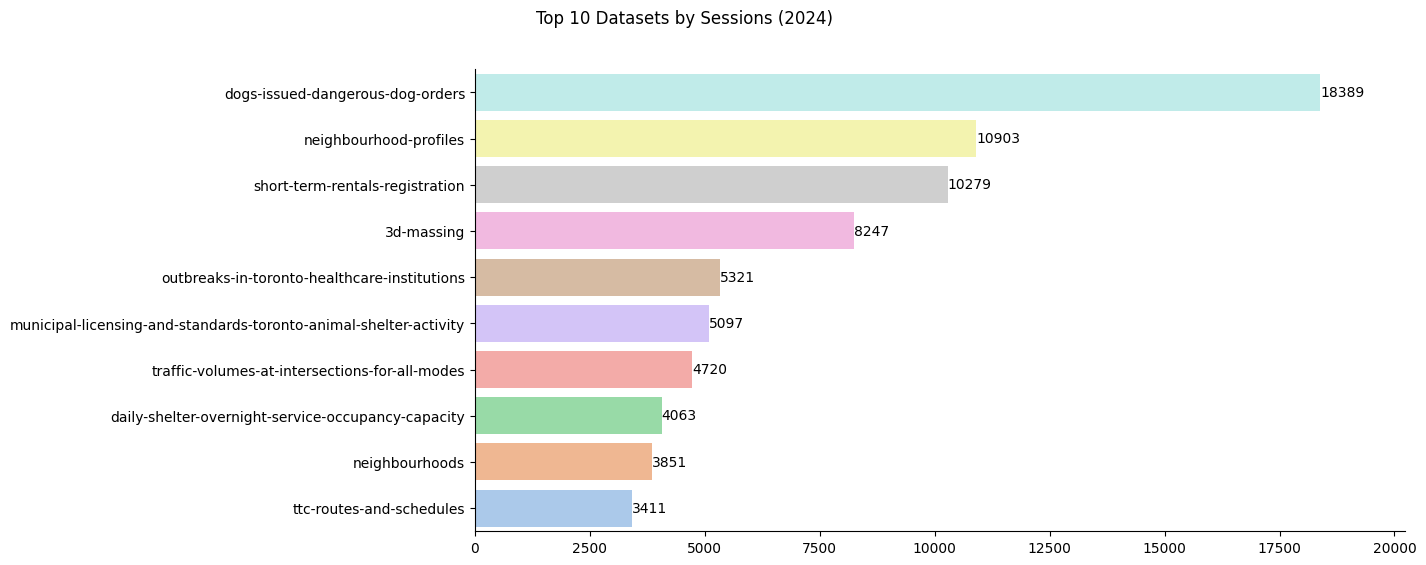

In [224]:
# datasets with most number of sessions

top_10_datasets_by_sessions_2024 = (page_views_df
                                .query('Category == "dataset" and Year == 2024')
                                [['Category', 'Category Details 1', 'Sessions']]
                                .groupby(['Category', 'Category Details 1'])
                                .sum('Sessions')
                                .sort_values('Sessions', ascending=False)
                                [:10]
                                )

plt.figure(figsize=(12, 6))  # Wider figure

ax = sns.barplot(data=top_10_datasets_by_sessions_2024, 
            x='Sessions',
            y='Category Details 1',
            hue='Sessions',
            palette='pastel',
            legend=False)

# Adding labels to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='left', va='center')
    
# Decrease the scale of the x-axis - so that the labels do not go outside the graph
plt.xlim(0, top_10_datasets_by_sessions_2024['Sessions'].max() * 1.1)  # Adjust the multiplier as needed

# Use suptitle to center the title above the plot
plt.suptitle('Top 10 Datasets by Sessions (2024)', x=0.3)

# removing the x and y label since the title is self-explanatory
plt.xlabel('')
plt.ylabel('')

sns.despine() # removing the side borders

### Top 10: Datasets by Views (2023 & 2024)

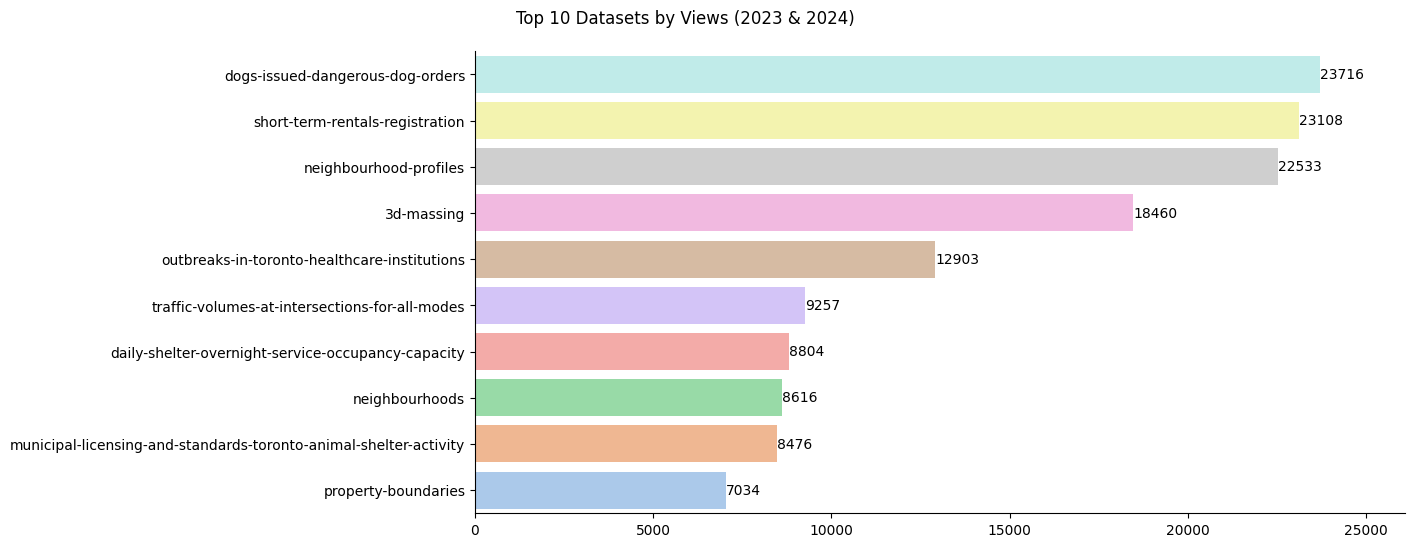

In [231]:
# datasets with most number of views in 2023 & 2024

top_10_datasets_by_views_2023_2024 = (page_views_df
                                .query('Category == "dataset" and (Year == 2023 or Year == 2024)')
                                [['Category', 'Category Details 1', 'Views']]
                                .groupby(['Category', 'Category Details 1'])
                                .sum('Views')
                                .sort_values('Views', ascending=False)
                                [:10]
                                )

plt.figure(figsize=(12, 6))  # Wider figure

ax = sns.barplot(data=top_10_datasets_by_views_2023_2024, 
            x='Views',
            y='Category Details 1',
            hue='Views',
            palette='pastel',
            legend=False)

# Adding labels to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='left', va='center')
    
# Decrease the scale of the x-axis - so that the labels do not go outside the graph
plt.xlim(0, top_10_datasets_by_views_2023_2024['Views'].max() * 1.1)  # Adjust the multiplier as needed

# plt.title('Top 10 Datasets by Views (2023 & 2024)')
# Use suptitle to center the title above the plot
plt.suptitle('Top 10 Datasets by Views (2023 & 2024)', x=0.3, y=0.95)

# removing the x and y label since the title is self-explanatory
plt.xlabel('')
plt.ylabel('')

sns.despine() # removing the side borders

### Top 10: Datasets by Views (2023)

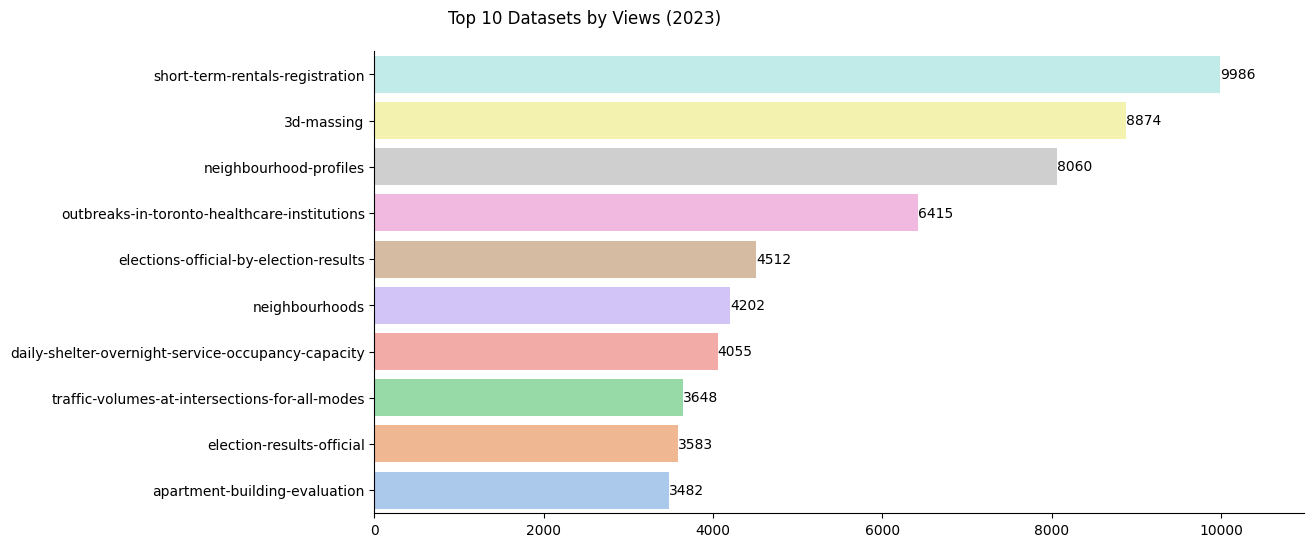

In [232]:
# datasets with most number of views in 2023

top_10_datasets_by_views_2023 = (page_views_df
                                .query('Category == "dataset" and Year == 2023')
                                [['Category', 'Category Details 1', 'Views']]
                                .groupby(['Category', 'Category Details 1'])
                                .sum('Views')
                                .sort_values('Views', ascending=False)
                                [:10]
                                )

plt.figure(figsize=(12, 6))  # Wider figure

ax = sns.barplot(data=top_10_datasets_by_views_2023, 
            x='Views',
            y='Category Details 1',
            hue='Views',
            palette='pastel',
            legend=False)

# Adding labels to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='left', va='center')
    
# Decrease the scale of the x-axis - so that the labels do not go outside the graph
plt.xlim(0, top_10_datasets_by_views_2023['Views'].max() * 1.1)  # Adjust the multiplier as needed

# Use suptitle to center the title above the plot
plt.suptitle('Top 10 Datasets by Views (2023)', x=0.3, y=0.95)

# removing the x and y label since the title is self-explanatory
plt.xlabel('')
plt.ylabel('')

sns.despine() # removing the side borders

### Top 10: Datasets by Views (2024)

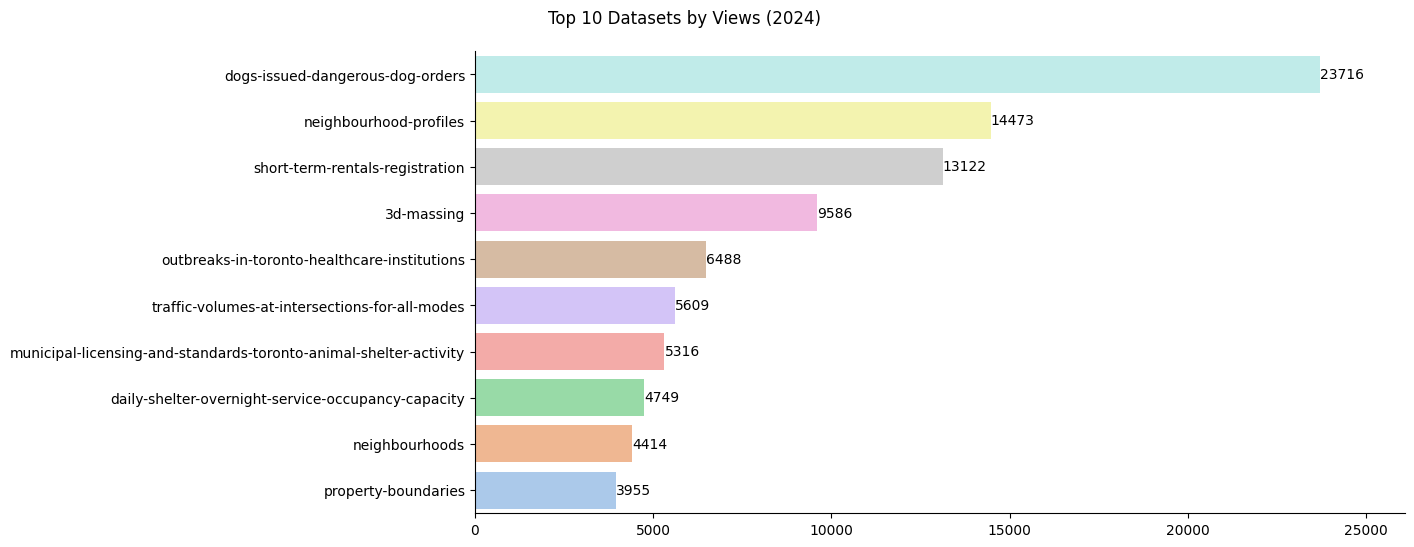

In [233]:
# datasets with most number of views in 2024

top_10_datasets_by_views_2024 = (page_views_df
                                .query('Category == "dataset" and Year == 2024')
                                [['Category', 'Category Details 1', 'Views']]
                                .groupby(['Category', 'Category Details 1'])
                                .sum('Views')
                                .sort_values('Views', ascending=False)
                                [:10]
                                )

plt.figure(figsize=(12, 6))  # Wider figure

ax = sns.barplot(data=top_10_datasets_by_views_2024, 
            x='Views',
            y='Category Details 1',
            hue='Views',
            palette='pastel',
            legend=False)

# Adding labels to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='left', va='center')
    
# Decrease the scale of the x-axis - so that the labels do not go outside the graph
plt.xlim(0, top_10_datasets_by_views_2024['Views'].max() * 1.1)  # Adjust the multiplier as needed

# Use suptitle to center the title above the plot
plt.suptitle('Top 10 Datasets by Views (2024)', x=0.3, y=0.95)

# removing the x and y label since the title is self-explanatory
plt.xlabel('')
plt.ylabel('')

sns.despine() # removing the side borders

### Top Datasets Over Time

In [234]:
datasets = page_views_df.query("Category == 'dataset'")

datasets_2023 = datasets.query("Year == 2023")
datasets_2024 = datasets.query("Year == 2024")

In [235]:
datasets_2023_sessions_by_month = datasets_2023.groupby(["Month", "Year"])['Sessions'].sum().reset_index()

datasets_2023_sessions_by_month["Month Name"] = datasets_2023_sessions_by_month["Month"].apply(lambda x: calendar.month_name[x])

# Sort by Month number
datasets_2023_sessions_by_month = datasets_2023_sessions_by_month.sort_values('Month')

In [236]:
datasets_2023_sessions_by_month[["Month Name", "Year", "Sessions"]]

Month Name  Year  Sessions
0     January  2023     15076
1    February  2023     15457
2       March  2023     22192
3       April  2023     15104
4         May  2023     12535
5        June  2023     16546
6        July  2023     14298
7      August  2023     12341
8   September  2023     17474
9     October  2023     21000
10   November  2023     22981
11   December  2023     13075

In [237]:
# similarly for 2024:

datasets_2024_sessions_by_month = datasets_2024.groupby(["Month", "Year"])['Sessions'].sum().reset_index()

datasets_2024_sessions_by_month["Month Name"] = datasets_2024_sessions_by_month["Month"].apply(lambda x: calendar.month_name[x])

# Sort by Month number
datasets_2024_sessions_by_month = datasets_2024_sessions_by_month.sort_values('Month')

datasets_2024_sessions_by_month[["Month Name", "Year", "Sessions"]]

Month Name  Year  Sessions
0     January  2024     22476
1    February  2024     18636
2       March  2024     24226
3       April  2024     32304
4         May  2024     16178
5        June  2024     16880
6        July  2024     15215
7      August  2024     12366
8   September  2024     25738
9     October  2024     23995
10   November  2024     28418
11   December  2024     14120

In [238]:
# Let's compare the 2023 and 2024 sessions by month:
comparison_df = pd.DataFrame({
    'Month': datasets_2023_sessions_by_month['Month Name'],
    '2023_Sessions': datasets_2023_sessions_by_month['Sessions'],
    '2024_Sessions': datasets_2024_sessions_by_month['Sessions']
})

comparison_df

Month  2023_Sessions  2024_Sessions
0     January          15076          22476
1    February          15457          18636
2       March          22192          24226
3       April          15104          32304
4         May          12535          16178
5        June          16546          16880
6        July          14298          15215
7      August          12341          12366
8   September          17474          25738
9     October          21000          23995
10   November          22981          28418
11   December          13075          14120

In [242]:
# Calculate percentage change
comparison_df['Percentage_Change'] = ((comparison_df['2024_Sessions'] - comparison_df['2023_Sessions']) / 
                                    comparison_df['2023_Sessions'] * 100)

# Format percentage with 2 decimal places
comparison_df['Percentage_Change'] = comparison_df['Percentage_Change'].round(2)

# Add % symbol
comparison_df['Percentage_Change'] = comparison_df['Percentage_Change'].astype(str) + '%'

# Display the results
print("Month-over-Month Sessions Comparison (2023 vs 2024):\n")
print(comparison_df)

Month-over-Month Sessions Comparison (2023 vs 2024):

        Month  2023_Sessions  2024_Sessions Percentage_Change
0     January          15076          22476            49.08%
1    February          15457          18636            20.57%
2       March          22192          24226             9.17%
3       April          15104          32304           113.88%
4         May          12535          16178            29.06%
5        June          16546          16880             2.02%
6        July          14298          15215             6.41%
7      August          12341          12366              0.2%
8   September          17474          25738            47.29%
9     October          21000          23995            14.26%
10   November          22981          28418            23.66%
11   December          13075          14120             7.99%


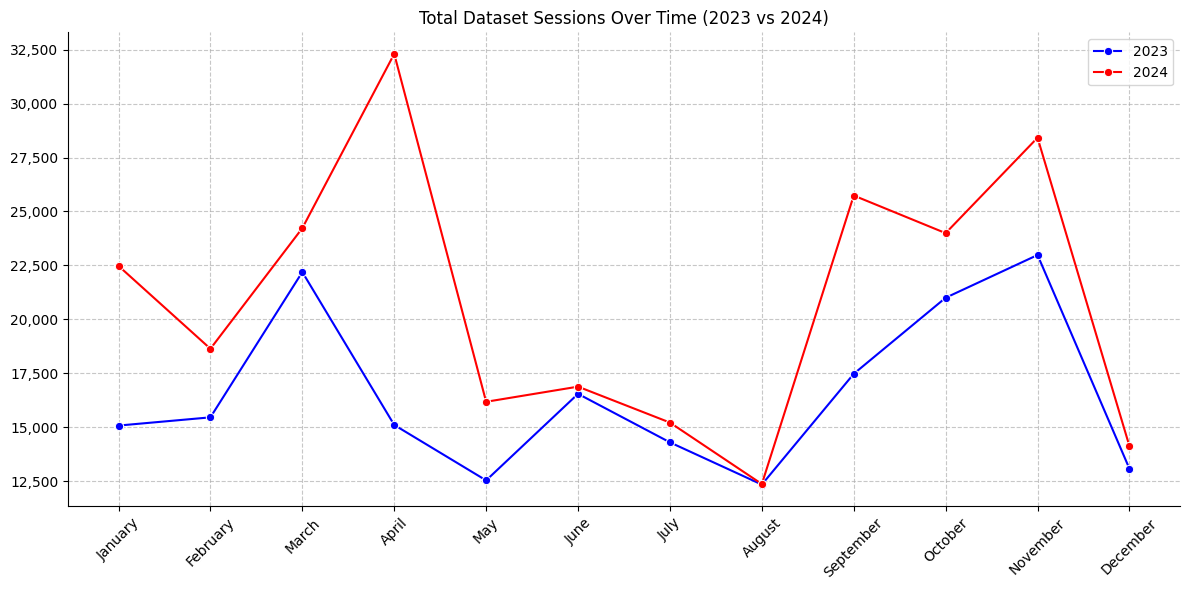

In [247]:
# Create the plot
plt.figure(figsize=(12, 6))

# Plot 2023 data
sns.lineplot(data=datasets_2023_sessions_by_month, 
            x='Month Name', 
            y='Sessions', 
            marker='o',
            label='2023',
            color='blue')

# Plot 2024 data
sns.lineplot(data=datasets_2024_sessions_by_month, 
            x='Month Name', 
            y='Sessions', 
            marker='o',
            label='2024',
            color='red')

# Customize the plot
plt.title('Total Dataset Sessions Over Time (2023 vs 2024)', fontsize=12)
plt.xlabel('')
plt.ylabel('')
plt.grid(True, linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add comma separator for large numbers on y-axis
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Add legend
plt.legend()

# Adjust layout to prevent label cutoff
plt.tight_layout()

sns.despine() # removing the side borders
plt.show()

In [105]:
datasets_2024.groupby(["Month", "Year"])['Sessions'].sum()

Month  Year
1      2024    22476
2      2024    18636
3      2024    24226
4      2024    32304
5      2024    16178
6      2024    16880
7      2024    15215
8      2024    12366
9      2024    25738
10     2024    23995
11     2024    28418
12     2024    14120
Name: Sessions, dtype: int64

In [106]:
# Group by dataset name, month and year
dataset_sessions_2023 = datasets_2023.groupby(['name', 'Month', 'Year'])['Sessions'].sum().reset_index()

# Add month name for better readability
dataset_sessions_2023['Month Name'] = dataset_sessions_2023['Month'].apply(lambda x: calendar.month_name[x])

# Find top 5 datasets by total sessions
top_5_datasets_2023 = dataset_sessions_2023.groupby('name')['Sessions'].sum().sort_values(ascending=False).head(5).index

top_5_datasets_2023

Index(['short-term-rentals-registration', '3d-massing',
       'neighbourhood-profiles',
       'outbreaks-in-toronto-healthcare-institutions', 'neighbourhoods'],
      dtype='object', name='name')

In [107]:
# Group by dataset name, month and year
dataset_sessions = datasets_2024.groupby(['name', 'Month', 'Year'])['Sessions'].sum().reset_index()

# Add month name for better readability
dataset_sessions['Month Name'] = dataset_sessions['Month'].apply(lambda x: calendar.month_name[x])

# Find top 5 datasets by total sessions
top_5_datasets_2024 = dataset_sessions.groupby('name')['Sessions'].sum().sort_values(ascending=False).head(5).index

top_5_datasets_2024

Index(['dogs-issued-dangerous-dog-orders', 'neighbourhood-profiles',
       'short-term-rentals-registration', '3d-massing',
       'outbreaks-in-toronto-healthcare-institutions'],
      dtype='object', name='name')

In [ ]:
# Create the plot
# import matplotlib.pyplot as plt
# import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=datasets_2023, x='Month Name', y='Sessions', marker='o')

# Customize the plot
plt.title('Total Sessions by Month (2023)', fontsize=12)
plt.xlabel('Month')
plt.ylabel('Total Sessions')
plt.grid(True, linestyle='--')


# Add comma separator for large numbers on y-axis
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

## Word Cloud on Search Terms (2023)

In [158]:
from wordcloud import WordCloud

In [159]:
search_terms_df

Search Term -Generic (search=)       Date  Views  Day  Month  Year  \
1                          elections 2023-06-27   1182   27      6  2023   
2                          elections 2023-06-26   1038   26      6  2023   
3                          elections 2023-06-28    211   28      6  2023   
4                          elections 2024-11-04     99    4     11  2024   
5                          elections 2023-06-29     97   29      6  2023   
...                              ...        ...    ...  ...    ...   ...   
56322              ambulance station 2024-10-03      1    3     10  2024   
56323              ambulance station 2025-01-11      1   11      1  2025   
56324              ambulance station 2024-12-02      1    2     12  2024   
56325              ambulance station 2023-10-30      1   30     10  2023   
56326              ambulance station 2024-11-18      1   18     11  2024   

        Day_Name  
1        Tuesday  
2         Monday  
3      Wednesday  
4         Monday  
5       Thursday  
...          ...  
56322   Thursday  
56323   Saturday  
56324     Monday  
56325     Monday  
56326     Monday  

[55326 rows x 7 columns]

In [180]:
search_terms_2023 = search_terms_df.query("Year == 2023")
total_search_term_by_views_2023 = (search_terms_2023
                                    .groupby('Search Term -Generic (search=)')['Views']
                                    .sum().reset_index()
                                    .sort_values('Views', ascending=False)
                                )

# Replace NaN values in the 'Search Term -Generic (search=)' column with "No String"
total_search_term_by_views_2023['Search Term -Generic (search=)'] = total_search_term_by_views_2023['Search Term -Generic (search=)'].fillna('No Search Term')

print("First 5 rows of the search term data:")
print(total_search_term_by_views_2023.head())

First 5 rows of the search term data:
    Search Term -Generic (search=)  Views
288                      elections   4218
862                            ttc   1322
13                      3d massing   1199
508                  neighbourhood   1046
403                        housing   1024


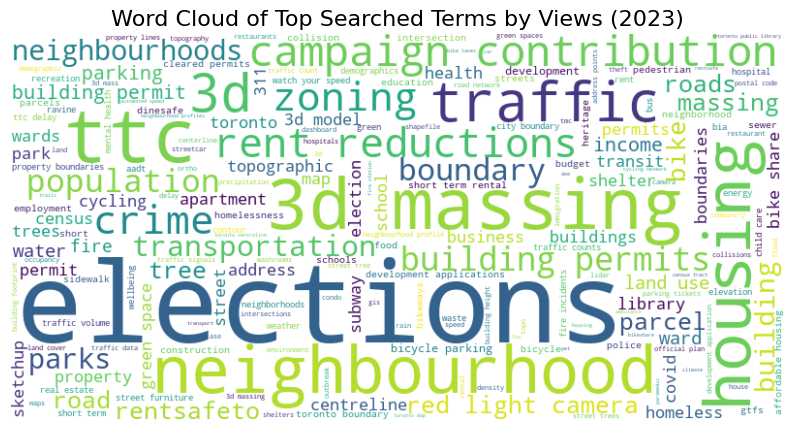

In [182]:
# Create a dictionary of search terms and their corresponding views
word_freq_2023 = dict(zip(total_search_term_by_views_2023['Search Term -Generic (search=)'], total_search_term_by_views_2023['Views']))

# Generate the word cloud
wordcloud_2023 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_2023)

# Display the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_2023, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Word Cloud of Top Searched Terms by Views (2023)', fontsize=16)
plt.show()

## Word Cloud on Search Terms in 2024

In [183]:
search_terms_2024 = search_terms_df.query("Year == 2024")
total_search_term_by_views_2024 = (search_terms_2024
                                    .groupby('Search Term -Generic (search=)')['Views']
                                    .sum().reset_index()
                                    .sort_values('Views', ascending=False)
                                )

# Replace NaN values in the 'Search Term -Generic (search=)' column with "No String"
total_search_term_by_views_2024['Search Term -Generic (search=)'] = total_search_term_by_views_2024['Search Term -Generic (search=)'].fillna('No Search Term')

print("First 5 rows of the search term data:")
print(total_search_term_by_views_2024.head())

First 5 rows of the search term data:
    Search Term -Generic (search=)  Views
906                            ttc   1450
420                        housing   1151
871                        traffic    903
16                      3d massing    898
300                      elections    833


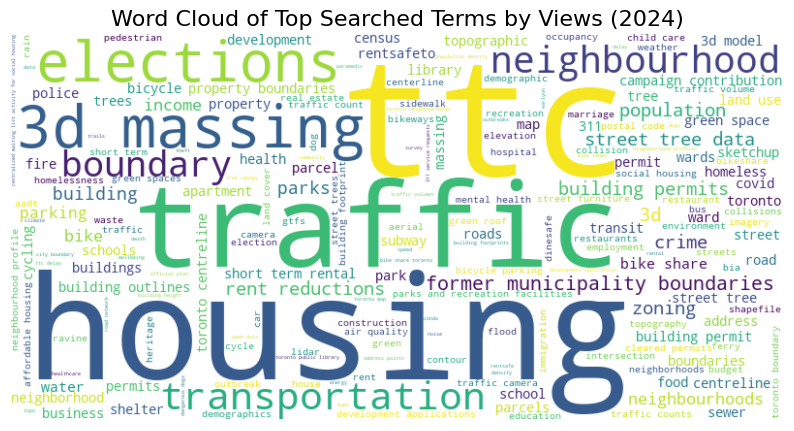

In [184]:
# Create a dictionary of search terms and their corresponding views
word_freq_2024 = dict(zip(total_search_term_by_views_2024['Search Term -Generic (search=)'], total_search_term_by_views_2024['Views']))

# Generate the word cloud
wordcloud_2024 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_2024)

# Display the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_2024, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title('Word Cloud of Top Searched Terms by Views (2024)', fontsize=16)
plt.show()

In [195]:
# Calculate total frequency
total_freq = sum(word_freq_2023.values())

# Calculate percentage contribution for each term
percentages = {term: (freq/total_freq)*100 for term, freq in word_freq_2023.items()}

# Sort percentages by value in descending order
sorted_percentages = dict(sorted(percentages.items(), key=lambda x: x[1], reverse=True))

# Display top terms with their percentages (showing top 10)
print("Top search terms by percentage contribution in 2023:")
print("\nTerm | Frequency | Percentage")
print("-" * 40)
for term, pct in list(sorted_percentages.items())[:10]:
    freq = word_freq_2023[term]
    print(f"{term}: {freq:,} ({pct:.2f}%)")

Top search terms by percentage contribution in 2023:

Term | Frequency | Percentage
----------------------------------------
elections: 4,218 (8.91%)
ttc: 1,322 (2.79%)
3d massing: 1,199 (2.53%)
neighbourhood: 1,046 (2.21%)
housing: 1,024 (2.16%)
traffic: 749 (1.58%)
3d: 672 (1.42%)
campaign contribution: 670 (1.42%)
rent reductions: 614 (1.30%)
crime: 587 (1.24%)


In [193]:
# Calculate total frequency
total_freq = sum(word_freq_2024.values())

# Calculate percentage contribution for each term
percentages = {term: (freq/total_freq)*100 for term, freq in word_freq_2024.items()}

# Sort percentages by value in descending order
sorted_percentages = dict(sorted(percentages.items(), key=lambda x: x[1], reverse=True))

# Display top terms with their percentages (showing top 10)
print("Top search terms by percentage contribution in 2024:")
print("\nTerm | Frequency | Percentage")
print("-" * 40)
for term, pct in list(sorted_percentages.items())[:10]:
    freq = word_freq_2024[term]
    print(f"{term}: {freq:,} ({pct:.2f}%)")

Top search terms by percentage contribution in 2024:

Term | Frequency | Percentage
----------------------------------------
ttc: 1,450 (2.93%)
housing: 1,151 (2.33%)
traffic: 903 (1.83%)
3d massing: 898 (1.82%)
elections: 833 (1.69%)
transportation: 829 (1.68%)
neighbourhood: 744 (1.51%)
boundary: 717 (1.45%)
former municipality boundaries: 713 (1.44%)
street tree data: 632 (1.28%)


## Search Terms Frequency over Time (2023)

In [ ]:
search_terms_df["Month_Name"] = search_terms_df["Month"].apply(lambda x: calendar.month_name[x])

top_5_search_terms_2023 = (search_terms_df
                            .query("Year == 2023")
                            .groupby('Search Term -Generic (search=)', as_index=False)['Views']
                            .sum()
                            .sort_values('Views', ascending=False)
                            [:5]
                            ['Search Term -Generic (search=)'])

top_5_search_terms_monthly_2023 = (search_terms_df
                                    .query("Year == 2023")
                                    .groupby(['Month', 'Month_Name', 'Search Term -Generic (search=)'], as_index=False)['Views']
                                    .sum()
                                    .query("`Search Term -Generic (search=)` in @top_5_search_terms_2023")
                                    )

top_5_search_terms_monthly_2023

Month Month_Name Search Term -Generic (search=)  Views
6         1    January                     3d massing    225
164       1    January                      elections     33
228       1    January                        housing     30
289       1    January                  neighbourhood    303
507       1    January                            ttc    115
563       2   February                     3d massing    185
726       2   February                      elections    111
791       2   February                        housing     23
851       2   February                  neighbourhood     80
1069      2   February                            ttc    103
1127      3      March                     3d massing    112
1324      3      March                      elections     80
1404      3      March                        housing    131
1477      3      March                  neighbourhood    133
1712      3      March                            ttc    160
1776      4      April                     3d massing     99
1942      4      April                      elections     86
2012      4      April                        housing     69
2069      4      April                  neighbourhood     63
2281      4      April                            ttc    111
2343      5        May                     3d massing     78
2507      5        May                      elections     75
2567      5        May                        housing     92
2622      5        May                  neighbourhood     36
2804      5        May                            ttc     80
2856      6       June                     3d massing     37
3011      6       June                      elections   2888
3068      6       June                        housing     73
3114      6       June                  neighbourhood     32
3304      6       June                            ttc     63
3356      7       July                     3d massing     41
3505      7       July                      elections    500
3568      7       July                        housing     82
3610      7       July                  neighbourhood     66
3788      7       July                            ttc     97
3834      8     August                     3d massing     50
3981      8     August                      elections    118
4036      8     August                        housing     75
4087      8     August                  neighbourhood     39
4267      8     August                            ttc     80
4317      9  September                     3d massing    153
4490      9  September                      elections    103
4564      9  September                        housing    107
4625      9  September                  neighbourhood     43
4837      9  September                            ttc    115
4900     10    October                     3d massing     96
5085     10    October                      elections     52
5148     10    October                        housing    126
5207     10    October                  neighbourhood     72
5420     10    October                            ttc    132
5484     11   November                     3d massing     86
5665     11   November                      elections     83
5742     11   November                        housing    136
5814     11   November                  neighbourhood    115
6057     11   November                            ttc    173
6121     12   December                     3d massing     37
6278     12   December                      elections     89
6336     12   December                        housing     80
6388     12   December                  neighbourhood     64
6573     12   December                            ttc     93

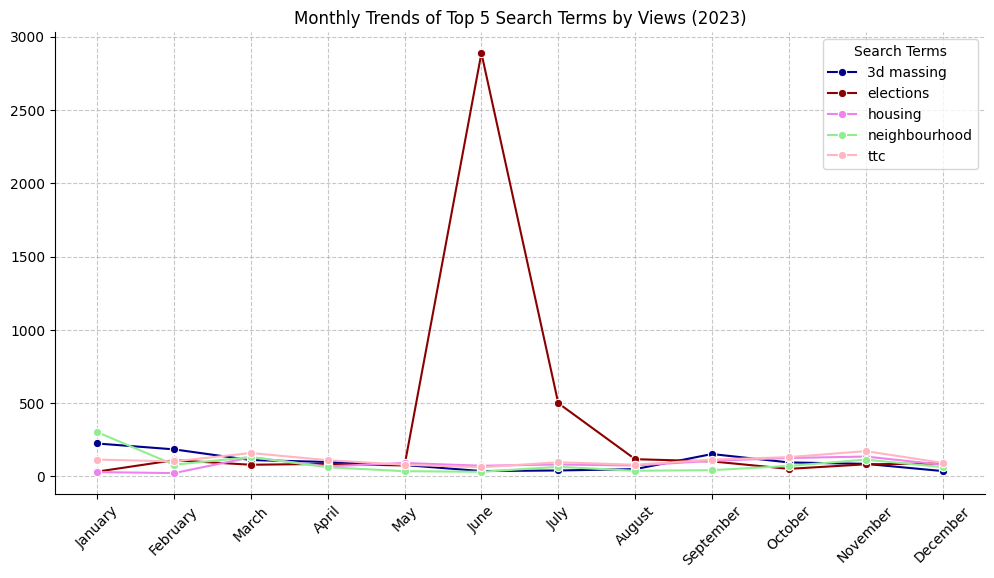

In [283]:
# Create palette with different light colors
light_colors = ['lightpink', 'lightgreen', 'violet'] 
custom_palette = {}
i = 0

for term in top_5_search_terms_2023:
    if term == 'elections':
        custom_palette[term] = 'darkred'  
    elif term == '3d massing':
        custom_palette[term] = 'darkblue'
    else:
        custom_palette[term] = light_colors[i]
        i += 1

plt.figure(figsize=(12, 6))
sns.lineplot(data=top_5_search_terms_monthly_2023, 
                x='Month_Name', 
                y='Views', 
                hue='Search Term -Generic (search=)', 
                marker='o',
                palette=custom_palette
                )

plt.xlabel("")
plt.ylabel("")
plt.title("Monthly Trends of Top 5 Search Terms by Views (2023)")
plt.legend(title="Search Terms")
plt.grid(True, linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

sns.despine()
plt.show()

## Search Terms Frequency over Time (2024)

In [288]:
top_5_search_terms_2024 = (search_terms_df
                            .query("Year == 2024")
                            .groupby('Search Term -Generic (search=)', as_index=False)['Views']
                            .sum()
                            .sort_values('Views', ascending=False)
                            [:5]
                            ['Search Term -Generic (search=)'])

print(top_5_search_terms_2024)

top_5_search_terms_monthly_2024 = (search_terms_df
                                    .query("Year == 2024")
                                    .groupby(['Month', 'Month_Name', 'Search Term -Generic (search=)'], as_index=False)['Views']
                                    .sum()
                                    .query("`Search Term -Generic (search=)` in @top_5_search_terms_2024")
                                    )

top_5_search_terms_monthly_2024

906           ttc
420       housing
871       traffic
16     3d massing
300     elections
Name: Search Term -Generic (search=), dtype: object


Month Month_Name Search Term -Generic (search=)  Views
9         1    January                     3d massing    140
192       1    January                      elections     30
265       1    January                        housing     98
548       1    January                        traffic     73
569       1    January                            ttc    174
638       2   February                     3d massing    129
815       2   February                      elections     33
889       2   February                        housing    124
1154      2   February                        traffic     53
1181      2   February                            ttc    148
1240      3      March                     3d massing     63
1444      3      March                      elections     25
1525      3      March                        housing    132
1813      3      March                        traffic    114
1836      3      March                            ttc    160
1900      4      April                     3d massing     49
2070      4      April                      elections     39
2145      4      April                        housing     56
2398      4      April                        traffic     70
2423      4      April                            ttc     94
2475      5        May                     3d massing     47
2648      5        May                      elections     27
2712      5        May                        housing     90
2937      5        May                        traffic     41
2962      5        May                            ttc     83
3013      6       June                     3d massing     43
3205      6       June                      elections    203
3277      6       June                        housing     92
3559      6       June                        traffic     67
3587      6       June                            ttc     94
3643      7       July                     3d massing     29
3790      7       July                      elections     96
3843      7       July                        housing     99
4070      7       July                        traffic     54
4091      7       July                            ttc     97
4141      8     August                     3d massing     37
4281      8     August                      elections     39
4336      8     August                        housing     52
4542      8     August                        traffic     40
4567      8     August                            ttc     77
4617      9  September                     3d massing    118
4823      9  September                      elections     41
4908      9  September                        housing     82
5204      9  September                        traffic     88
5233      9  September                            ttc    187
5304     10    October                     3d massing    108
5498     10    October                      elections     67
5582     10    October                        housing    114
5876     10    October                        traffic    101
5905     10    October                            ttc     91
5978     11   November                     3d massing     91
6175     11   November                      elections    205
6262     11   November                        housing    151
6564     11   November                        traffic    149
6596     11   November                            ttc    155
6668     12   December                     3d massing     44
6821     12   December                      elections     28
6885     12   December                        housing     61
7114     12   December                        traffic     53
7134     12   December                            ttc     90

In [295]:
top_5_search_terms_2024

906           ttc
420       housing
871       traffic
16     3d massing
300     elections
Name: Search Term -Generic (search=), dtype: object

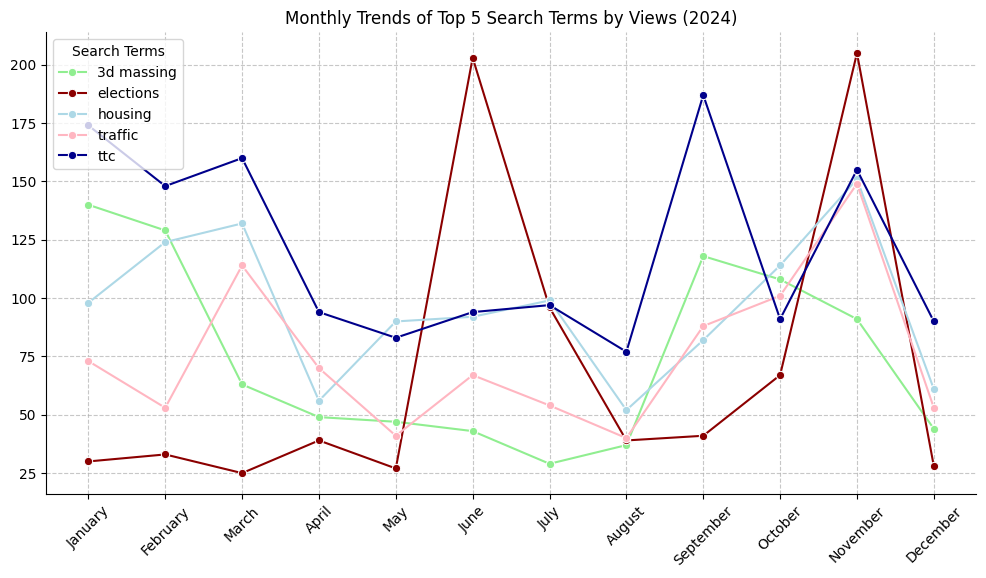

In [300]:
# Create palette with different light colors
light_colors = ['darkblue', 'lightblue', 'lightpink', 'lightgreen'] 
custom_palette = {}
i = 0

for term in top_5_search_terms_2024:
    if term == 'elections':
        custom_palette[term] = 'darkred'  
    else:
        custom_palette[term] = light_colors[i]
        i += 1

plt.figure(figsize=(12, 6))
sns.lineplot(data=top_5_search_terms_monthly_2024, 
                x='Month_Name', 
                y='Views', 
                hue='Search Term -Generic (search=)', 
                marker='o',
                palette=custom_palette)

plt.xlabel("")
plt.ylabel("")
plt.title("Monthly Trends of Top 5 Search Terms by Views (2024)")
plt.legend(title="Search Terms", loc="upper left")
plt.grid(True, linestyle='--', alpha=0.7)

sns.despine()
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()

## Dataset Owner Divisions

### Missing Owner Divisions

In [120]:
page_views_df.query("Category == 'dataset' and owner_division.isna()")[
    ['dataset_name', 'title', 'Views', 'Sessions', 'owner_division']]

dataset_name title  Views  Sessions  \
30824   building-permits-cleared-permits-prior-years   NaN     28        21   
30825   building-permits-cleared-permits-prior-years   NaN     22        20   
30826   building-permits-cleared-permits-prior-years   NaN     19        18   
30827   building-permits-cleared-permits-prior-years   NaN     20        17   
30828   building-permits-cleared-permits-prior-years   NaN     21        17   
...                                              ...   ...    ...       ...   
156012          77e593cf-877b-4bcc-bfdf-0b99e2935e5f   NaN      1         1   
156014          c01c6d71-de1f-493d-91ba-364ce64884ac   NaN      1         1   
156015          c01c6d71-de1f-493d-91ba-364ce64884ac   NaN      1         1   
156016          c01c6d71-de1f-493d-91ba-364ce64884ac   NaN      1         1   
156017          c01c6d71-de1f-493d-91ba-364ce64884ac   NaN      1         1   

       owner_division  
30824             NaN  
30825             NaN  
30826             NaN  
30827             NaN  
30828             NaN  
...               ...  
156012            NaN  
156014            NaN  
156015            NaN  
156016            NaN  
156017            NaN  

[2852 rows x 5 columns]

There are a total of 2852 rows where owner division is missing in the metadata. Let's find which datasets don't have the owner division.

In [121]:
# Getting datasets without topics
datasets_null_owner_division = page_views_df.query("Category == 'dataset' and owner_division.isna()")[
    ['dataset_name', 'Views', 'Sessions']
].copy()

# Grouping by the dataset name & getting the sum of the views & sessions
summary_null_owner_division = datasets_null_owner_division.groupby(['dataset_name']).agg({
    'Views': 'sum',
    'Sessions': 'sum'
}).reset_index()

# Sort by Views to see most viewed datasets with missing topics
summary_null_owner_division.sort_values('Sessions', ascending=False).head(10)

dataset_name  Views  Sessions
39       building-permits-cleared-permits-prior-years   2871      2452
38      building-permits-cleared-permits-current-year   2033      1798
75                   ward-profiles-2018-25-ward-model    590       513
76                                        water-mains    413       362
52  elections-official-by-election-results-for-202...    242       221
48      elections-campaign-contributions-2018-to-2021    139       118
51  elections-official-by-election-results-for-201...     60        54
14               52182614-1f0b-42be-aca4-3f86dc8e004c     55        51
70         topographic-mapping-waterbodies-and-rivers    106        46
46      elections-campaign-contributions-2010-to-2013     52        43

In [122]:
len(summary_null_owner_division)

77

There are 77 datasets without an 'Owner Division'. Exporting this to Excel:

In [ ]:
summary_null_owner_division.to_csv('./Dataset_Jan2025/Datasets_without_owner_division.csv')

In [123]:
page_views_df.query("Category == 'dataset' and dataset_name == '3dmassing'")[['Date', 'Link Source -Page URL', 'dataset_name', 'Category Details 1', 'owner_division']]

Date               Link Source -Page URL dataset_name  \
153700 2024-05-08  open.toronto.ca/dataset/3dmassing/    3dmassing   
153701 2023-03-23  open.toronto.ca/dataset/3dmassing/    3dmassing   
153702 2023-03-17  open.toronto.ca/dataset/3dmassing/    3dmassing   
153703 2023-01-17  open.toronto.ca/dataset/3dmassing/    3dmassing   
153704 2024-02-05  open.toronto.ca/dataset/3dmassing/    3dmassing   
153705 2024-10-03  open.toronto.ca/dataset/3dmassing/    3dmassing   
153706 2023-04-09  open.toronto.ca/dataset/3dmassing/    3dmassing   
153707 2024-01-12  open.toronto.ca/dataset/3dmassing/    3dmassing   
153708 2023-09-13  open.toronto.ca/dataset/3dmassing/    3dmassing   
153709 2024-12-17  open.toronto.ca/dataset/3dmassing/    3dmassing   
153710 2023-01-04  open.toronto.ca/dataset/3dmassing/    3dmassing   
153711 2023-01-27  open.toronto.ca/dataset/3dmassing/    3dmassing   

       Category Details 1 owner_division  
153700          3dmassing            NaN  
153701          3dmassing            NaN  
153702          3dmassing            NaN  
153703          3dmassing            NaN  
153704          3dmassing            NaN  
153705          3dmassing            NaN  
153706          3dmassing            NaN  
153707          3dmassing            NaN  
153708          3dmassing            NaN  
153709          3dmassing            NaN  
153710          3dmassing            NaN  
153711          3dmassing            NaN

In [124]:
page_views_df.query("Category == 'dataset' and dataset_name == '3dmassing'")['owner_division'].unique()

array([nan], dtype=object)

In [125]:
page_views_df.query("Category == 'dataset' and dataset_name == '3d'")


Link Source -Page URL       Date  Sessions  Users  Views  \
154314  open.toronto.ca/dataset/3d/ 2024-10-28         1      1      1   
154315  open.toronto.ca/dataset/3d/ 2024-11-29         1      1      1   
154316  open.toronto.ca/dataset/3d/ 2024-06-17         1      1      2   
154317  open.toronto.ca/dataset/3d/ 2023-11-08         1      1      1   
154318  open.toronto.ca/dataset/3d/ 2024-02-28         1      1      1   
154319  open.toronto.ca/dataset/3d/ 2023-04-02         1      1      1   
154320  open.toronto.ca/dataset/3d/ 2024-07-17         1      1      1   

        Avg Session Duration (Sec)  Views per Session  Bounce Rate %  \
154314                        19.0                1.0            0.0   
154315                      5349.0                1.0            0.0   
154316                       131.0                2.0            0.0   
154317                        94.0                1.0            0.0   
154318                         0.0                1.0            1.0   
154319                       304.0                1.0            0.0   
154320                       114.0                1.0            0.0   

       dataset_name name  ... owner_unit         Base URL Category  \
154314           3d  NaN  ...        NaN  open.toronto.ca  dataset   
154315           3d  NaN  ...        NaN  open.toronto.ca  dataset   
154316           3d  NaN  ...        NaN  open.toronto.ca  dataset   
154317           3d  NaN  ...        NaN  open.toronto.ca  dataset   
154318           3d  NaN  ...        NaN  open.toronto.ca  dataset   
154319           3d  NaN  ...        NaN  open.toronto.ca  dataset   
154320           3d  NaN  ...        NaN  open.toronto.ca  dataset   

       Category Details 1 Category Details 2 Day Month  Year   Day_Name  \
154314                 3d                     28    10  2024     Monday   
154315                 3d                     29    11  2024     Friday   
154316                 3d                     17     6  2024     Monday   
154317                 3d                      8    11  2023  Wednesday   
154318                 3d                     28     2  2024  Wednesday   
154319                 3d                      2     4  2023     Sunday   
154320                 3d                     17     7  2024  Wednesday   

       Sessions_Per_User  
154314               1.0  
154315               1.0  
154316               1.0  
154317               1.0  
154318               1.0  
154319               1.0  
154320               1.0  

[7 rows x 31 columns]

In [126]:
page_views_df.query("Category == 'dataset' and dataset_name == '3d'")['owner_division'].unique()

array([nan], dtype=object)

### Top 10: Owner Division Counts (All Time)

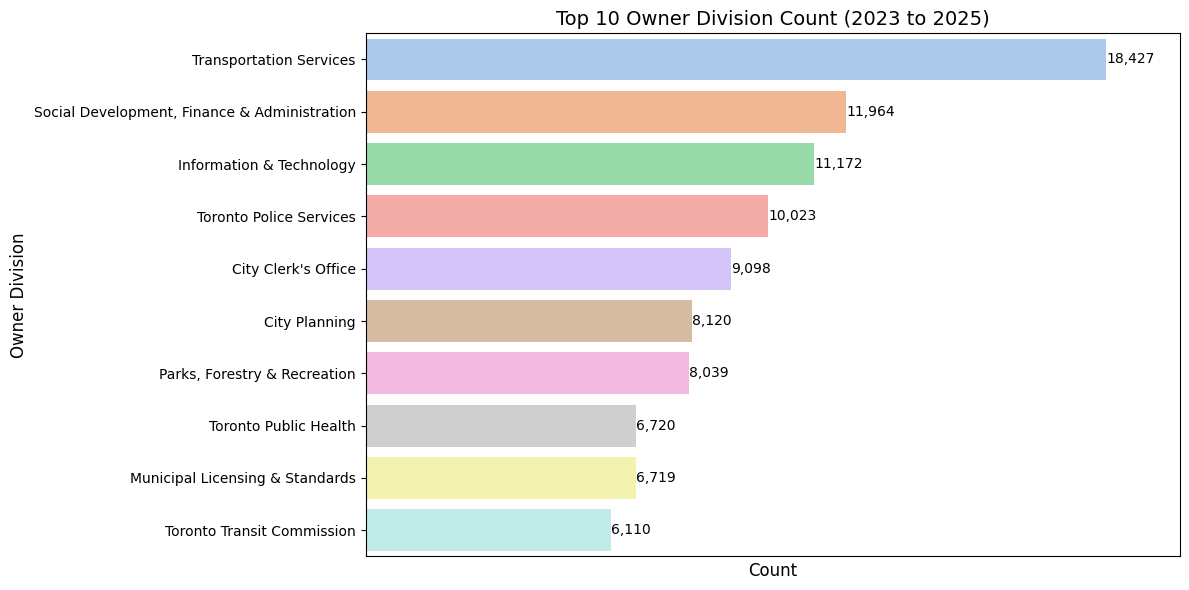

In [127]:
# Approach 1: If we want to count each division separately (exploding the lists)
exploded_divisions = page_views_df['owner_division'].explode()
division_counts = exploded_divisions.value_counts()

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=division_counts.values[:10], 
                 y=division_counts.index[:10],
                 hue=division_counts.index[:10], 
                 palette='pastel',
                 legend=False)

# Adding labels to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_width()):,}', 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='left', va='center')
    
# Decrease the scale of the x-axis - so that the labels do not go outside the graph
plt.xlim(0, division_counts.values.max() * 1.1)  # Adjust the multiplier as needed

plt.title('Top 10 Owner Division Count (2023 to 2025)', fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Owner Division', fontsize=12)

# Remove x-axis values since we have labels
plt.xticks([])

# Adjust layout to prevent label cutoff
plt.tight_layout()

### Top 10: Owner Divisions By Views (of All Time)

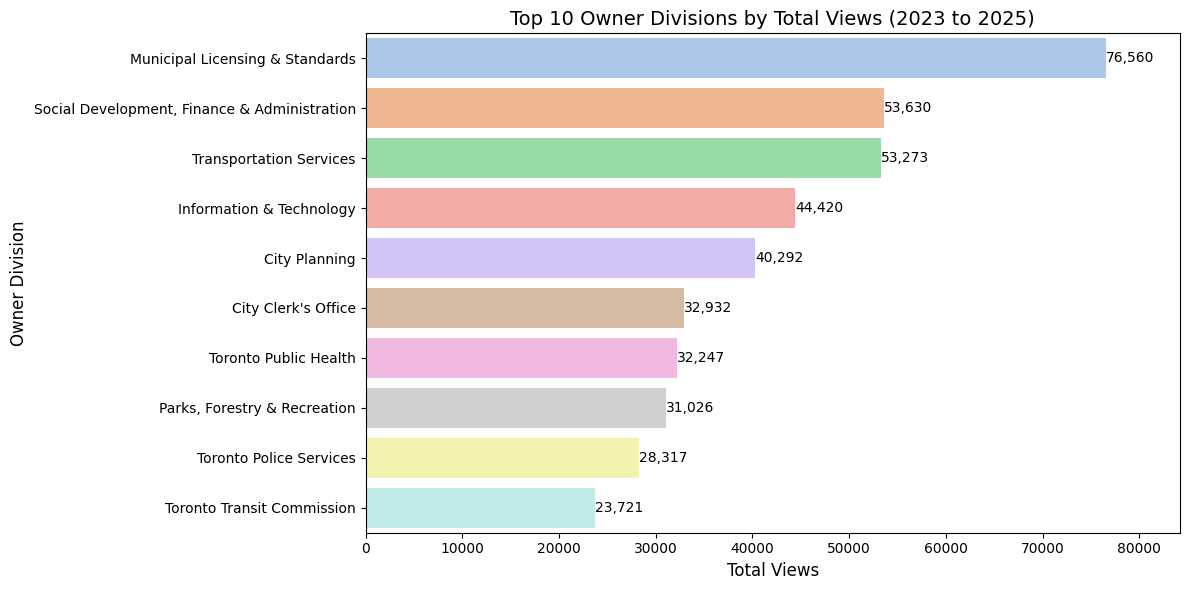

In [128]:
# Group by owner division and sum views
top_10_divisions_by_views = page_views_df.groupby('owner_division')['Views'].sum().sort_values(ascending=False)[:10]

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=top_10_divisions_by_views.reset_index(), 
                 x='Views', 
                 y='owner_division',
                 hue='owner_division',
                 palette='pastel',
                 legend=False)

# Adding labels to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_width()):,}', 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='left', va='center')

# Decrease the scale of the x-axis - so that the labels do not go outside the graph
plt.xlim(0, top_10_divisions_by_views.values.max() * 1.1)  # Adjust the multiplier as needed

plt.title('Top 10 Owner Divisions by Total Views (2023 to 2025)', fontsize=14)
plt.xlabel('Total Views', fontsize=12)
plt.ylabel('Owner Division', fontsize=12)


# Adjust layout to prevent label cutoff
plt.tight_layout()

### Top 10: Owner Divisions by Views (2023)

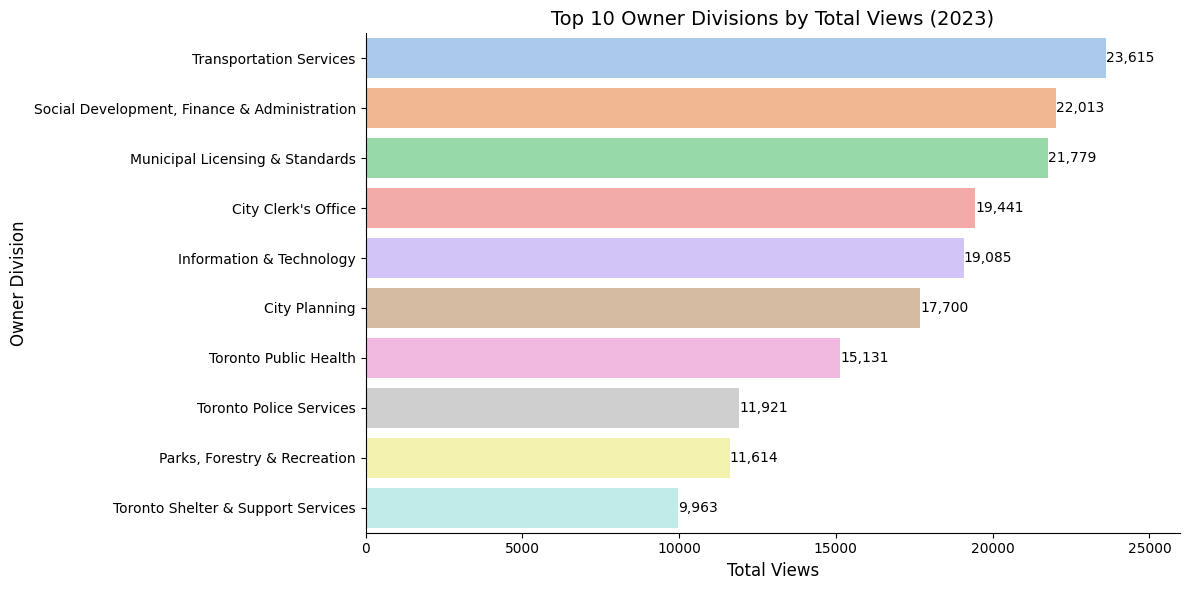

In [301]:
# Group by owner division and sum views
top_10_divisions_by_views_2023 = (page_views_df
                                  .query("Year == 2023")
                                  .groupby('owner_division')['Views']
                                  .sum()
                                  .sort_values(ascending=False)
                                  [:10])

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=top_10_divisions_by_views_2023.reset_index(), 
                 x='Views', 
                 y='owner_division',
                 hue='owner_division',
                 palette='pastel',
                 legend=False)

# Adding labels to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_width()):,}', 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='left', va='center')

# Decrease the scale of the x-axis - so that the labels do not go outside the graph
plt.xlim(0, top_10_divisions_by_views_2023.values.max() * 1.1)  # Adjust the multiplier as needed

plt.title('Top 10 Owner Divisions by Total Views (2023)', fontsize=14)
plt.xlabel('Total Views', fontsize=12)
plt.ylabel('Owner Division', fontsize=12)

sns.despine()

# Adjust layout to prevent label cutoff
plt.tight_layout()

### Top 10: Owner Divisions by Views (2024)

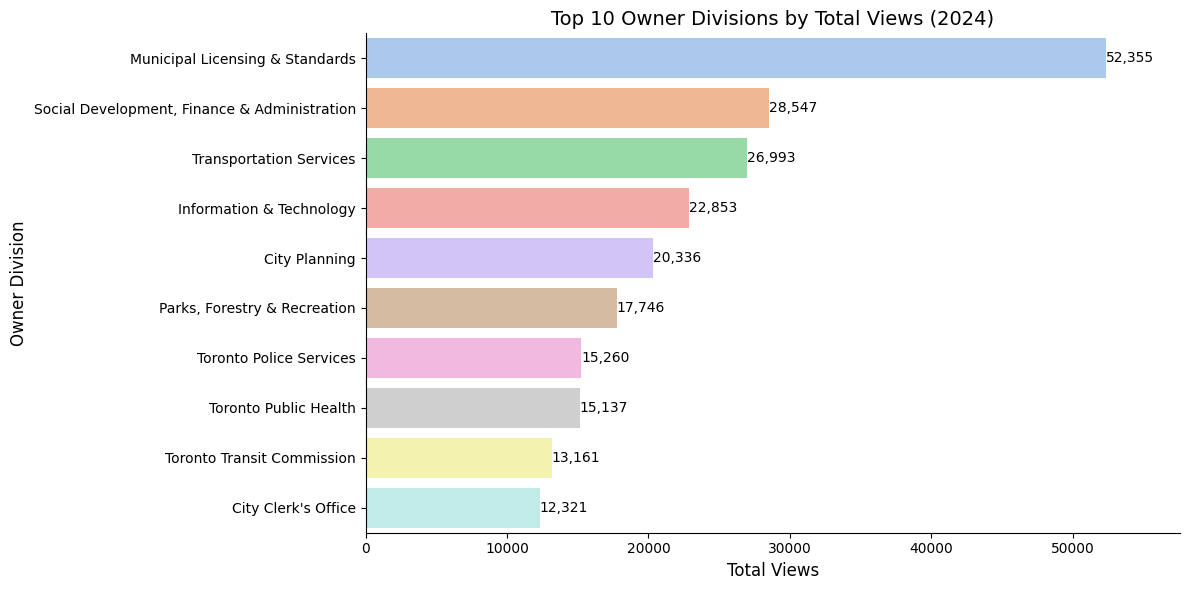

In [302]:
# Group by owner division and sum views
top_10_divisions_by_views_2024 = (page_views_df
                                  .query("Year == 2024")
                                  .groupby('owner_division')['Views']
                                  .sum()
                                  .sort_values(ascending=False)
                                  [:10])

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=top_10_divisions_by_views_2024.reset_index(), 
                 x='Views', 
                 y='owner_division',
                 hue='owner_division',
                 palette='pastel',
                 legend=False)

# Adding labels to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_width()):,}', 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='left', va='center')

# Decrease the scale of the x-axis - so that the labels do not go outside the graph
plt.xlim(0, top_10_divisions_by_views_2024.values.max() * 1.1)  # Adjust the multiplier as needed

plt.title('Top 10 Owner Divisions by Total Views (2024)', fontsize=14)
plt.xlabel('Total Views', fontsize=12)
plt.ylabel('Owner Division', fontsize=12)

sns.despine()

# Adjust layout to prevent label cutoff
plt.tight_layout()

### Top 5 Owner Division Over Time (2023)

In [330]:
top_5_owner_division_by_views_2023 = (page_views_df
                                        .query('Year == 2023')
                                        .groupby('owner_division', as_index=False)['Views']
                                        .sum()
                                        .sort_values('Views', ascending=False)
                                        [:5]
                                        ['owner_division']
                                    )  

print(top_5_owner_division_by_views_2023)

page_views_df['Month_Name'] = page_views_df['Month'].apply(lambda x: calendar.month_name[x])

top_5_owner_division_monthly_by_views_2023 = (page_views_df
                                                .query('Year == 2023')
                                                .groupby(['Month', 'Month_Name', 'owner_division'], as_index=False)
                                                .agg({'Views': 'sum'})
                                                .query('owner_division in @top_5_owner_division_by_views_2023')  # Keep only top 5 datasets
                                            )

top_5_owner_division_monthly_by_views_2023

43                         Transportation Services
29    Social Development, Finance & Administration
22                 Municipal Licensing & Standards
3                              City Clerk's Office
20                        Information & Technology
Name: owner_division, dtype: object


Month Month_Name                                owner_division  Views
3        1    January                           City Clerk's Office   1007
19       1    January                      Information & Technology   1249
21       1    January               Municipal Licensing & Standards   1462
28       1    January  Social Development, Finance & Administration   2183
42       1    January                       Transportation Services   2149
46       2   February                           City Clerk's Office   1237
62       2   February                      Information & Technology   1382
64       2   February               Municipal Licensing & Standards   1347
71       2   February  Social Development, Finance & Administration   2173
85       2   February                       Transportation Services   2218
89       3      March                           City Clerk's Office   1267
105      3      March                      Information & Technology   1998
107      3      March               Municipal Licensing & Standards   1779
114      3      March  Social Development, Finance & Administration   3219
128      3      March                       Transportation Services   3226
132      4      April                           City Clerk's Office   1134
148      4      April                      Information & Technology   1401
150      4      April               Municipal Licensing & Standards   1152
157      4      April  Social Development, Finance & Administration   1900
171      4      April                       Transportation Services   2077
175      5        May                           City Clerk's Office   1073
190      5        May                      Information & Technology   1310
192      5        May               Municipal Licensing & Standards   1109
199      5        May  Social Development, Finance & Administration   1150
213      5        May                       Transportation Services   1544
217      6       June                           City Clerk's Office   4317
234      6       June                      Information & Technology   1095
236      6       June               Municipal Licensing & Standards   2984
243      6       June  Social Development, Finance & Administration   1191
257      6       June                       Transportation Services   1425
261      7       July                           City Clerk's Office   3672
278      7       July                      Information & Technology   1020
280      7       July               Municipal Licensing & Standards   2062
287      7       July  Social Development, Finance & Administration   1102
301      7       July                       Transportation Services   1240
305      8     August                           City Clerk's Office   1256
322      8     August                      Information & Technology   1261
324      8     August               Municipal Licensing & Standards   2227
331      8     August  Social Development, Finance & Administration   1029
345      8     August                       Transportation Services   1241
349      9  September                           City Clerk's Office   1080
365      9  September                      Information & Technology   2066
367      9  September               Municipal Licensing & Standards   1904
374      9  September  Social Development, Finance & Administration   1587
388      9  September                       Transportation Services   1975
392     10    October                           City Clerk's Office    963
408     10    October                      Information & Technology   2450
410     10    October               Municipal Licensing & Standards   2421
417     10    October  Social Development, Finance & Administration   2323
431     10    October                       Transportation Services   2634
435     11   November                           City Clerk's Office   1229
452     11   November                      Information & Technology   2498
454     11   November         

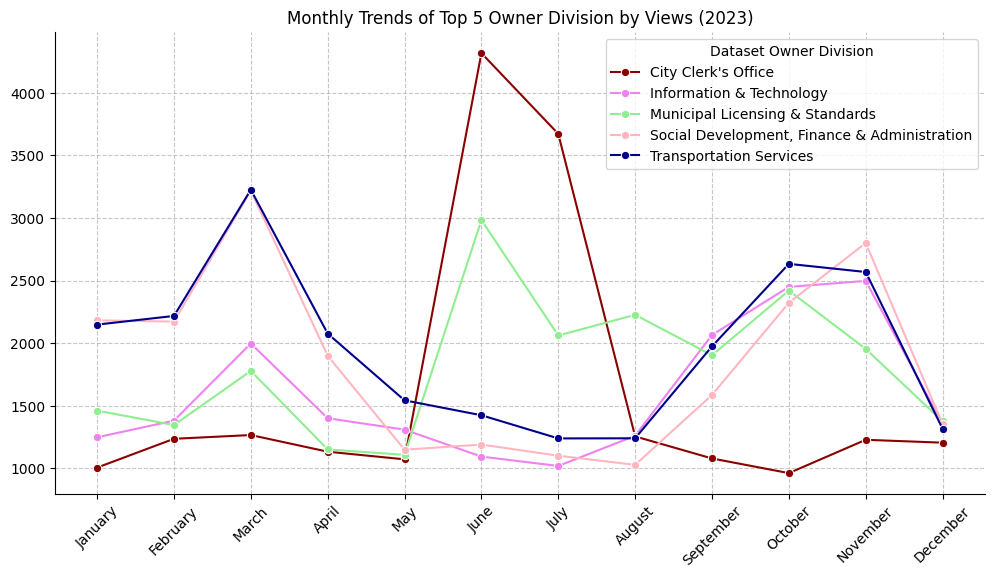

In [335]:
# Create palette with different light colors
light_colors = ['lightpink', 'lightgreen', 'violet'] 
custom_palette = {}
i = 0

for term in top_5_owner_division_by_views_2023:
    if term == "City Clerk's Office":
        custom_palette[term] = 'darkred'  
    elif term == 'Transportation Services':
        custom_palette[term] = 'darkblue'
    else:
        custom_palette[term] = light_colors[i]
        i += 1

plt.figure(figsize=(12, 6))
sns.lineplot(data=top_5_owner_division_monthly_by_views_2023, 
                x='Month_Name', 
                y='Views', 
                hue='owner_division', 
                marker='o',
                palette=custom_palette
                )

plt.xlabel("")
plt.ylabel("")
plt.title("Monthly Trends of Top 5 Owner Division by Views (2023)")
plt.legend(title="Dataset Owner Division")
plt.grid(True, linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
sns.despine()

plt.show()

### Top 5 Owner Division Over Time (2024)

In [338]:
top_5_owner_division_by_views_2024 = (page_views_df
                                        .query('Year == 2024')
                                        .groupby('owner_division', as_index=False)['Views']
                                        .sum()
                                        .sort_values('Views', ascending=False)
                                        [:5]
                                        ['owner_division']
                                    )  

print(top_5_owner_division_by_views_2024)

top_5_owner_division_monthly_by_views_2024 = (page_views_df
                                                .query('Year == 2024')
                                                .groupby(['Month', 'Month_Name', 'owner_division'], as_index=False)
                                                .agg({'Views': 'sum'})
                                                .query('owner_division in @top_5_owner_division_by_views_2024')  # Keep only top 5 datasets
                                            )

top_5_owner_division_monthly_by_views_2024

23                 Municipal Licensing & Standards
30    Social Development, Finance & Administration
44                         Transportation Services
21                        Information & Technology
5                                    City Planning
Name: owner_division, dtype: object


Month Month_Name                                owner_division  Views
5        1    January                                 City Planning   2358
20       1    January                      Information & Technology   2620
22       1    January               Municipal Licensing & Standards   2163
29       1    January  Social Development, Finance & Administration   2361
43       1    January                       Transportation Services   2300
49       2   February                                 City Planning   1948
63       2   February                      Information & Technology   1951
65       2   February               Municipal Licensing & Standards   1812
71       2   February  Social Development, Finance & Administration   2948
85       2   February                       Transportation Services   1940
91       3      March                                 City Planning   2110
106      3      March                      Information & Technology   2146
108      3      March               Municipal Licensing & Standards   2255
115      3      March  Social Development, Finance & Administration   3593
129      3      March                       Transportation Services   2984
135      4      April                                 City Planning   1502
150      4      April                      Information & Technology   1572
152      4      April               Municipal Licensing & Standards  21746
158      4      April  Social Development, Finance & Administration   2362
172      4      April                       Transportation Services   2047
178      5        May                                 City Planning   1458
193      5        May                      Information & Technology   1524
195      5        May               Municipal Licensing & Standards   4156
202      5        May  Social Development, Finance & Administration   1648
216      5        May                       Transportation Services   1892
222      6       June                                 City Planning   1249
237      6       June                      Information & Technology   1300
239      6       June               Municipal Licensing & Standards   2525
246      6       June  Social Development, Finance & Administration   2152
260      6       June                       Transportation Services   2204
266      7       July                                 City Planning   1216
281      7       July                      Information & Technology   1274
283      7       July               Municipal Licensing & Standards   3538
289      7       July  Social Development, Finance & Administration   1282
303      7       July                       Transportation Services   1707
309      8     August                                 City Planning    998
324      8     August                      Information & Technology   1181
326      8     August               Municipal Licensing & Standards   2034
333      8     August  Social Development, Finance & Administration   1144
347      8     August                       Transportation Services   1308
353      9  September                                 City Planning   2239
369      9  September                      Information & Technology   2522
371      9  September               Municipal Licensing & Standards   4637
378      9  September  Social Development, Finance & Administration   2422
392      9  September                       Transportation Services   3015
398     10    October                                 City Planning   2096
414     10    October                      Information & Technology   2344
416     10    October               Municipal Licensing & Standards   2783
423     10    October  Social Development, Finance & Administration   3343
437     10    October                       Transportation Services   2634
443     11   November                                 City Planning   2031
459     11   November                      Information & Technology   2709
461     11   November         

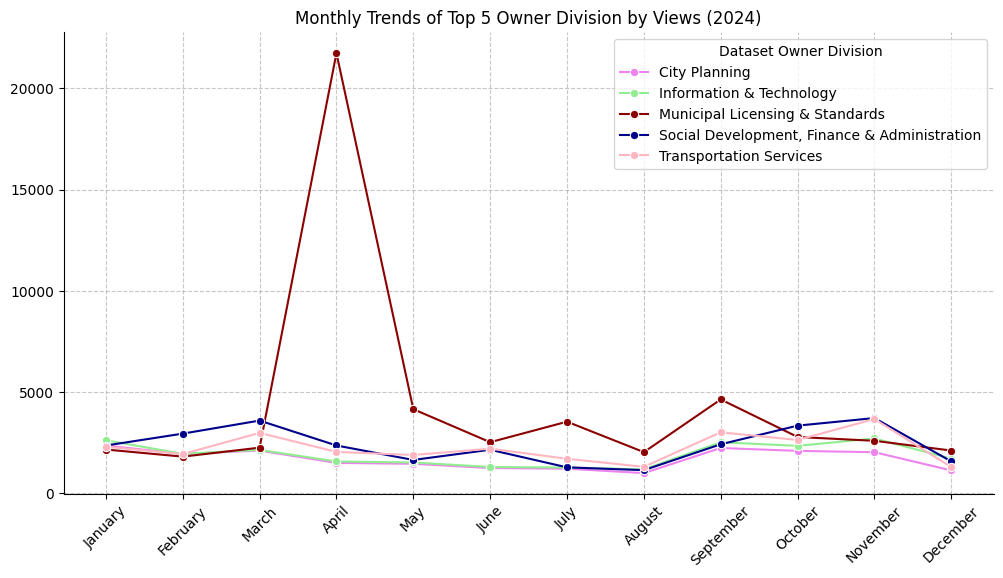

In [ ]:
# Create palette with different light colors
light_colors = ['lightpink', 'lightgreen', 'violet'] 
custom_palette = {}
i = 0

for term in top_5_owner_division_by_views_2024:
    if term == "Municipal Licensing & Standards":
        custom_palette[term] = 'darkred'  
    elif term == 'Social Development, Finance & Administration':
        custom_palette[term] = 'darkblue'
    else:
        custom_palette[term] = light_colors[i]
        i += 1

plt.figure(figsize=(12, 6))
sns.lineplot(data=top_5_owner_division_monthly_by_views_2024, 
                x='Month_Name', 
                y='Views', 
                hue='owner_division', 
                marker='o',
                palette=custom_palette
                )

plt.xlabel("")
plt.ylabel("")
plt.title("Monthly Trends of Top 5 Owner Division by Views (2024)")
plt.legend(title="Dataset Owner Division")
plt.grid(True, linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

sns.despine()

plt.show()

### Top 10 Owner Divisions By Sessions (of All Time)

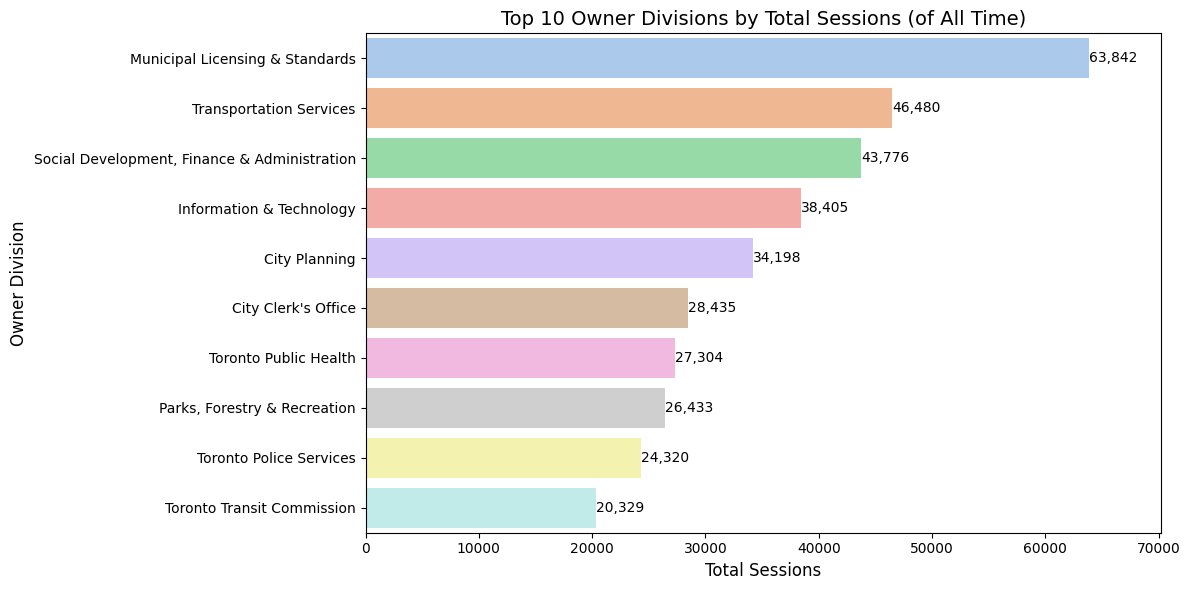

In [ ]:
# Group by owner division and sum views
top_10_divisions_by_sessions = (page_views_df
                                    .query("Category == 'dataset'")
                                    .groupby('owner_division')['Sessions']
                                    .sum()
                                    .sort_values(ascending=False)
                                    [:10]
                                )

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=top_10_divisions_by_sessions.reset_index(), 
                 x='Sessions', 
                 y='owner_division',
                 hue='owner_division',
                 palette='pastel',
                 legend=False)

# Adding labels to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_width()):,}', 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='left', va='center')

# Decrease the scale of the x-axis - so that the labels do not go outside the graph
plt.xlim(0, top_10_divisions_by_sessions.values.max() * 1.1)  # Adjust the multiplier as needed

plt.title('Top 10 Owner Divisions by Total Sessions (of All Time)', fontsize=14)
plt.xlabel('Total Sessions', fontsize=12)
plt.ylabel('Owner Division', fontsize=12)


# Adjust layout to prevent label cutoff
plt.tight_layout()

## Top Dataset Topics

In [ ]:
page_views_df.query("Category == 'dataset'")['topics'].value_counts()

topics
[City government]                                                     12281
[Transportation]                                                       9326
[Locations and mapping, Transportation]                                9100
[Public safety]                                                        8437
[Community services]                                                   6857
                                                                      ...  
[City government, Garbage and recycling, Locations and mapping]          81
[Locations and mapping, Permits and licenses, Transportation]            78
[Culture and tourism, Finance]                                           69
[Business, Locations and mapping]                                        54
[Locations and mapping, Culture and tourism, Permits and licenses]        7
Name: count, Length: 132, dtype: int64

In [ ]:
type(page_views_df.query("Category == 'dataset'")['topics'])

pandas.core.series.Series

Let's get all the individual topic from the above list of topics.

In [ ]:
# Get all topics and explode the lists into individual rows
flattened_topics = page_views_df.query("Category == 'dataset'")['topics'].explode()

In [ ]:
flattened_topics.unique()

array(['Culture and tourism', 'Business', 'Permits and licenses', nan,
       'City government', 'Community services', 'Locations and mapping',
       'Public safety', 'Health', 'Transportation', 'Environment',
       'Parks and recreation', 'Development and infrastructure',
       'Finance', 'Water', 'Garbage and recycling'], dtype=object)

In [ ]:
page_views_df.query("Category == 'dataset' and topics.isna()")

Link Source -Page URL       Date  \
2353    open.toronto.ca/dataset/dogs-issued-dangerous-... 2024-04-24   
2354    open.toronto.ca/dataset/dogs-issued-dangerous-... 2024-04-25   
2355    open.toronto.ca/dataset/dogs-issued-dangerous-... 2024-04-26   
2356    open.toronto.ca/dataset/dogs-issued-dangerous-... 2024-04-27   
2357    open.toronto.ca/dataset/dogs-issued-dangerous-... 2024-04-28   
...                                                   ...        ...   
156012  open.toronto.ca/dataset/77e593cf-877b-4bcc-bfd... 2023-10-06   
156014  open.toronto.ca/dataset/c01c6d71-de1f-493d-91b... 2024-11-03   
156015  open.toronto.ca/dataset/c01c6d71-de1f-493d-91b... 2024-02-15   
156016  open.toronto.ca/dataset/c01c6d71-de1f-493d-91b... 2023-01-29   
156017  open.toronto.ca/dataset/c01c6d71-de1f-493d-91b... 2024-11-09   

        Sessions  Users  Views  Avg Session Duration (Sec)  Views per Session  \
2353        5371   5224   7105                  240.419608           1.322845   
2354        5156   5056   6774                  243.327243           1.313809   
2355        2204   2108   2829                  217.621565           1.283575   
2356        1109   1061   1400                  208.406114           1.262399   
2357         384    351    478                  261.875000           1.244792   
...          ...    ...    ...                         ...                ...   
156012         1      1      1                    0.000000           1.000000   
156014         1      1      1                    0.000000           1.000000   
156015         1      1      1                    0.000000           1.000000   
156016         1      1      1                  394.000000           1.000000   
156017         1      1      1                    0.000000           1.000000   

        Bounce Rate %                          dataset_name  \
2353         0.762614      dogs-issued-dangerous-dog-orders   
2354         0.766486      dogs-issued-dangerous-dog-orders   
2355         0.785390      dogs-issued-dangerous-dog-orders   
2356         0.793508      dogs-issued-dangerous-dog-orders   
2357         0.812500      dogs-issued-dangerous-dog-orders   
...               ...                                   ...   
156012       1.000000  77e593cf-877b-4bcc-bfdf-0b99e2935e5f   
156014       1.000000  c01c6d71-de1f-493d-91ba-364ce64884ac   
156015       1.000000  c01c6d71-de1f-493d-91ba-364ce64884ac   
156016       0.000000  c01c6d71-de1f-493d-91ba-364ce64884ac   
156017       1.000000  c01c6d71-de1f-493d-91ba-364ce64884ac   

                                    name  ...   owner_unit         Base URL  \
2353    dogs-issued-dangerous-dog-orders  ...  Enforcement  open.toronto.ca   
2354    dogs-issued-dangerous-dog-orders  ...  Enforcement  open.toronto.ca   
2355    dogs-issued-dangerous-dog-orders  ...  Enforcement  open.toronto.ca   
2356    dogs-issued-dangerous-dog-orders  ...  Enforcement  open.toronto.ca   
2357    dogs-issued-dangerous-dog-orders  ...  Enforcement  open.toronto.ca   
...                                  ...  ...          ...              ...   
156012                               NaN  ...          NaN  open.toronto.ca   
156014                               NaN  ...          NaN  open.toronto.ca   
156015                               NaN  ...          NaN  open.toronto.ca   
156016                               NaN  ...          NaN  open.toronto.ca   
156017                               NaN  ...          NaN  open.toronto.ca   

       Category                    Category Details 1 Category Details 2 Day  \
2353    dataset      dogs-issued-dangerous-dog-orders                     24   
2354    dataset      dogs-issued-dangerous-dog-orders                     25   
2355    dataset      dogs-issued-dangerous-dog-orders                     26   
2356    dataset      dogs-issued-dangerous-dog-orders                     27   
2357    dataset      dogs-issued-dangerous-dog-orders                     28   
...         

Let's understand which datasets don't have topics defined:

In [ ]:
# Getting datasets without topics
datasets_null_topics = page_views_df.query("Category == 'dataset' and topics.isna()")[
    ['dataset_name', 'title', 'owner_division', 'Views', 'Sessions']
].copy()

# Grouping by the dataset name & getting the sum of the views & sessions
summary_null_topics = datasets_null_topics.groupby(['dataset_name', 'title', 'owner_division']).agg({
    'Views': 'sum',
    'Sessions': 'sum'
}).reset_index()

# Sort by Views to see most viewed datasets with missing topics
summary_null_topics.sort_values('Views', ascending=False).head(10)

dataset_name  \
7                    dogs-issued-dangerous-dog-orders   
3   cost-of-living-in-toronto-for-low-income-house...   
24              topographic-mapping-building-outlines   
5                            development-applications   
26                              ttc-subway-shapefiles   
11                 library-branch-general-information   
0          active-affordable-and-social-housing-units   
4   demolition-and-replacement-of-rental-housing-u...   
20                        real-estate-asset-inventory   
2                    city-of-toronto-free-public-wifi   

                                                title  \
7   Registry of Dogs Subject to and Issued a Dange...   
3   Cost of living in Toronto for low-income house...   
24            Topographic Mapping – Building Outlines   
5                            Development Applications   
26                              TTC Subway Shapefiles   
11                 Library Branch General Information   
0          Active Affordable and Social Housing Units   
4   Demolition and Replacement of Rental Housing U...   
20                        Real Estate Asset Inventory   
2                    City of Toronto Free Public WiFi   

                                  owner_division  Views  Sessions  
7                Municipal Licensing & Standards  23753     18423  
3   Social Development, Finance & Administration   3476      2975  
24                      Information & Technology   3064      2623  
5                                  City Planning   2641      2251  
26                    Toronto Transit Commission   1705      1507  
11                        Toronto Public Library   1656      1389  
0                            Housing Secretariat   1274      1096  
4                                  City Planning   1221      1081  
20              Corporate Real Estate Management   1132      1018  
2                       Information & Technology   1038       933

In [ ]:
len(summary_null_topics)

29

Exporting these datasets to an excel file for more analysis.

In [ ]:
summary_null_topics.to_excel('./Dataset_Jan2025/Datasets_without_topics.xlsx')

## Civic Issues Distribution by Views

civic_issues
Mobility                 47338
Poverty reduction        25139
Affordable housing       19174
Climate change           13427
Fiscal responsibility     8512
Name: Views, dtype: int64


(-1.0999939657003344,
 1.0999997126523968,
 -1.099997619393378,
 1.099990885379699)

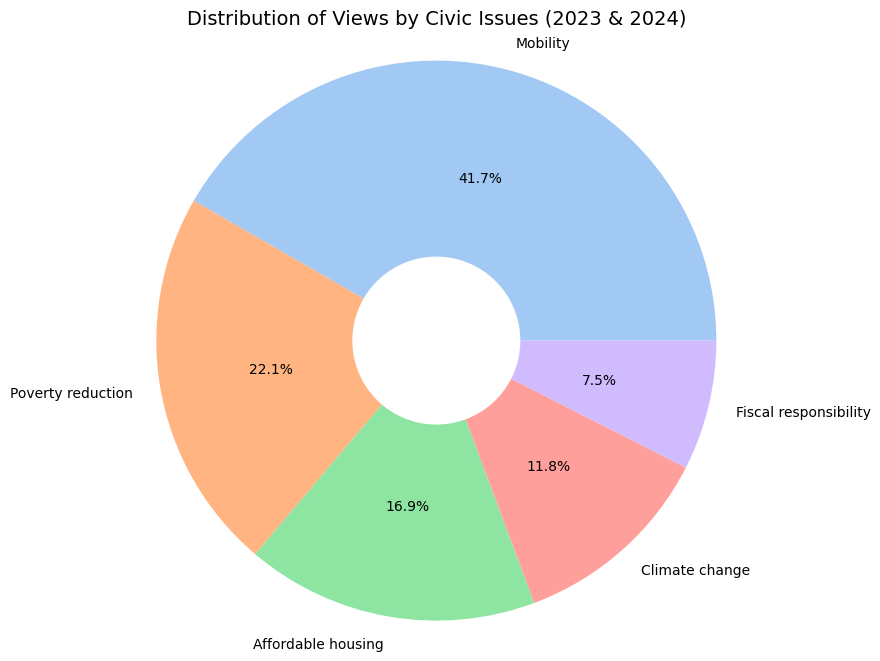

In [354]:
# Ensure 'civic_issues' column is exploded if it contains lists
if page_views_df['civic_issues'].apply(lambda x: isinstance(x, list)).any():
    page_views_df = page_views_df.explode('civic_issues')

# Group by civic issues and sum views
civic_issues_views = (page_views_df
                        .query("Year == 2023 or Year == 2024")
                        .groupby('civic_issues')['Views']
                        .sum()
                        .sort_values(ascending=False)
                        # [:5]
                )

print(civic_issues_views)

plt.figure(figsize=(10, 8))
plt.pie(civic_issues_views, 
        labels=civic_issues_views.index, 
        autopct='%1.1f%%',
        colors=sns.color_palette('pastel', len(civic_issues_views)),
        wedgeprops=dict(width=0.7))  # Make it a donut chart

plt.title('Distribution of Views by Civic Issues (2023 & 2024)', fontsize=14)
plt.axis('equal')

## Civic Issues Distribution by Views (2023)

civic_issues
Mobility                 22163
Poverty reduction        11973
Affordable housing        9197
Climate change            6107
Fiscal responsibility     3884
Name: Views, dtype: int64


(-1.0999933722248034,
 1.0999996843916573,
 -1.0999979314737631,
 1.0999909037412696)

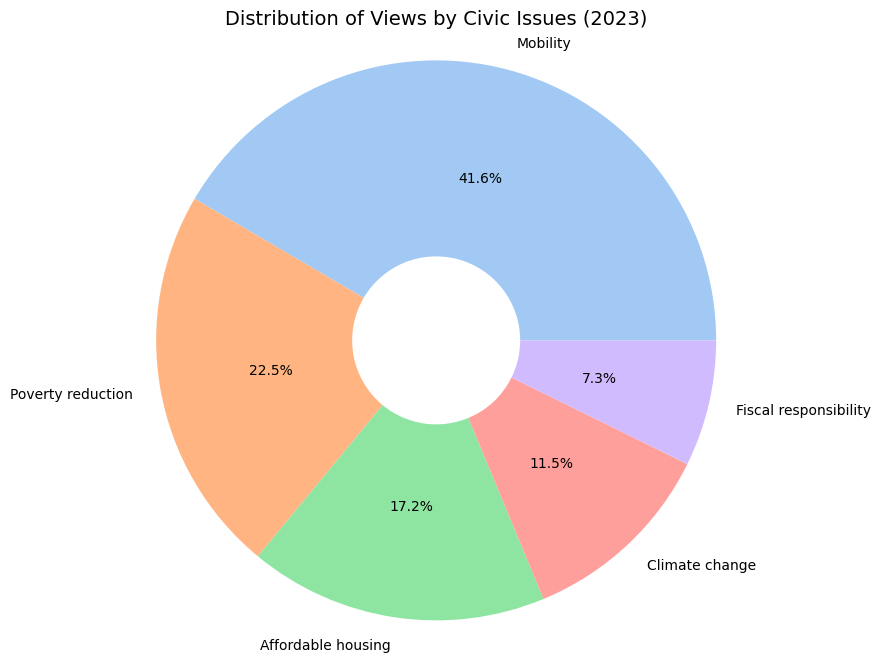

In [355]:
# Group by civic issues and sum views
civic_issues_views_2023 = (page_views_df
                        .query("Year == 2023")
                        .groupby('civic_issues')['Views']
                        .sum()
                        .sort_values(ascending=False)
                        # [:5]
                )

print(civic_issues_views_2023)

plt.figure(figsize=(10, 8))
plt.pie(civic_issues_views_2023, 
        labels=civic_issues_views_2023.index, 
        autopct='%1.1f%%',
        colors=sns.color_palette('pastel', len(civic_issues_views_2023)),
        wedgeprops=dict(width=0.7))  # Make it a donut chart

plt.title('Distribution of Views by Civic Issues (2023)', fontsize=14)
plt.axis('equal')

## Civic Issues Distribution by Views (2024)

civic_issues
Mobility                 25175
Poverty reduction        13166
Affordable housing        9977
Climate change            7320
Fiscal responsibility     4628
Name: Views, dtype: int64


(-1.0999944533277384,
 1.0999997358727494,
 -1.0999974661435656,
 1.099990883124201)

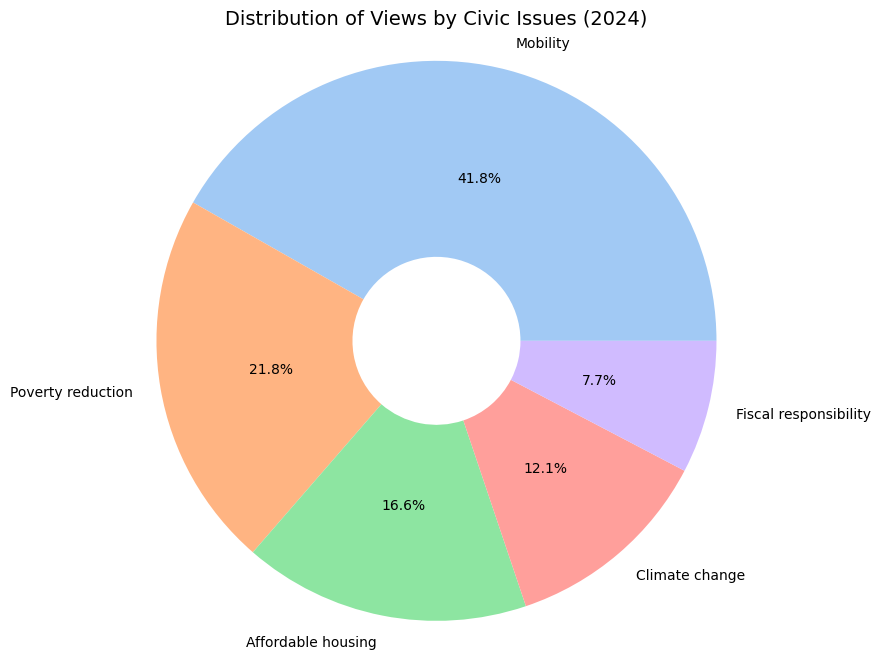

In [356]:
# Group by civic issues and sum views
civic_issues_views_2024 = (page_views_df
                        .query("Year == 2024")
                        .groupby('civic_issues')['Views']
                        .sum()
                        .sort_values(ascending=False)
                        # [:5]
                )

print(civic_issues_views_2024)

plt.figure(figsize=(10, 8))
plt.pie(civic_issues_views_2024, 
        labels=civic_issues_views_2024.index, 
        autopct='%1.1f%%',
        colors=sns.color_palette('pastel', len(civic_issues_views_2024)),
        wedgeprops=dict(width=0.7))  # Make it a donut chart

plt.title('Distribution of Views by Civic Issues (2024)', fontsize=14)
plt.axis('equal')

In [357]:
# Create a DataFrame with both years' data
civic_issues_comparison_df = pd.DataFrame({
    '2023_Views': civic_issues_views_2023,
    '2024_Views': civic_issues_views_2024
}).fillna(0)  # Fill NaN with 0 for any civic issues not present in one year

# Calculate percent change
civic_issues_comparison_df['Percent_Change'] = ((civic_issues_comparison_df['2024_Views'] - civic_issues_comparison_df['2023_Views']) / 
                                 civic_issues_comparison_df['2023_Views'] * 100)

# Format the views columns to display commas for thousands
civic_issues_comparison_df['2023_Views'] = civic_issues_comparison_df['2023_Views'].astype(int).apply('{:,}'.format)
civic_issues_comparison_df['2024_Views'] = civic_issues_comparison_df['2024_Views'].astype(int).apply('{:,}'.format)

# Format percent change to 2 decimal places and add % symbol
civic_issues_comparison_df['Percent_Change'] = civic_issues_comparison_df['Percent_Change'].apply(lambda x: f"{x:,.2f}%")

# Reset index to make civic issues a column
civic_issues_comparison_df = civic_issues_comparison_df.reset_index()
civic_issues_comparison_df = civic_issues_comparison_df.rename(columns={'index': 'Civic Issue'})

# Display the comparison table
print("\nCivic Issues Views Comparison (2023 vs 2024)")
print("--------------------------------------------")
print(civic_issues_comparison_df.to_string(index=False))


Civic Issues Views Comparison (2023 vs 2024)
--------------------------------------------
         civic_issues 2023_Views 2024_Views Percent_Change
             Mobility     22,163     25,175         13.59%
    Poverty reduction     11,973     13,166          9.96%
   Affordable housing      9,197      9,977          8.48%
       Climate change      6,107      7,320         19.86%
Fiscal responsibility      3,884      4,628         19.16%


## IP Views (Downloads Spike)

There were spikes in:
- Jan 2024

In [ ]:
(ip_views_df.query("Year == 2023")
            .groupby(["Month", "Year"])["OD - File Download Clicks"]
            .sum())

Month  Year
1      2023    405
2      2023    302
3      2023    340
4      2023    319
5      2023    285
6      2023    409
7      2023    305
8      2023    309
9      2023    296
10     2023    483
11     2023    633
12     2023    404
Name: OD - File Download Clicks, dtype: int64

In [ ]:
(ip_views_df.query("Year == 2024")
            .groupby(["Month", "Year"])["OD - File Download Clicks"]
            .sum())

Month  Year
1      2024     860
2      2024     594
3      2024     721
4      2024     985
5      2024     936
6      2024     746
7      2024     875
8      2024     736
9      2024     967
10     2024    1199
11     2024    1329
12     2024    1206
Name: OD - File Download Clicks, dtype: int64

In [ ]:
ip_views_df.query("Month == 1 and Year == 2024")

Client IP       Date  Views  Avg Session Duration (Sec)  \
25     52.234.146.194 2024-01-24     60                         0.0   
48     52.234.146.194 2024-01-25     58                         0.0   
95     52.234.146.194 2024-01-31     56                         0.0   
128    52.234.146.194 2024-01-08     55                         0.0   
158    52.234.146.194 2024-01-18     55                         0.0   
...               ...        ...    ...                         ...   
23511  142.214.88.158 2024-01-11      1                         3.0   
23722   142.214.88.25 2024-01-11      1                         1.0   
23738    138.51.77.13 2024-01-15      5                       336.0   
24170   142.214.88.33 2024-01-24      2                        29.0   
24282   142.214.88.32 2024-01-10      1                        45.0   

       OD - File Download Clicks  Sessions  Day  Month  Year   Day_Name  \
25                             0        60   24      1  2024  Wednesday   
48                             0        58   25      1  2024   Thursday   
95                             0        56   31      1  2024  Wednesday   
128                            0        55    8      1  2024     Monday   
158                            0        55   18      1  2024   Thursday   
...                          ...       ...  ...    ...   ...        ...   
23511                          0         1   11      1  2024   Thursday   
23722                          0         1   11      1  2024   Thursday   
23738                          0         1   15      1  2024     Monday   
24170                          0         2   24      1  2024  Wednesday   
24282                          0         1   10      1  2024  Wednesday   

       Views_Per_Session  Downloads_Per_Session  
25                   1.0                    0.0  
48                   1.0                    0.0  
95                   1.0                    0.0  
128                  1.0                    0.0  
158                  1.0                    0.0  
...                  ...                    ...  
23511                1.0                    0.0  
23722                1.0                    0.0  
23738                5.0                    0.0  
24170                1.0                    0.0  
24282                1.0                    0.0  

[986 rows x 12 columns]

# Categorizing Types of Referrers

In [116]:
referrers_summary

Referring Domain  Sessions   Users  \
0                                        open.toronto.ca    266375  135655   
784                                       www.toronto.ca    172595  116955   
1568                                      www.google.com     14105    9110   
2335                                        www.cp24.com      4219    3946   
2406                                   secure.toronto.ca      3586    2813   
...                                                  ...       ...     ...   
24459                            us7.admin.mailchimp.com         1       1   
24461                                ieeexplore.ieee.org         1       1   
24463                        dev.torontopubliclibrary.ca         1       1   
24465  vigilant-space-waffle-jjpjg4g6r973q756.github.dev         1       1   
24467                      secure.tgam.arcpublishing.com         1       1   

        Views  Views_Per_Session  Sessions_Per_User  
0      584572           2.194545           1.963621  
784    210520           1.219734           1.475739  
1568    18774           1.331017           1.548299  
2335     5204           1.233468           1.069184  
2406     4543           1.266871           1.274796  
...       ...                ...                ...  
24459       2           2.000000           1.000000  
24461       1           1.000000           1.000000  
24463       3           3.000000           1.000000  
24465       1           1.000000           1.000000  
24467       2           2.000000           1.000000  

[1000 rows x 6 columns]

In [117]:
len(referrers_summary['Referring Domain'].unique())

1000

In [118]:
referrers_summary['Referring Domain'].unique()[0:20]

array(['open.toronto.ca', 'www.toronto.ca', 'www.google.com',
       'www.cp24.com', 'secure.toronto.ca', 'www.reddit.com',
       'github.com', 'statics.teams.cdn.office.net',
       'library.torontomu.ca', 'm.facebook.com',
       'mdl.library.utoronto.ca', 'insideto.toronto.ca',
       'www.thestar.com', 'medium.com', 'tellingstorieswithdata.com',
       'www.torontopubliclibrary.ca', 'learn.humber.ca', 'www.bing.com',
       't.co', 'app.toronto.ca'], dtype=object)

In [119]:
referrer_domain_value_counts = referrers_df['Referring Domain'].value_counts()

In [ ]:
# Categorizes referring domains into user profiles.
def categorize_referrer(domain: str) -> str:

    # Open Data Portal
    if any(pattern in domain for pattern in ["open.toronto.ca", "ckan0.cf.opendata"]):
        return 'Open Data Portal (Internal)'

    # Government and Public Services Sites
    elif any(pattern in domain for pattern in ["secure.toronto.ca", "insideto.toronto.ca", "app.toronto.ca", "map.toronto.ca", "toronto.cityhallwatcher.com", "toronto.csod.com", "toronto-atlasian.net", "toronto-police.webex.com", "torontomunicipal.com", "data.torontopolice.on.ca", "torontofoundation.ca", "www.cityoftoronto.ca", "www.opendata.philly.org", "www.fundraise.com", "www.thehousinghub.info", "wwf.org", "publicapis.dev", "share.tpl.ca", "nsf.gov", "www.simcoe.com", "slocounty.maps.arcgis.com", "webmail.mountsinai.ca"]):
        return 'Government and Public Services Sites'

    # Educational and Academic Organization Sites
    elif any(pattern in domain for pattern in ["github.gatech.edu", "maps.library.utoronto.ca", "utoronto.ca", "library.torontomu.ca", "mdl.library.utoronto.ca", "researchguides.library", "librarysearch.library.utoronto.ca", "library.carleton.ca", "learn.humber.ca", "learn.uwaterloo.ca", "courses.torontomu.ca", "courses.tranzf.org", "brightspace.ucc.on.ca", "eclass.yorku.ca", "euc-excel.officeapps.live.com", "library.georgiancollege.ca", "library.mcmaster.ca", "library.leglib.toronto.ca", "librarysearch.utoronto.ca", "seneca.primo.exlibrisgroup.com", "ocadu.libguides.com", "subjectguides.uwaterloo.ca", "researchguides.library.yorku.ca", "schulich.instructure.com", "moodle.uontario.ca", "mcmaster.primo.exlibrisgroup.com", "ubc.summon.serialssolutions.com", "utoronto.libapps.com", "www.queensu.ca", "uwaterloo.maps.arcgis.com", "senecacollege.ca", "researchguides.library.brocku.ca", "guides.library.ubc.ca", "classroom.google.com", "northeastern.instructure.com", "moodle.maynoothuniversity.ie", "brightspace.carleton.ca", "brightspace.uottawa.ca", "edx.org", "coursera.org", "udemy.com", "udacity.com", "learn.acloud.guru", "app.pluralsight.com", "learn.arcgis.com", "learn.continue.yorku.ca", "learn.georgebrown.ca", "learn.senecacollege.ca", "learn.library.torontomu.ca", "jstor.org", "ssrn.com", "researchgate.net", "nber.org", "arxiv.org", "yale.edu", "acm.org", "tandfonline.com", "ryerson.maps.arcgis.com", "dalspatial.maps.arcgis.com", "bb-gbc.blackboard.com", "uontario.ca", "www.cityfloodmap.com", "college", "wikipedia.org", "torontopubliclibrary", "uoguelph.ca"]):
        return 'Educational and Academic Organization Sites'
        
    # Search Engines
    elif any(pattern in domain for pattern in ["www.google.com", "www.google.ca", "bing.com", "messages.google.com", "baidu.com", "yahoo.com"]):
        return 'Search Engines'
    
    # Developers and Tech
    elif any(pattern in domain for pattern in ["www.reddit.com", "m.facebook.com", "www.facebook.com", "www.linkedin.com", "twitter.com", "instagram.com", "www.youtube.com", "www.x.com", "www.skype.com"]):
        return 'Social Media'
    
    # News and Media Sites
    elif any(pattern in domain for pattern in ["toronto.ctvnews.ca", "torontoguardian.com", "www.cp24.com", "www.thestar.com", "www.cbc.ca", "www.globeandmail.com", "www.theglobeandmail.com", "www.narcity.com", "torontosun.com", "beta.ctvnews.ca", "www.nature.com", "www.theepochtimes.com", "www.realosophy.com", "www.maggiezeng.com", "www.dailystar.com", "www.thestar.com", "www.theguardian.com", "www.cbc.ca", "substack.com", "medium.com", "plos.org", "www.thepeterboroughexaminer.com"]):
        return 'News and Media Sites'
    
    # Cloud & Hosting Services
    elif any(pattern in domain for pattern in ["aws.amazon.com", "cloud.google.com", "microsoft.com", "dev.azure.com", "cloudflare.com", "azure.com"]):
        return 'Cloud & Hosting Services'
    
    # Data and Software Repositories
    elif any(pattern in domain for pattern in ["community.rstudio.com", "github.com", "github.io", "www.arcgis.com", "www.geonames.org", "mapto.ca", "map-inter-qa.toronto.ca", "data.peelregion.ca", "geohub.brampton.ca", "maps.arcgis.com", "datawrapper.dwcdn.net", "geoportal.ca", "jupyter.org", "github.com", "openstreetmap.org", "replit.com", "notebook.com", "codenvy.com", "sandbox.io", "visual studio", "datasciencehub.ucalgary.ca", "replit.dev", "jsfiddle.net", "www.codepen.io", "gh-pages", "esrica-tsg.maps.arcgis.com", "ecm.maps.arcgis.com", "gis.stackexchange.com", "maps.arcgis.com"]):
        return 'Data and Software Repositories'
    
    # Other Commercial Sites
    elif any(pattern in domain for pattern in ["elia.org", "linkedin.com", "zoom.us", "webex.com", "teams.microsoft.com", "azure.com", "dropbox.com", "www.desjardins.com", "www.rogers.com", "www.amazon.com", "www.ebay.com", "torontocondos.org", "slack.com", "trello.com", "asana.com", "monday.com", "www.mailchimp.com", "amazon.com", "ebay.com", "upwork.com", "canva.com", "gumtree.com", "airbnb.com", "www.tripadvisor.com", "www.blogger.com", "www.wixsite.com", "www.squarespace.com ", "www.dogpile.com", "www.fiverr.com"]):
        return 'Other Commercial Sites'
    
     # Toronto City
    elif any(pattern in domain for pattern in ["www.toronto.ca", "toronto.ca"]):
        if(domain == "toronto.ca" or domain == "www.toronto.ca"):
            return 'Toronto City'
        else:
            return 'Uncategorized'
    
    # Others
    else:
        return 'Uncategorized'

In [ ]:
# Apply the categorization to the referrers_summary dataframe
referrers_summary['User_Profile'] = referrers_summary['Referring Domain'].apply(categorize_referrer)

In [ ]:
profile_summary = referrers_summary.groupby('User_Profile')['Views'].sum().sort_values(ascending=False)
print(profile_summary)

User_Profile
Open Data Portal (Internal)                    585024
Toronto City                                   210572
Search Engines                                  20515
Uncategorized                                   19282
Educational and Academic Organization Sites     10051
News and Media Sites                             8594
Government and Public Services Sites             7585
Social Media                                     6302
Data and Software Repositories                   6297
Other Commercial Sites                           1297
Cloud & Hosting Services                          414
Name: Views, dtype: int64


In [ ]:
profile_summary_sessions = referrers_summary.groupby('User_Profile')['Sessions'].sum().sort_values(ascending=False)
print("Total Sessions by User Profile:\n")
print(profile_summary_sessions)

Total Sessions by User Profile:

User_Profile
Open Data Portal (Internal)                    266762
Toronto City                                   172645
Search Engines                                  15621
Uncategorized                                   15072
Educational and Academic Organization Sites      7718
News and Media Sites                             7135
Government and Public Services Sites             6084
Social Media                                     5545
Data and Software Repositories                   5089
Other Commercial Sites                           1110
Cloud & Hosting Services                          268
Name: Sessions, dtype: int64


In [ ]:
referrers_summary.to_excel('./Dataset_Jan2025/latest_referrer_domain_user_profiles.xlsx')

In [ ]:
# Apply the categorization to the referrers_summary dataframe
referrers_summary['User_Profile'] = referrers_summary['Referring Domain'].apply(categorize_referrer)

In [ ]:
# Apply the categorization to the referrers dataframe
referrers_df['User_Profile'] = referrers_df['Referring Domain'].apply(categorize_referrer)

In [ ]:
referrers_df.head()

Referring Domain       Date  Sessions  Users  Views  Day  Month  Year  \
1  open.toronto.ca 2024-04-24      4553   4424   1306   24      4  2024   
2  open.toronto.ca 2024-04-25      4044   4036   1156   25      4  2024   
3  open.toronto.ca 2024-04-26      1931   1877    957   26      4  2024   
4  open.toronto.ca 2023-06-27       895    849    915   27      6  2023   
5  open.toronto.ca 2024-04-27       869    837    403   27      4  2024   

    Day_Name  Views_Per_Session  Sessions_Per_User  \
1  Wednesday           0.286844           1.029159   
2   Thursday           0.285856           1.001982   
3     Friday           0.495598           1.028769   
4    Tuesday           1.022346           1.054181   
5   Saturday           0.463751           1.038232   

                  User_Profile  
1  Open Data Portal (Internal)  
2  Open Data Portal (Internal)  
3  Open Data Portal (Internal)  
4  Open Data Portal (Internal)  
5  Open Data Portal (Internal)

In [ ]:
referrers_df.to_excel('./Dataset_Jan2025/referrer_domain_user_profiles_over_time.xlsx')

# Dataset Downloads

In [ ]:
file_url_clicks_df.head(10)

_id                         Link Tracking -URL Clicked  Clicks Month  Year  \
0    1  ckan0.cf.opendata.inter.prod-toronto.ca/datase...     143    01  2023   
1    2  ckan0.cf.opendata.inter.prod-toronto.ca/datase...     132    01  2023   
2    3  ckan0.cf.opendata.inter.prod-toronto.ca/datase...     111    01  2023   
3    4  ckan0.cf.opendata.inter.prod-toronto.ca/datase...     109    01  2023   
4    5  ckan0.cf.opendata.inter.prod-toronto.ca/datase...     108    01  2023   
5    6  ckan0.cf.opendata.inter.prod-toronto.ca/datase...     107    01  2023   
6    7  ckan0.cf.opendata.inter.prod-toronto.ca/datase...      92    01  2023   
7    8  ckan0.cf.opendata.inter.prod-toronto.ca/datase...      88    01  2023   
8    9  ckan0.cf.opendata.inter.prod-toronto.ca/datase...      80    01  2023   
9   10  ckan0.cf.opendata.inter.prod-toronto.ca/datase...      67    01  2023   

                             Package ID                           Resource ID  \
0  80ce0bd7-adb2-4568-b9d7-712f6ba38e4e  16612cb6-08e4-4043-9ff1-2c428b2ddf67   
1  8219e9e6-c7ad-4a36-a9d5-ddf2d86da3ae  2cf0fa4e-d9ba-4b8e-83a1-67dca0d2d815   
2  108c2bd1-6945-46f6-af92-02f5658ee7f7  3238a3ef-bcdd-49f9-8d14-c3cc4ce80b36   
3  4ef82789-e038-44ef-a478-a8f3590c3eb1  979fb513-5186-41e9-bb23-7b5cc6b89915   
4  6e19a90f-971c-46b3-852c-0c48c436d1fc  f07fe8f0-fa24-4d68-8cb4-326e280b0b05   
5  6e7fceb8-3049-43bf-a4ed-0c8bacccc41f  e6923e23-7d50-4b89-9ec1-983372839c99   
6  2ab20f80-3599-486a-8f8a-9cb59117977c  9c235257-b09f-441e-bcad-1495607f9a82   
7  1acaa8b0-f235-4df6-8305-02025ccdeb07  d9a29cdd-6434-4b12-96f7-0d3071873d05   
8  6ae000e1-9899-4f6e-8e7d-96dca267db80  8dd4a83e-3284-4b16-9295-c256dcf62954   
9                        neighbourhoods  34b409a6-68ef-45f7-9cc8-c85153c1af62   

                                     id  \
0  80ce0bd7-adb2-4568-b9d7-712f6ba38e4e   
1                                   NaN   
2  108c2bd1-6945-46f6-af92-02f5658ee7f7   
3  4ef82789-e038-44ef-a478-a8f3590c3eb1   
4  6e19a90f-971c-46b3-852c-0c48c436d1fc   
5                                   NaN   
6  2ab20f80-3599-486a-8f8a-9cb59117977c   
7  1acaa8b0-f235-4df6-8305-02025ccdeb07   
8  6ae000e1-9899-4f6e-8e7d-96dca267db80   
9                        neighbourhoods   

                                           name  \
0  outbreaks-in-toronto-healthcare-institutions   
1                                           NaN   
2               building-permits-active-permits   
3                 apartment-building-evaluation   
4                        neighbourhood-profiles   
5                                           NaN   
6               short-term-rentals-registration   
7                           property-boundaries   
8               red-light-camera-annual-charges   
9                                neighbourhoods   

                                          title  ... dataset_category  \
0  Outbreaks in Toronto Healthcare Institutions  ...            Table   
1                                           NaN  ...              NaN   
2             Building Permits - Active Permits  ...            Table   
3                 Apartment Building Evaluation  ...            Table   
4                        Neighbourhood Profiles  ...            Table   
5                                           NaN  ...              NaN   
6               Short Term Rentals Registration  ...            Table   
7                           Property Boundaries  ...              Map   
8               Red Light Camera Annual Charges  ...         Document   
9                                Neighbourhoods  ...              Map   

                        civic_issues is_retired isopen  \
0                                NaN      False  False   
1                                NaN        NaN    NaN   
2                                NaN      False  False   
3                                NaN      False  False   
4                                NaN      False  False   
5                              

In [ ]:
# group by id, name & sum the clicks:

total_dataset_downloads = (file_url_clicks_df
                            .groupby(['id', 'name'])
                            .sum('Clicks')
                            .sort_values('Clicks', ascending=False))

total_dataset_downloads

_id  \
id                                             name                                                          
80ce0bd7-adb2-4568-b9d7-712f6ba38e4e           outbreaks-in-toronto-healthcare-institutions        3079869   
2ab20f80-3599-486a-8f8a-9cb59117977c           short-term-rentals-registration                      910298   
traffic-volumes-at-intersections-for-all-modes traffic-volumes-at-intersections-for-all-modes      3805646   
6e19a90f-971c-46b3-852c-0c48c436d1fc           neighbourhood-profiles                              2493828   
dogs-issued-dangerous-dog-orders               dogs-issued-dangerous-dog-orders                     380422   
...                                                                                                    ...   
6992b1b3-905d-4f64-a0d6-1bea028958a7           lobbying-bylaw-public-consultation-on-amendments      47659   
3a999411-d30c-4160-a641-a7d94a31d185           public-consultations-on-civic-governance-and-de...    54173   
3e1febcc-baab-43fe-aa3a-5b3924365e16           core-service-review-qualitative-data                  17063   
watermains                                     watermains                                            47696   
b6b0e382-b469-48b0-8723-3a2a6c522a16           hr-total-general-job-applications-submitted-online      717   

                                                                                                   Clicks  
id                                             name                                                        
80ce0bd7-adb2-4568-b9d7-712f6ba38e4e           outbreaks-in-toronto-healthcare-institutions          6838  
2ab20f80-3599-486a-8f8a-9cb59117977c           short-term-rentals-registration                       6815  
traffic-volumes-at-intersections-for-all-modes traffic-volumes-at-intersections-for-all-modes        5195  
6e19a90f-971c-46b3-852c-0c48c436d1fc           neighbourhood-profiles                                5134  
dogs-issued-dangerous-dog-orders               dogs-issued-dangerous-dog-orders                      4880  
...                                                                                                   ...  
6992b1b3-905d-4f64-a0d6-1bea028958a7           lobbying-bylaw-public-consultation-on-amendments         3  
3a999411-d30c-4160-a641-a7d94a31d185           public-consultations-on-civic-governance-and-de...       3  
3e1febcc-baab-43fe-aa3a-5b3924365e16           core-service-review-qualitative-data                     2  
watermains                                     watermains                                               2  
b6b0e382-b469-48b0-8723-3a2a6c522a16           hr-total-general-job-applications-submitted-online       1  

[508 rows x 2 columns]

## Top 10 Dataset Downloads (2023, 2024, 2025)

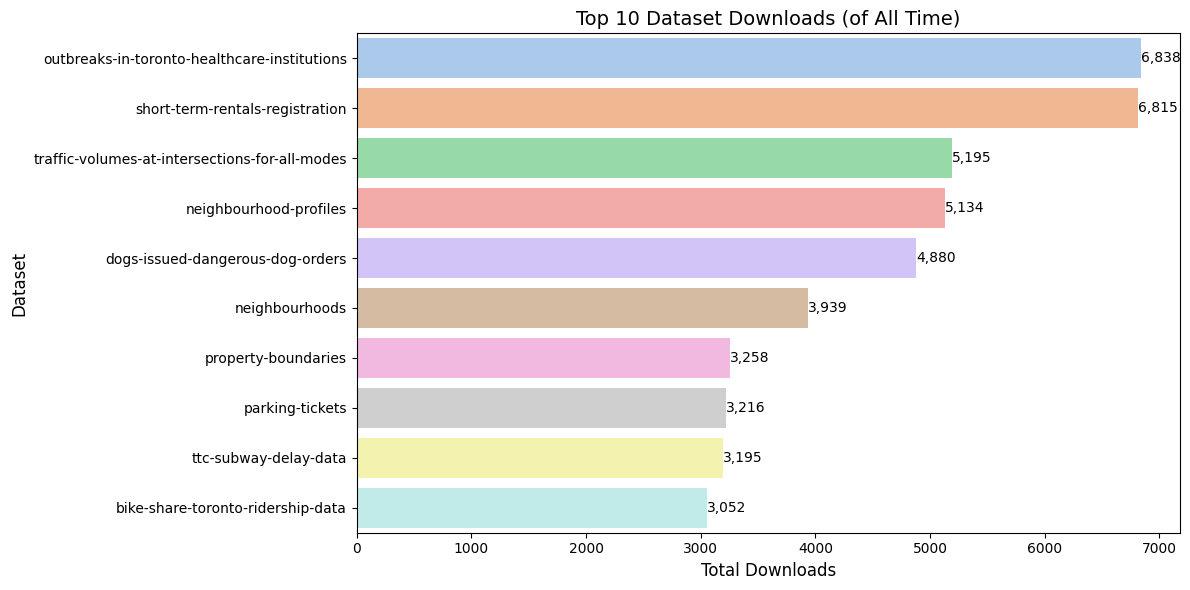

In [ ]:
# Group by owner division and sum views
top_10_dataset_downloads = total_dataset_downloads[:10]

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=top_10_dataset_downloads.reset_index(), 
                 x='Clicks', 
                 y='name',
                 hue='name',
                 palette='pastel',
                 legend=False)

# Adding labels to the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_width()):,}', 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='left', va='center')

# Decrease the scale of the x-axis - so that the labels do not go outside the graph
# plt.xlim(0, top_10_dataset_downloads.values.max() * 1)  # Adjust the multiplier as needed

plt.title('Top 10 Dataset Downloads (of All Time)', fontsize=14)
plt.xlabel('Total Downloads', fontsize=12)
plt.ylabel('Dataset', fontsize=12)


# Adjust layout to prevent label cutoff
plt.tight_layout()

## Dataset Downloads in 2023

In [ ]:
dataset_downloads_2023 = (file_url_clicks_df
                         .query('Year == "2023"')
                         .groupby('name', as_index=False)
                         .agg({'Clicks': 'sum'})
                        )
dataset_downloads_2023

name  Clicks
0    10-year-cycling-network-plan-on-street-2016      47
1       10-year-cycling-network-plan-trails-2016      36
2           2013-street-needs-assessment-results      14
3           2018-street-needs-assessment-results      35
4           2021-street-needs-assessment-results      54
..                                           ...     ...
447              wellbeing-youth-refugee-housing      21
448       wellbeing-youth-sexual-health-services      14
449      wellbeing-youth-substance-use-treatment       8
450         wellbeing-youth-transitional-housing      22
451                                zoning-by-law    1132

[452 rows x 2 columns]

In [ ]:
top_5_datasets_2023 = dataset_downloads_2023.nlargest(5, 'Clicks')['name']
top_5_datasets_2023

216      outbreaks-in-toronto-healthcare-institutions
305                   short-term-rentals-registration
379    traffic-volumes-at-intersections-for-all-modes
206                            neighbourhood-profiles
207                                    neighbourhoods
Name: name, dtype: object

In [308]:
# convert month to number
file_url_clicks_df['Month'] = file_url_clicks_df['Month'].astype(int)
# convert month to name
file_url_clicks_df['Month_Name'] = file_url_clicks_df['Month'].apply(lambda x: calendar.month_name[x])

# search_terms_df["Month_Name"] = search_terms_df["Month"].apply(lambda x: calendar.month_name[x])
top_5_monthly_2023 = (file_url_clicks_df
                 .query('Year == "2023"')
                 .groupby(['Month', 'Month_Name', 'name'], as_index=False)
                 .agg({'Clicks': 'sum'})
                 .query('name in @top_5_datasets_2023')  # Keep only top 5 datasets
                )

top_5_monthly_2023

Month Month_Name                                          name  Clicks
9         1    January                                    3d-massing      86
158       1    January                        neighbourhood-profiles     143
159       1    January                                neighbourhoods     184
164       1    January  outbreaks-in-toronto-healthcare-institutions     354
230       1    January               short-term-rentals-registration      97
358       2   February                                    3d-massing     139
513       2   February                        neighbourhood-profiles     164
514       2   February                                neighbourhoods     140
519       2   February  outbreaks-in-toronto-healthcare-institutions     319
588       2   February               short-term-rentals-registration      55
728       3      March                                    3d-massing     131
886       3      March                        neighbourhood-profiles     186
887       3      March                                neighbourhoods     304
894       3      March  outbreaks-in-toronto-healthcare-institutions     253
970       3      March               short-term-rentals-registration     110
1110      4      April                                    3d-massing      74
1267      4      April                        neighbourhood-profiles     126
1268      4      April                                neighbourhoods     155
1275      4      April  outbreaks-in-toronto-healthcare-institutions     230
1340      4      April               short-term-rentals-registration      83
1466      5        May                                    3d-massing      58
1615      5        May                        neighbourhood-profiles      84
1616      5        May                                neighbourhoods      64
1623      5        May  outbreaks-in-toronto-healthcare-institutions     166
1681      5        May               short-term-rentals-registration     119
1805      6       June                                    3d-massing      74
1962      6       June                        neighbourhood-profiles      63
1963      6       June                                neighbourhoods      71
1970      6       June  outbreaks-in-toronto-healthcare-institutions     110
2030      6       June               short-term-rentals-registration     315
2146      7       July                                    3d-massing      50
2302      7       July                        neighbourhood-profiles     103
2303      7       July                                neighbourhoods      81
2308      7       July  outbreaks-in-toronto-healthcare-institutions     165
2378      7       July               short-term-rentals-registration     377
2501      8     August                                    3d-massing      58
2651      8     August                        neighbourhood-profiles      59
2652      8     August                                neighbourhoods     102
2658      8     August  outbreaks-in-toronto-healthcare-institutions     127
2721      8     August               short-term-rentals-registration     325
2840      9  September                                    3d-massing     103
3003      9  September                        neighbourhood-profiles      88
3004      9  September                                neighbourhoods     143
3010      9  September  outbreaks-in-toronto-healthcare-institutions     236
3078      9  September               short-term-rentals-registration     271
3214     10    October                                    3d-massing     107
3378     10    October                        neighbourhood-profiles     225
3379     10    October                                neighbourhoods     152
3388     10    October  outbreaks-in-toronto-healthcare-institutions     292
3460     10    October               short-term-rentals-registration     455
3595     11   November                                    3d-massing      70
37

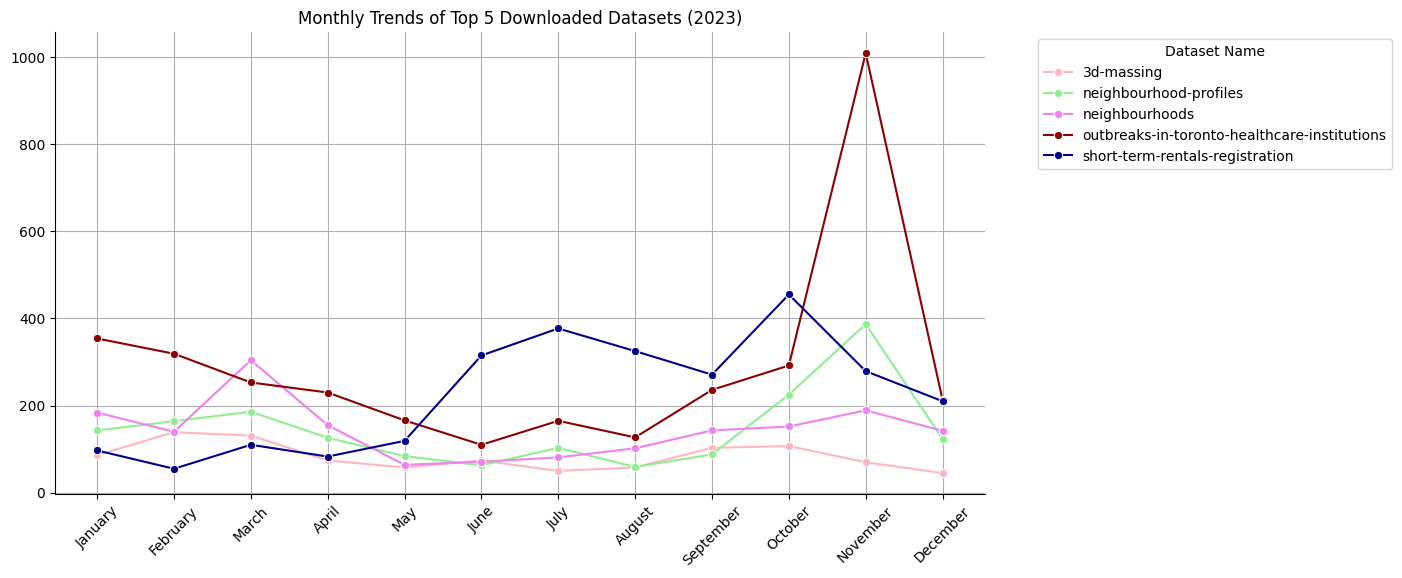

In [323]:
# Create palette with different light colors
light_colors = ['lightpink', 'lightgreen', 'violet'] 
custom_palette = {}
i = 0

for term in top_5_datasets_2023:
    if term == 'outbreaks-in-toronto-healthcare-institutions':
        custom_palette[term] = 'darkred'  
    elif term == 'short-term-rentals-registration':
        custom_palette[term] = 'darkblue'
    else:
        custom_palette[term] = light_colors[i]
        i += 1

plt.figure(figsize=(12, 6))
sns.lineplot(data=top_5_monthly_2023, 
                x='Month_Name', 
                y='Clicks', 
                hue='name', 
                marker='o',
                palette=custom_palette
                )

# Customization
plt.xlabel("")
plt.ylabel("")
plt.title("Monthly Trends of Top 5 Downloaded Datasets (2023)")
plt.legend(title="Dataset Name", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Rotate x-axis labels for better readability  
plt.xticks(rotation=45)
sns.despine()

# Show plot
plt.show()

   Month                                               name  Clicks
0     01       outbreaks-in-toronto-healthcare-institutions     354
1     01                                     neighbourhoods     184
2     01                    building-permits-active-permits     147
3     01     traffic-volumes-at-intersections-for-all-modes     147
4     01                             neighbourhood-profiles     143
5     02       outbreaks-in-toronto-healthcare-institutions     319
6     02  daily-shelter-overnight-service-occupancy-capa...     171
7     02                             neighbourhood-profiles     164
8     02     traffic-volumes-at-intersections-for-all-modes     164
9     02                                    parking-tickets     145
10    03                                     neighbourhoods     304
11    03     traffic-volumes-at-intersections-for-all-modes     257
12    03       outbreaks-in-toronto-healthcare-institutions     253
13    03                  bike-share-toronto-rid

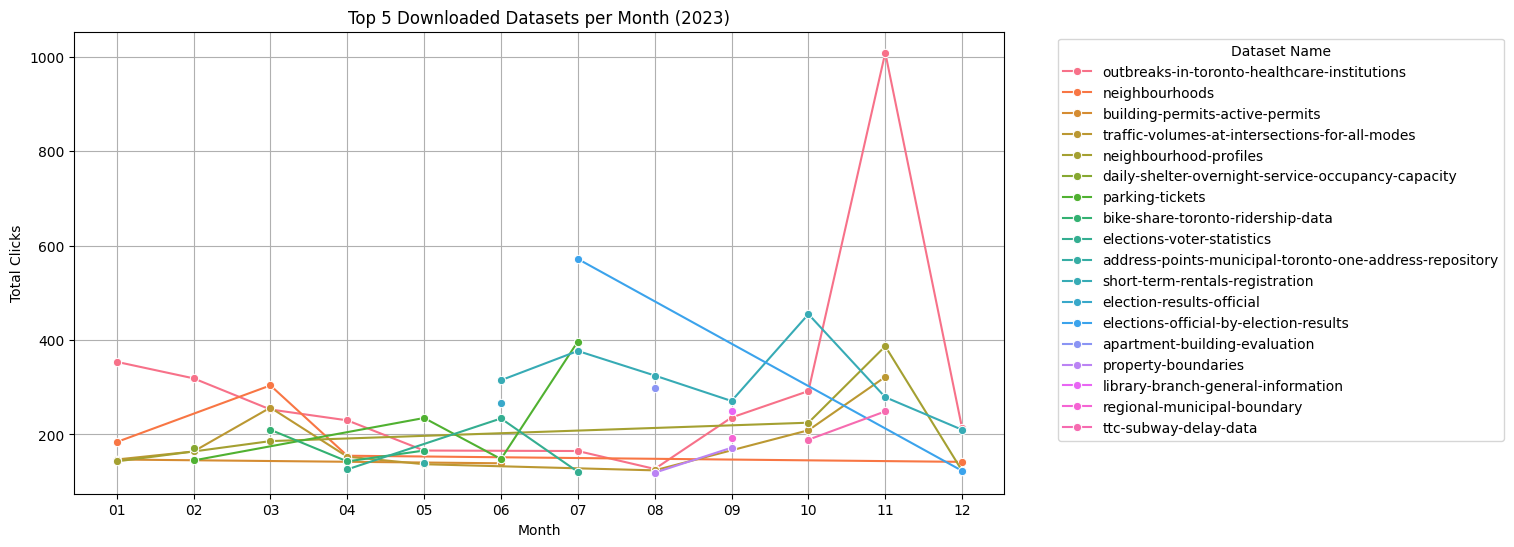

In [ ]:
# Step 1: Aggregate Clicks by Month and Name
monthly_downloads = (file_url_clicks_df
                     .query('Year == "2023"')
                     .groupby(['Month', 'name'], as_index=False)
                     .agg({'Clicks': 'sum'})
                    )

# Step 2: Get the Top 5 Downloaded Datasets for Each Month
top_5_per_month = (monthly_downloads
                   .groupby('Month')
                   .apply(lambda x: x.nlargest(5, 'Clicks'))
                   .reset_index(drop=True)
                  )

print(top_5_per_month)


import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'Month' to categorical for proper ordering
top_5_per_month['Month'] = top_5_per_month['Month'].astype(str)
top_5_per_month = top_5_per_month.sort_values('Month')

import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'Month' to categorical for proper ordering
top_5_per_month['Month'] = top_5_per_month['Month'].astype(str)
top_5_per_month = top_5_per_month.sort_values('Month')

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=top_5_per_month, x='Month', y='Clicks', hue='name', marker='o')

# Customization
plt.xlabel("Month")
plt.ylabel("Total Clicks")
plt.title("Top 5 Downloaded Datasets per Month (2023)")
plt.legend(title="Dataset Name", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Show plot
plt.show()

## Dataset Downloads in 2024

In [319]:
dataset_downloads_2024 = (file_url_clicks_df
                         .query('Year == "2024"')
                         .groupby('name', as_index=False)
                         .agg({'Clicks': 'sum'})
                        )
dataset_downloads_2024

name  Clicks
0    10-year-cycling-network-plan-on-street-2016      60
1       10-year-cycling-network-plan-trails-2016      51
2           2013-street-needs-assessment-results      13
3           2018-street-needs-assessment-results      24
4           2021-street-needs-assessment-results      49
..                                           ...     ...
496      wellbeing-youth-substance-use-treatment      20
497         wellbeing-youth-transitional-housing      33
498  woodbine-racetrack-casino-consultation-2015       7
499                     z39-50-library-catalogue      31
500                                zoning-by-law    1031

[501 rows x 2 columns]

In [320]:
top_5_datasets_2024 = dataset_downloads_2024.nlargest(5, 'Clicks')['name']


top_5_monthly_2024 = (file_url_clicks_df
                 .query('Year == "2024"')
                 .groupby(['Month', 'Month_Name', 'name'], as_index=False)
                 .agg({'Clicks': 'sum'})
                 .query('name in @top_5_datasets_2024')  # Keep only top 5 datasets
                )

top_5_monthly_2024

Month Month_Name                                            name  Clicks
188       1    January                          neighbourhood-profiles     232
196       1    January    outbreaks-in-toronto-healthcare-institutions     374
269       1    January                 short-term-rentals-registration     272
333       1    January  traffic-volumes-at-intersections-for-all-modes     207
562       2   February                          neighbourhood-profiles     277
569       2   February    outbreaks-in-toronto-healthcare-institutions     295
638       2   February                 short-term-rentals-registration     289
699       2   February  traffic-volumes-at-intersections-for-all-modes     295
934       3      March                          neighbourhood-profiles     405
941       3      March    outbreaks-in-toronto-healthcare-institutions     189
1014      3      March                 short-term-rentals-registration     280
1079      3      March  traffic-volumes-at-intersections-for-all-modes     382
1241      4      April                dogs-issued-dangerous-dog-orders    3879
1319      4      April                          neighbourhood-profiles     238
1328      4      April    outbreaks-in-toronto-healthcare-institutions     146
1399      4      April                 short-term-rentals-registration     300
1466      4      April  traffic-volumes-at-intersections-for-all-modes     230
1617      5        May                dogs-issued-dangerous-dog-orders     481
1693      5        May                          neighbourhood-profiles     155
1701      5        May    outbreaks-in-toronto-healthcare-institutions     142
1777      5        May                 short-term-rentals-registration     315
1840      5        May  traffic-volumes-at-intersections-for-all-modes     186
2004      6       June                dogs-issued-dangerous-dog-orders     169
2086      6       June                          neighbourhood-profiles     258
2093      6       June    outbreaks-in-toronto-healthcare-institutions     131
2174      6       June                 short-term-rentals-registration     244
2243      6       June  traffic-volumes-at-intersections-for-all-modes     149
2405      7       July                dogs-issued-dangerous-dog-orders     227
2484      7       July                          neighbourhood-profiles     167
2495      7       July    outbreaks-in-toronto-healthcare-institutions     197
2569      7       July                 short-term-rentals-registration     316
2637      7       July  traffic-volumes-at-intersections-for-all-modes     189
2793      8     August                dogs-issued-dangerous-dog-orders      24
2868      8     August                          neighbourhood-profiles     146
2876      8     August    outbreaks-in-toronto-healthcare-institutions     120
2958      8     August                 short-term-rentals-registration     247
3022      8     August  traffic-volumes-at-intersections-for-all-modes     186
3172      9  September                dogs-issued-dangerous-dog-orders      27
3259      9  September                          neighbourhood-profiles     212
3270      9  September    outbreaks-in-toronto-healthcare-institutions     186
3352      9  September                 short-term-rentals-registration     608
3422      9  September  traffic-volumes-at-intersections-for-all-modes     273
3584     10    October                dogs-issued-dangerous-dog-orders      29
3665     10    October                          neighbourhood-profiles     479
3673     10    October    outbreaks-in-toronto-healthcare-institutions     256
3754     10    October                 short-term-rentals-registration     483
3826     10    October  traffic-volumes-at-intersections-for-all-modes     317
3998     11   November                dogs-issued-dangerous-dog-orders      16
4085     11   November                          neighbourhood-profiles     408
4096     11   November    outbreaks-in-toronto-healthcar

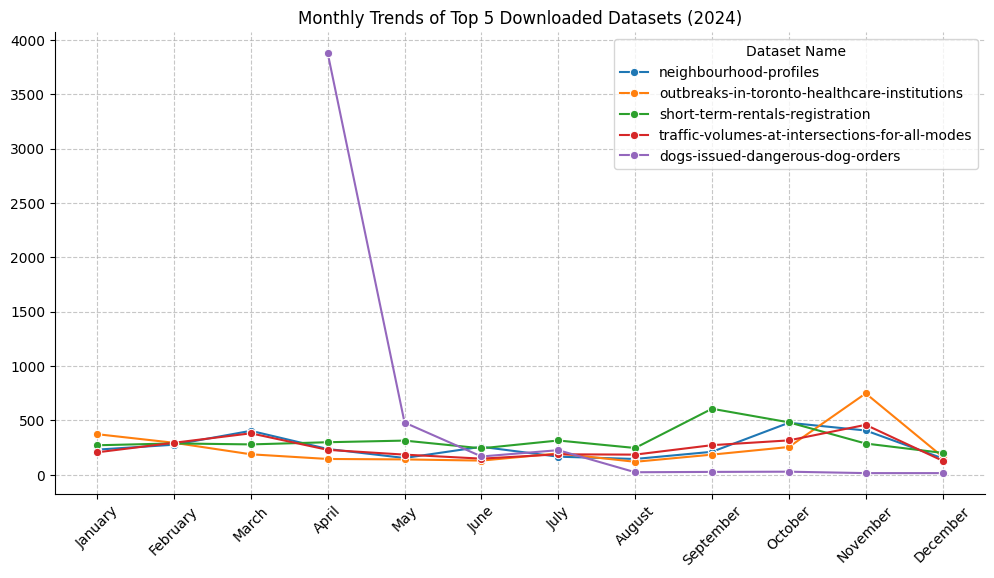

In [327]:
# Step 5: Plot the line graph
plt.figure(figsize=(12, 6))
sns.lineplot(data=top_5_monthly_2024, x='Month_Name', y='Clicks', hue='name', marker='o')

# Customization
plt.xlabel("")
plt.ylabel("")
plt.title("Monthly Trends of Top 5 Downloaded Datasets (2024)")
plt.legend(title="Dataset Name", loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

sns.despine()

# Show plot
plt.show()